### LTFS - Upsell Prediction - Topup 

We will Build a model given the Top-up loan bucket of 128655 customers along with demographic and bureau data, predict the right bucket/period for 14745 customers in the test data.

In this Notebook , We will first take only Customer Demographics Data and identify the important features from given features . Later will add more features from Bureau Data for each of the customer

In [ ]:
!pip install catboost

     |████████████████████████████████| 65.8MB 44kB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stat
pd.set_option('display.max_columns', None)
%matplotlib inline

### Feature Processing
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from dateutil import relativedelta
from sklearn.preprocessing import LabelEncoder

### Feature Selection Techniques
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import VarianceThreshold

### Train Test Split
from sklearn.model_selection import train_test_split

### Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import  XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

### Metrics
import sklearn.metrics as metrics

### Hyper Paramter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

### Loading and Saving Model
import pickle

### Ensemble Technique - Combining Multiple models
## We call the algorithms like this way

## Then we use Voting Classifier for ensemble learning:
from sklearn.ensemble import VotingClassifier

# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout


### Data Gathering - Demographics Dataset

In [ ]:
train_data = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/train_Data.xlsx')
test_data = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_Data.xlsx')

display(train_data.head())
display(test_data.head())

print(train_data.shape)
print(test_data.shape)

ID Frequency InstlmentMode LoanStatus   PaymentMode  BranchID      Area  \
0   1   Monthly        Arrear     Closed         PDC_E         1       NaN   
1   2   Monthly       Advance     Closed           PDC       333    BHOPAL   
2   3   Quatrly        Arrear     Active  Direct Debit         1       NaN   
3   7   Monthly       Advance     Closed        Billed       125      GUNA   
4   8   Monthly        Arrear     Closed        Billed       152  BILASPUR   

   Tenure  AssetCost  AmountFinance  DisbursalAmount      EMI DisbursalDate  \
0      48     450000       275000.0         275000.0  24000.0    2012-02-10   
1      47     485000       350000.0         350000.0  10500.0    2012-03-31   
2      68     690000       519728.0         519728.0  38300.0    2017-06-17   
3      48     480000       400000.0         400000.0  11600.0    2013-11-29   
4      44     619265       440000.0         440000.0  15000.0    2011-12-08   

  MaturityDAte   AuthDate   AssetID  ManufacturerID  SupplierID    LTV SEX  \
0   2016-01-15 2012-02-10   4022465            1568       21946  61.11   M   
1   2016-02-15 2012-03-31   4681175            1062       34802  70.00   M   
2   2023-02-10 2017-06-17  25328146            1060      127335  69.77   M   
3   2017-11-10 2013-11-29  13021591            1060       25094  80.92   M   
4   2015-07-05 2011-12-08   3291320            1046       21853  71.05   M   

    AGE  MonthlyIncome         City           State   ZiPCODE  \
0  49.0       35833.33       RAISEN  MADHYA PRADESH  464993.0   
1  23.0         666.67       SEHORE  MADHYA PRADESH  466001.0   
2  39.0       45257.00       BHOPAL  MADHYA PRADESH  462030.0   
3  24.0       20833.33  ASHOK NAGAR  MADHYA PRADESH  473335.0   
4  56.0       27313.67     BILASPUR     CHATTISGARH  495442.0   

        Top-up Month  
0        > 48 Months  
1  No Top-up Service  
2       12-18 Months  
3        > 48 Months  
4       36-48 Months

ID    Frequency InstlmentMode LoanStatus PaymentMode  BranchID     Area  \
0    4      Monthly       Advance     Closed       PDC_E         2     GUNA   
1    5      Monthly       Advance     Closed         PDC         2     GUNA   
2    6      Quatrly        Arrear     Closed         PDC         2     GUNA   
3   25  Half Yearly        Arrear     Closed      Billed       154      NaN   
4  119      Quatrly        Arrear     Closed         PDC       194  CUTTACK   

   Tenure  AssetCost  AmountFinance  DisbursalAmount      EMI DisbursalDate  \
0      46     480000       365000.0         365000.0   1000.0    2011-12-29   
1      45     480000       285000.0         285000.0   9300.0    2012-04-28   
2      48     580000       400000.0         400000.0  35800.0    2013-10-22   
3      36     725000       500000.0         500000.0  52000.0    2013-05-21   
4      48     617000       400000.0         400000.0  35400.0    2012-11-30   

  MaturityDAte   AuthDate   AssetID  ManufacturerID  SupplierID    LTV SEX  \
0   2015-10-05 2011-12-29   3524747          1046.0       22354  75.83   M   
1   2016-01-01 2012-04-28   4985862          1046.0       22354  57.44   M   
2   2017-09-10 2013-10-22  12881783          1060.0       65929  68.97   M   
3   2016-02-10 2013-05-21  10613776          1049.0       68597  61.79   M   
4   2016-12-05 2012-11-30   7911110          1049.0       38493  59.09   M   

    AGE  MonthlyIncome            City           State   ZiPCODE  
0  50.0       32069.00            GUNA  MADHYA PRADESH  473001.0  
1  35.0       25000.00            GUNA  MADHYA PRADESH  473001.0  
2  37.0       23333.33            GUNA  MADHYA PRADESH  473001.0  
3  55.0       91666.67      MAHASAMUND     CHATTISGARH  493558.0  
4  48.0       12500.00  JAGATSINGHAPUR          ORISSA  754137.0

(128655, 26)
(14745, 25)




Converting Dependent Variable Categories to Numerical Values 

In [ ]:
top_up_class_label_dict = {
    'No Top-up Service':0,
    ' > 48 Months':1,
    '36-48 Months':2,
    '24-30 Months':3,
    '30-36 Months':4,
    '18-24 Months':5,
    '12-18 Months':6
}
train_data['top_up_class'] = train_data['Top-up Month'].map(top_up_class_label_dict)
display(train_data.head(5))

### Dropping out features which are not usefull 

Features which contains all unique values and no pattern can be derived from that attribute

In [ ]:
def find_unique_values_to_drop_out(features):
  for feature in features:
    print(feature + ' : ' , len(train_data[feature].unique()))

find_unique_values_to_drop_out(['ID','AssetID'])

ID :  128655
AssetID :  128655


Since AssesID and ID both have unique values equal to Total length of dataset , we will remove this 2 columns

We will also remove TOP-UP-Month because we have replaced each category to numerical values in top_up_class

In [ ]:
train_data = train_data.drop(['ID','AssetID','Top-up Month'],axis=1)

### Finding Out Missing Values --- Train Demographics Dataset

In [ ]:
train_data.isnull().sum()

Frequency              0
InstlmentMode          0
LoanStatus             0
PaymentMode            0
BranchID               0
Area               11653
Tenure                 0
AssetCost              0
AmountFinance          0
DisbursalAmount        0
EMI                    0
DisbursalDate          0
MaturityDAte           1
AuthDate               0
ManufacturerID         0
SupplierID             0
LTV                    0
SEX                   59
AGE                   59
MonthlyIncome        234
City               11256
State                  0
ZiPCODE              372
top_up_class           0
dtype: int64

In [ ]:
### Fill null values of Age with Median
train_data['AGE'] =train_data['AGE'].fillna(train_data['AGE'].median())

In [ ]:
train_data['MonthlyIncome'] =train_data['MonthlyIncome'].fillna(train_data['MonthlyIncome'].median())

### Replace Zip code value based on State 

First We will identify the Mode value for each state and then replace with Missing Value in ZiPcode

In below example , You can see some states have all unique values and no mode can be found.In that case we will replace our missing value with First value of list like 160036 in Chandigarh

In [ ]:
groupby_state_zipcode = train_data.groupby('State')['ZiPCODE'].agg(pd.Series.mode)
print(type(groupby_state_zipcode))
groupby_state_zipcode

<class 'pandas.core.series.Series'>


State
ANDHRA PRADESH                                                       508204
ASSAM                                                                782124
BIHAR                                                                824112
CHANDIGARH                                             [160036.0, 160101.0]
CHATTISGARH                                                          495001
DADRA AND NAGAR HAVELI                                               396235
DELHI                     [110000.0, 110003.0, 110012.0, 110016.0, 11003...
GUJARAT                                                              383235
HARYANA                                                              125001
HIMACHAL PRADESH                                                     174101
JHARKHAND                                                            833201
KARNATAKA                                                            584128
MADHYA PRADESH                                                       464228
MAHARA

In [ ]:
groupby_state_zipcode['CHANDIGARH']=160036
groupby_state_zipcode['DELHI']=110000
groupby_state_zipcode

Now we will replace null values of ZIPCODE with Above Mode value identified from State

In [ ]:
def impute_zipcode(cols):
  zipcode = cols[0]
  state = cols[1]
  if pd.isnull(zipcode):
    return groupby_state_zipcode[state]
  else:
    return zipcode

In [ ]:
train_data['ZiPCODE'] = train_data[['ZiPCODE','State']].apply(impute_zipcode,axis=1)

In [ ]:
train_data['SEX'] = train_data['SEX'].fillna(train_data['SEX'].value_counts().index[0])

Since Zipcode represents Area and City we can remove both City and Area

In [ ]:
train_data = train_data.drop(['Area','City'],axis=1)
train_data.shape

(128655, 22)

#### Maturity Date

We will remove that row

In [ ]:
train_data.dropna(axis=0,inplace=True)
train_data.shape

(128654, 22)

In [ ]:
train_data.index = range(0,len(train_data))

Since we already have a Feature of Tenure which is Difference of months between Disbursal date and Maturity date , We can remove both columns 

And as said , Disbursal date and Auth Date are almost similar, There is not much variance . We will remove this columns also

In [ ]:
train_data = train_data.drop(['DisbursalDate','MaturityDAte','AuthDate'],axis=1)

### Categorical Variables and Cardinality of Categorical Varaibles 

In [ ]:
categorical_features = ['Frequency', 'InstlmentMode', 'LoanStatus', 'PaymentMode','SEX','State']

### Cardinality of Categorical Variables
for feature in categorical_features:
  print('Feature : {} ------- Number of Unique Categories : {} '.format(feature,len(train_data[feature].unique())))

Feature : Frequency ------- Number of Unique Categories : 4 
Feature : InstlmentMode ------- Number of Unique Categories : 2 
Feature : LoanStatus ------- Number of Unique Categories : 2 
Feature : PaymentMode ------- Number of Unique Categories : 11 
Feature : SEX ------- Number of Unique Categories : 2 
Feature : State ------- Number of Unique Categories : 22 


#### TEST DATA

Before Performing Categorical Encoding , We will do Data preprocessing of Test Data and combine with Train to do final categorical encoding

In [ ]:
test_data = test_data.drop(['ID','AssetID','Area','City','DisbursalDate','MaturityDAte','AuthDate'],axis=1)

In [ ]:
test_data.isnull().sum()

Frequency           0
InstlmentMode       0
LoanStatus          0
PaymentMode         0
BranchID            0
Tenure              0
AssetCost           0
AmountFinance       0
DisbursalAmount     0
EMI                 0
ManufacturerID      2
SupplierID          0
LTV                 0
SEX                 5
AGE                 7
MonthlyIncome      14
State               0
ZiPCODE             1
dtype: int64

In [ ]:
test_data['AGE'] =test_data['AGE'].fillna(test_data['AGE'].median())
test_data['MonthlyIncome'] =test_data['MonthlyIncome'].fillna(test_data['MonthlyIncome'].median())

In [ ]:
test_data['ManufacturerID'] = test_data['ManufacturerID'].fillna(test_data['ManufacturerID'].mode()[0])

In [ ]:
test_data['ZiPCODE'] = test_data[['ZiPCODE','State']].apply(impute_zipcode,axis=1)

In [ ]:
test_data['SEX'] = test_data['SEX'].fillna(test_data['SEX'].value_counts().index[0])
test_data.isnull().sum()

Frequency          0
InstlmentMode      0
LoanStatus         0
PaymentMode        0
BranchID           0
Tenure             0
AssetCost          0
AmountFinance      0
DisbursalAmount    0
EMI                0
ManufacturerID     0
SupplierID         0
LTV                0
SEX                0
AGE                0
MonthlyIncome      0
State              0
ZiPCODE            0
dtype: int64

### Categorical varaibles and Cardinality of Test data

In [ ]:
categorical_features = ['Frequency', 'InstlmentMode', 'LoanStatus', 'PaymentMode','SEX','State']

### Cardinality of Categorical Variables
for feature in categorical_features:
  print('Feature : {} ------- Number of Unique Categories : {} '.format(feature,len(test_data[feature].unique())))

Feature : Frequency ------- Number of Unique Categories : 3 
Feature : InstlmentMode ------- Number of Unique Categories : 2 
Feature : LoanStatus ------- Number of Unique Categories : 2 
Feature : PaymentMode ------- Number of Unique Categories : 10 
Feature : SEX ------- Number of Unique Categories : 2 
Feature : State ------- Number of Unique Categories : 18 


In [ ]:
final_df = pd.concat([train_data,test_data],axis=0)
final_df.head()

Frequency InstlmentMode LoanStatus   PaymentMode  BranchID  Tenure  \
0   Monthly        Arrear     Closed         PDC_E         1      48   
1   Monthly       Advance     Closed           PDC       333      47   
2   Quatrly        Arrear     Active  Direct Debit         1      68   
3   Monthly       Advance     Closed        Billed       125      48   
4   Monthly        Arrear     Closed        Billed       152      44   

   AssetCost  AmountFinance  DisbursalAmount      EMI  ManufacturerID  \
0     450000       275000.0         275000.0  24000.0          1568.0   
1     485000       350000.0         350000.0  10500.0          1062.0   
2     690000       519728.0         519728.0  38300.0          1060.0   
3     480000       400000.0         400000.0  11600.0          1060.0   
4     619265       440000.0         440000.0  15000.0          1046.0   

   SupplierID    LTV SEX   AGE  MonthlyIncome           State   ZiPCODE  \
0       21946  61.11   M  49.0       35833.33  MADHYA PRADESH  464993.0   
1       34802  70.00   M  23.0         666.67  MADHYA PRADESH  466001.0   
2      127335  69.77   M  39.0       45257.00  MADHYA PRADESH  462030.0   
3       25094  80.92   M  24.0       20833.33  MADHYA PRADESH  473335.0   
4       21853  71.05   M  56.0       27313.67     CHATTISGARH  495442.0   

   top_up_class  
0           1.0  
1           0.0  
2           6.0  
3           1.0  
4           2.0

In [ ]:
categorical_features = ['Frequency', 'InstlmentMode', 'LoanStatus', 'PaymentMode','SEX','State']

### Cardinality of Categorical Variables
for feature in categorical_features:
  print('Feature : {} ------- Number of Unique Categories : {} '.format(feature,len(final_df[feature].unique())))

Feature : Frequency ------- Number of Unique Categories : 4 
Feature : InstlmentMode ------- Number of Unique Categories : 2 
Feature : LoanStatus ------- Number of Unique Categories : 2 
Feature : PaymentMode ------- Number of Unique Categories : 11 
Feature : SEX ------- Number of Unique Categories : 2 
Feature : State ------- Number of Unique Categories : 22 


In [ ]:
final_df = pd.get_dummies(final_df,drop_first=True)
final_df.head()

BranchID  Tenure  AssetCost  AmountFinance  DisbursalAmount      EMI  \
0         1      48     450000       275000.0         275000.0  24000.0   
1       333      47     485000       350000.0         350000.0  10500.0   
2         1      68     690000       519728.0         519728.0  38300.0   
3       125      48     480000       400000.0         400000.0  11600.0   
4       152      44     619265       440000.0         440000.0  15000.0   

   ManufacturerID  SupplierID    LTV   AGE  MonthlyIncome   ZiPCODE  \
0          1568.0       21946  61.11  49.0       35833.33  464993.0   
1          1062.0       34802  70.00  23.0         666.67  466001.0   
2          1060.0      127335  69.77  39.0       45257.00  462030.0   
3          1060.0       25094  80.92  24.0       20833.33  473335.0   
4          1046.0       21853  71.05  56.0       27313.67  495442.0   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0           1.0                      0                  1                  0   
1           0.0                      0                  1                  0   
2           6.0                      0                  0                  1   
3           1.0                      0                  1                  0   
4           2.0                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  PaymentMode_Billed  \
0                     1                  1                   0   
1                     0                  1                   0   
2                     1                  0                   0   
3                     0                  1                   1   
4                     1                  1                   1   

   PaymentMode_Cheque  PaymentMode_Direct Debit  PaymentMode_ECS  \
0                   0                         0                0   
1                   0                         0                0   
2                   0                         1                0   
3                   0                         0                0   
4                   0                         0                0   

   PaymentMode_ECS Reject  PaymentMode_Escrow  PaymentMode_PDC  \
0                       0                   0                0   
1                       0                   0                1   
2                       0                   0                0   
3                       0                   0                0   
4                       0                   0                0   

   PaymentMode_PDC Reject  PaymentMode_PDC_E  PaymentMode_SI Reject  SEX_M  \
0                       0                  1                      0      1   
1                       0                  0                      0      1   
2                       0                  0                      0      1   
3                       0                  0                      0      1   
4                       0                  0                      0      1   

   State_ASSAM  State_BIHAR  State_CHANDIGARH  State_CHATTISGARH  \
0            0            0                 0                  0   
1            0            0                 0                  0   
2            0            0                 0                  0   
3            0            0                 0                  0   
4            0            0                 0                  1   

   State_DADRA AND NAGAR HAVELI  State_DELHI  State_GUJARAT  State_HARYANA  \
0                             0            0              0              0   
1                             0            0              0              0   
2                             0            0              0              0   
3                             0            0              0              0   
4                             0            0              0              0   

   State_HIMACHAL PRADESH  State_JHARKHAND  State_KARNATAKA  \
0                       0      

In [ ]:
final_df.iloc[128653:128658,:]

BranchID  Tenure  AssetCost  AmountFinance  DisbursalAmount      EMI  \
128653       424      24     370000       200428.0         200428.0  59200.0   
0              2      46     480000       365000.0         365000.0   1000.0   
1              2      45     480000       285000.0         285000.0   9300.0   
2              2      48     580000       400000.0         400000.0  35800.0   
3            154      36     725000       500000.0         500000.0  52000.0   

        ManufacturerID  SupplierID    LTV   AGE  MonthlyIncome   ZiPCODE  \
128653          1568.0       48879  54.17  33.0      178166.67  131402.0   
0               1046.0       22354  75.83  50.0       32069.00  473001.0   
1               1046.0       22354  57.44  35.0       25000.00  473001.0   
2               1060.0       65929  68.97  37.0       23333.33  473001.0   
3               1049.0       68597  61.79  55.0       91666.67  493558.0   

        top_up_class  Frequency_Half Yearly  Frequency_Monthly  \
128653           0.0                      1                  0   
0                NaN                      0                  1   
1                NaN                      0                  1   
2                NaN                      0                  0   
3                NaN                      1                  0   

        Frequency_Quatrly  InstlmentMode_Arrear  LoanStatus_Closed  \
128653                  0                     1                  0   
0                       0                     0                  1   
1                       0                     0                  1   
2                       1                     1                  1   
3                       0                     1                  1   

        PaymentMode_Billed  PaymentMode_Cheque  PaymentMode_Direct Debit  \
128653                   0                   0                         1   
0                        0                   0                         0   
1                        0                   0                         0   
2                        0                   0                         0   
3                        1                   0                         0   

        PaymentMode_ECS  PaymentMode_ECS Reject  PaymentMode_Escrow  \
128653                0                       0                   0   
0                     0                       0                   0   
1                     0                       0                   0   
2                     0                       0                   0   
3                     0                       0                   0   

        PaymentMode_PDC  PaymentMode_PDC Reject  PaymentMode_PDC_E  \
128653                0                       0                  0   
0                     0                       0                  1   
1                     1                       0                  0   
2                     1                       0                  0   
3                     0                       0                  0   

        PaymentMode_SI Reject  SEX_M  State_ASSAM  State_BIHAR  \
128653                      0      1            0            0   
0                           0      1            0            0   
1                           0      1            0            0   
2                           0      1            0            0   
3                           0      1            0            0   

        State_CHANDIGARH  State_CHATTISGARH  State_DADRA AND NAGAR HAVELI  \
128653                 0                  0                             0   
0                      0                  0                             0   
1                      0                  0                             0   
2                      0                  0                             0   
3                      0                  1                             0   

        State_DELHI  State_GUJARAT  State_HARYANA  State_HIMACHAL PRADESH  \
128653    

In [ ]:
final_df.index = range(0,len(final_df))

In [ ]:
train_data_final = final_df.iloc[:128654,:]
test_data_final = final_df.iloc[128654:,:]

In [ ]:
train_data_final['top_up_class'] = train_data_final['top_up_class'].astype(int)

In [ ]:
test_data_final = test_data_final.drop('top_up_class',axis=1)

In [ ]:
test_data_final.index = range(0,len(test_data_final))

In [ ]:
print(train_data_final.shape)
print(test_data_final.shape)

(128654, 50)
(14745, 49)


### Model Training - First Version

In [ ]:
y = train_data_final['top_up_class']
X = train_data_final.drop('top_up_class',axis=1)

print(X.shape)
print(y.shape)

(128654, 49)
(128654,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(102923, 49) (25731, 49) (102923,) (25731,)


In [ ]:
#creating a dictionary of the models(estimators) 
estimators = {
    'Logistic Regression': [LogisticRegression()],
    'KNN' :[KNeighborsClassifier()],
    'Decision Tree' :[DecisionTreeClassifier()],
    'Support Vector Regression':[SVC()],
    'Random Forest' :[RandomForestClassifier()],
    'Gradient Boosting':[GradientBoostingClassifier()],
    'XG Boost': [XGBClassifier()],
    'LGBM':[LGBMClassifier()],
    'Cat Boost':[CatBoostClassifier(verbose=0, n_estimators=100)],
}

#writing a function to fit models above to the train dataset
def mfit(estimators, X_train, y_train):
    for m in estimators:
        estimators[m][0].fit(X_train, y_train)
        print(m+' fitted')

mfit(estimators, X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression fitted
KNN fitted
Decision Tree fitted
Support Vector Regression fitted
Random Forest fitted
Gradient Boosting fitted
XG Boost fitted
LGBM fitted
Cat Boost fitted


In [ ]:
#applying the fitted models to the test dataset
def mpredict(estimators, X_test, y_test):
    outcome = dict()
    for m in estimators:
        y_pred = estimators[m][0].predict(X_test)
        outcome[m] = [metrics.f1_score(y_test,y_pred,average='macro'),
                      metrics.accuracy_score(y_test,y_pred),
                      metrics.classification_report(y_test,y_pred)]
    return outcome

outcome = mpredict(estimators, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classificat

In [ ]:
for m in outcome:
    print('------------------------'+m+'------------------------')
    print('F1 Score', round(outcome[m][0],4))
    print('Accuracy Score', round(outcome[m][1],4))
    print('Classification report \n ')
    print(outcome[m][2])
    print('\n')

------------------------Logistic Regression------------------------
F1 Score 0.1293
Accuracy Score 0.827
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     21279
           1       0.00      0.00      0.00      1642
           2       0.00      0.00      0.00       761
           3       0.00      0.00      0.00       683
           4       0.00      0.00      0.00       663
           5       0.00      0.00      0.00       502
           6       0.00      0.00      0.00       201

    accuracy                           0.83     25731
   macro avg       0.12      0.14      0.13     25731
weighted avg       0.68      0.83      0.75     25731



------------------------KNN------------------------
F1 Score 0.138
Accuracy Score 0.8195
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      0.99      0.90     21279
           1       0.17      0.02      0.04     

#### Feature Selection

Multivariate Correlation -  Independent and Dependent Features

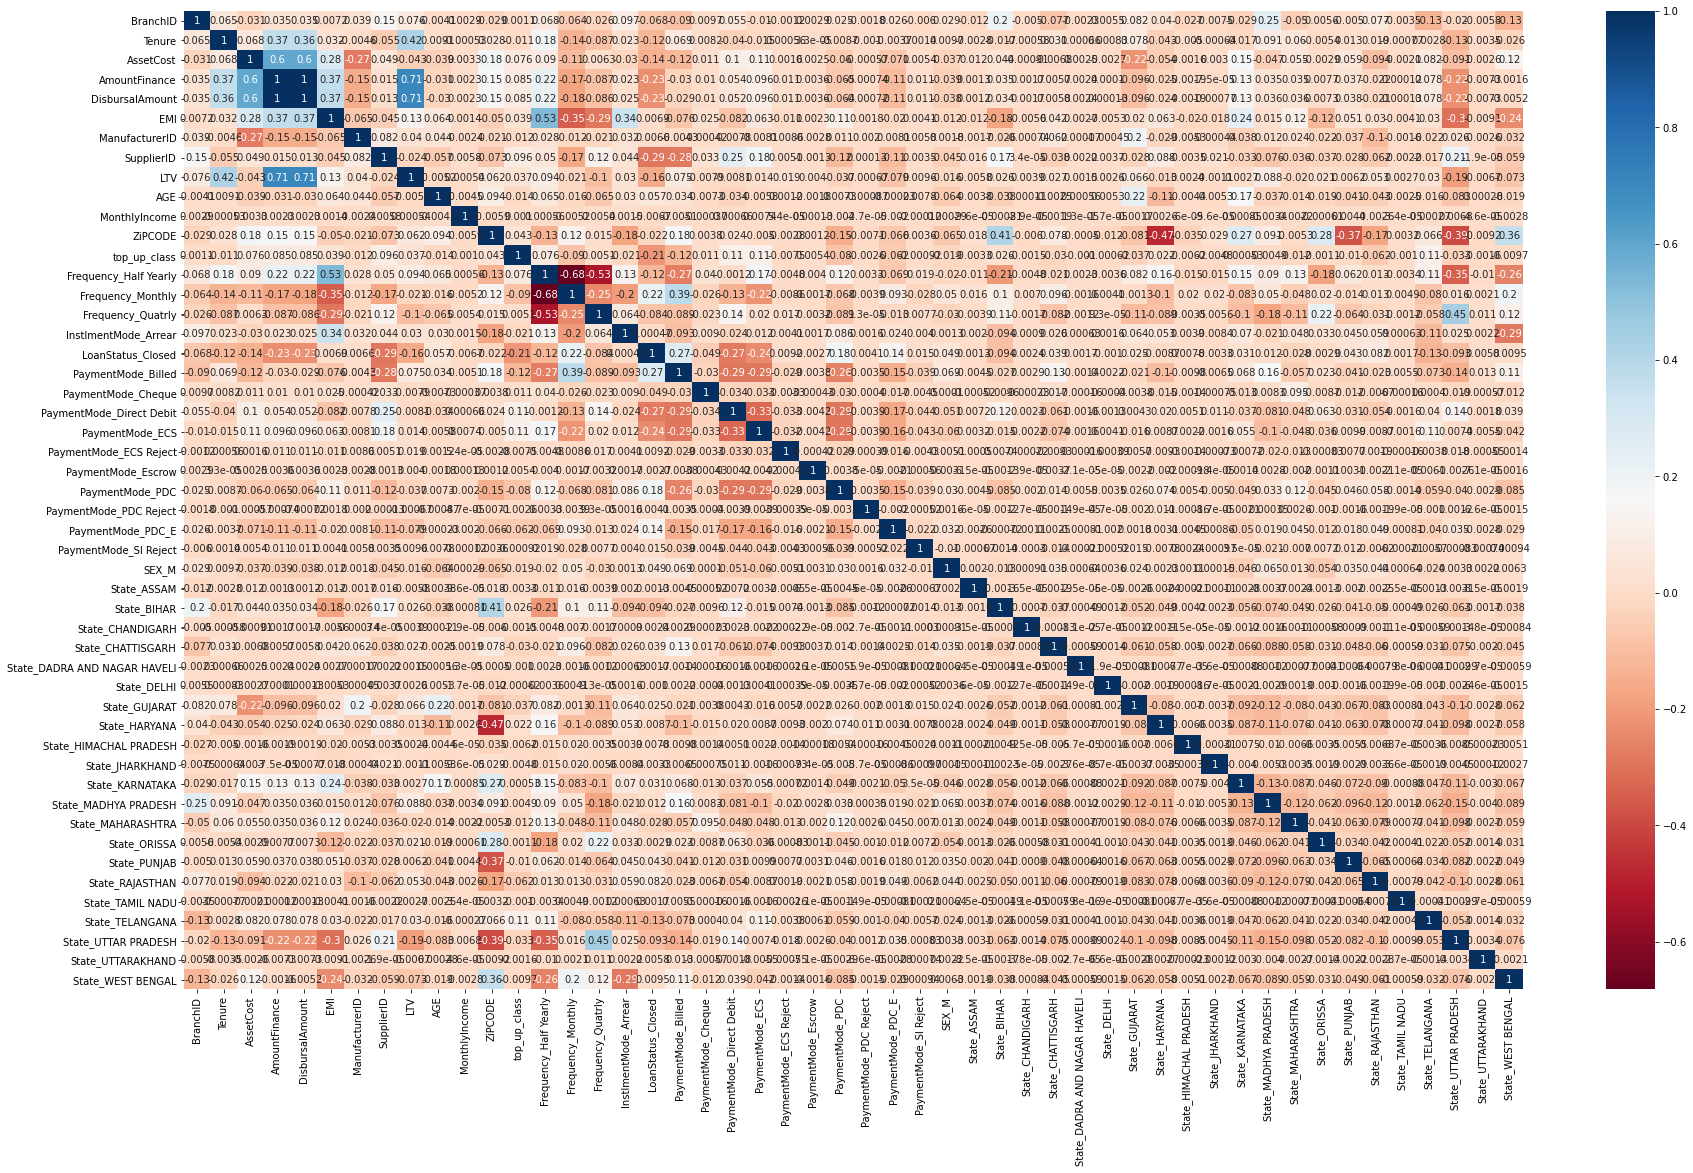

In [ ]:
dataset = train_new.copy()
plt.figure(figsize=(30, 18))
sns.heatmap(dataset.corr(),annot=True,cmap='RdBu')
plt.show()

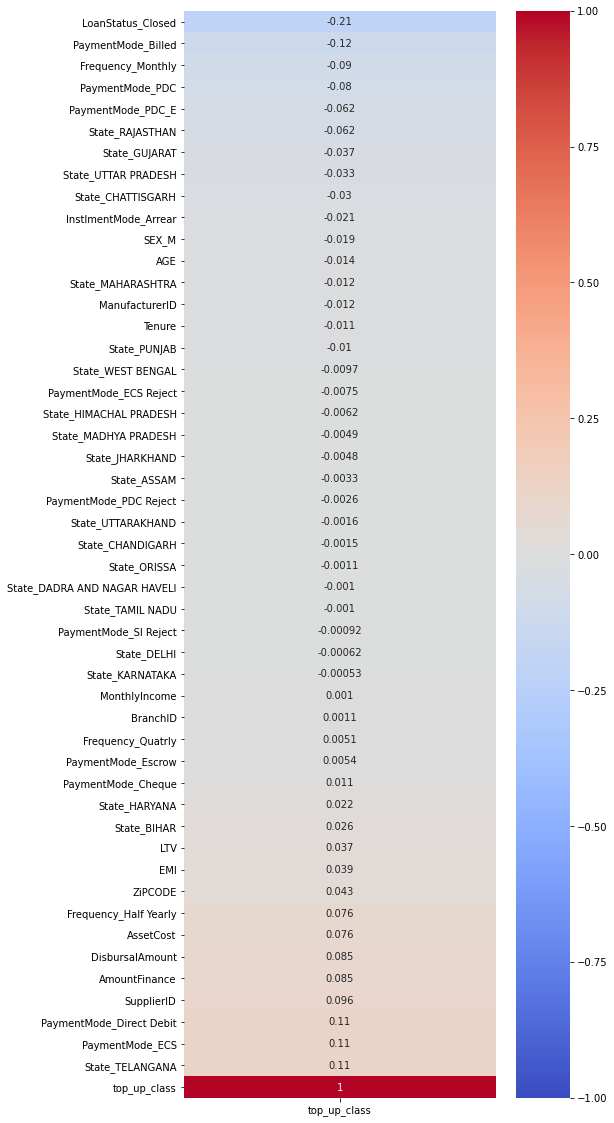

In [ ]:
plt.figure(figsize=(7, 20))
sns.heatmap(dataset.corr()[['top_up_class']].sort_values(by='top_up_class'), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1) 

Correlation between Independent features

In [ ]:
dataset_only_independent = dataset.copy()
dataset_only_independent = dataset_only_independent.drop(['top_up_class'],axis=1)
dataset_only_independent.head(2)

BranchID  Tenure  AssetCost  AmountFinance  DisbursalAmount      EMI  \
0         1      48     450000       275000.0         275000.0  24000.0   
1       333      47     485000       350000.0         350000.0  10500.0   

   ManufacturerID  SupplierID    LTV  AGE  MonthlyIncome  ZiPCODE  \
0            1568       21946  61.11   49       35833.33   464993   
1            1062       34802  70.00   23         666.67   466001   

   Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0                      0                  1                  0   
1                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  PaymentMode_Billed  \
0                     1                  1                   0   
1                     0                  1                   0   

   PaymentMode_Cheque  PaymentMode_Direct Debit  PaymentMode_ECS  \
0                   0                         0                0   
1                   0                         0                0   

   PaymentMode_ECS Reject  PaymentMode_Escrow  PaymentMode_PDC  \
0                       0                   0                0   
1                       0                   0                1   

   PaymentMode_PDC Reject  PaymentMode_PDC_E  PaymentMode_SI Reject  SEX_M  \
0                       0                  1                      0      1   
1                       0                  0                      0      1   

   State_ASSAM  State_BIHAR  State_CHANDIGARH  State_CHATTISGARH  \
0            0            0                 0                  0   
1            0            0                 0                  0   

   State_DADRA AND NAGAR HAVELI  State_DELHI  State_GUJARAT  State_HARYANA  \
0                             0            0              0              0   
1                             0            0              0              0   

   State_HIMACHAL PRADESH  State_JHARKHAND  State_KARNATAKA  \
0                       0                0                0   
1                       0                0                0   

   State_MADHYA PRADESH  State_MAHARASHTRA  State_ORISSA  State_PUNJAB  \
0                     1                  0             0             0   
1                     1                  0             0             0   

   State_RAJASTHAN  State_TAMIL NADU  State_TELANGANA  State_UTTAR PRADESH  \
0                0                 0                0                    0   
1                0                 0                0                    0   

   State_UTTARAKHAND  State_WEST BENGAL  
0                  0                  0  
1                  0                  0

In [ ]:
def high_correlation_train_set_indpendent(dataset,threshold):
    col_corr = set() #Set of all names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # It also consider -ve corr - You can remove abs() - If you dont wont to consider -ve corr
            if abs(corr_matrix.iloc[i,j]) > threshold: 
                col_name = corr_matrix.columns[i]
                col_corr.add(col_name)
    return col_corr

### These function return correlated features which are to be removed , Becaause they are correlated with any other feature

In [ ]:
corr_features = high_correlation_train_set_indpendent(dataset_only_independent,0.7)
corr_features

{'DisbursalAmount', 'LTV'}

##### Feature Selection/Importance Techniques

For now, we have a rough idea of variables that are positively and negatively correlated with the target feature. To make final decision, which variables from highly correlated we will use for our model, we need to access the strength of the "true" correlation between predictors

#### 1. Extra Trees Classifier Technique - Feature Importance

In [ ]:
y_og_values = dataset['top_up_class']
y_og_values.head()

0    1
1    0
2    6
3    1
4    2
Name: top_up_class, dtype: int64

In [ ]:
model_feature_Selection = ExtraTreesClassifier()
model_feature_Selection.fit(dataset_only_independent,y_og_values)
print(model_feature_Selection.feature_importances_)

[5.33671673e-02 5.97748214e-02 8.13765094e-02 7.51909796e-02
 7.52819730e-02 8.67818490e-02 5.30869258e-02 7.14273489e-02
 8.76080499e-02 8.83989663e-02 9.37742399e-02 8.72261293e-02
 3.17057559e-03 2.90580697e-03 2.89499210e-03 4.05106500e-03
 1.34527051e-02 3.08917447e-03 6.95719817e-04 5.53968907e-03
 5.33134510e-03 8.14530845e-04 4.88997157e-05 3.40454985e-03
 2.48287927e-06 2.36776105e-03 1.16877119e-03 8.02326644e-03
 3.44194748e-06 1.10117044e-03 5.06639120e-07 2.26358115e-03
 7.96030598e-07 1.98412140e-05 2.13001417e-03 1.66566691e-03
 5.80789534e-05 1.01251813e-05 2.85510700e-03 3.33099385e-03
 2.44963753e-03 1.12604581e-03 1.71951650e-03 2.32412871e-03
 3.40913320e-07 4.74251973e-03 2.52887787e-03 4.23072824e-05
 1.37100709e-03]


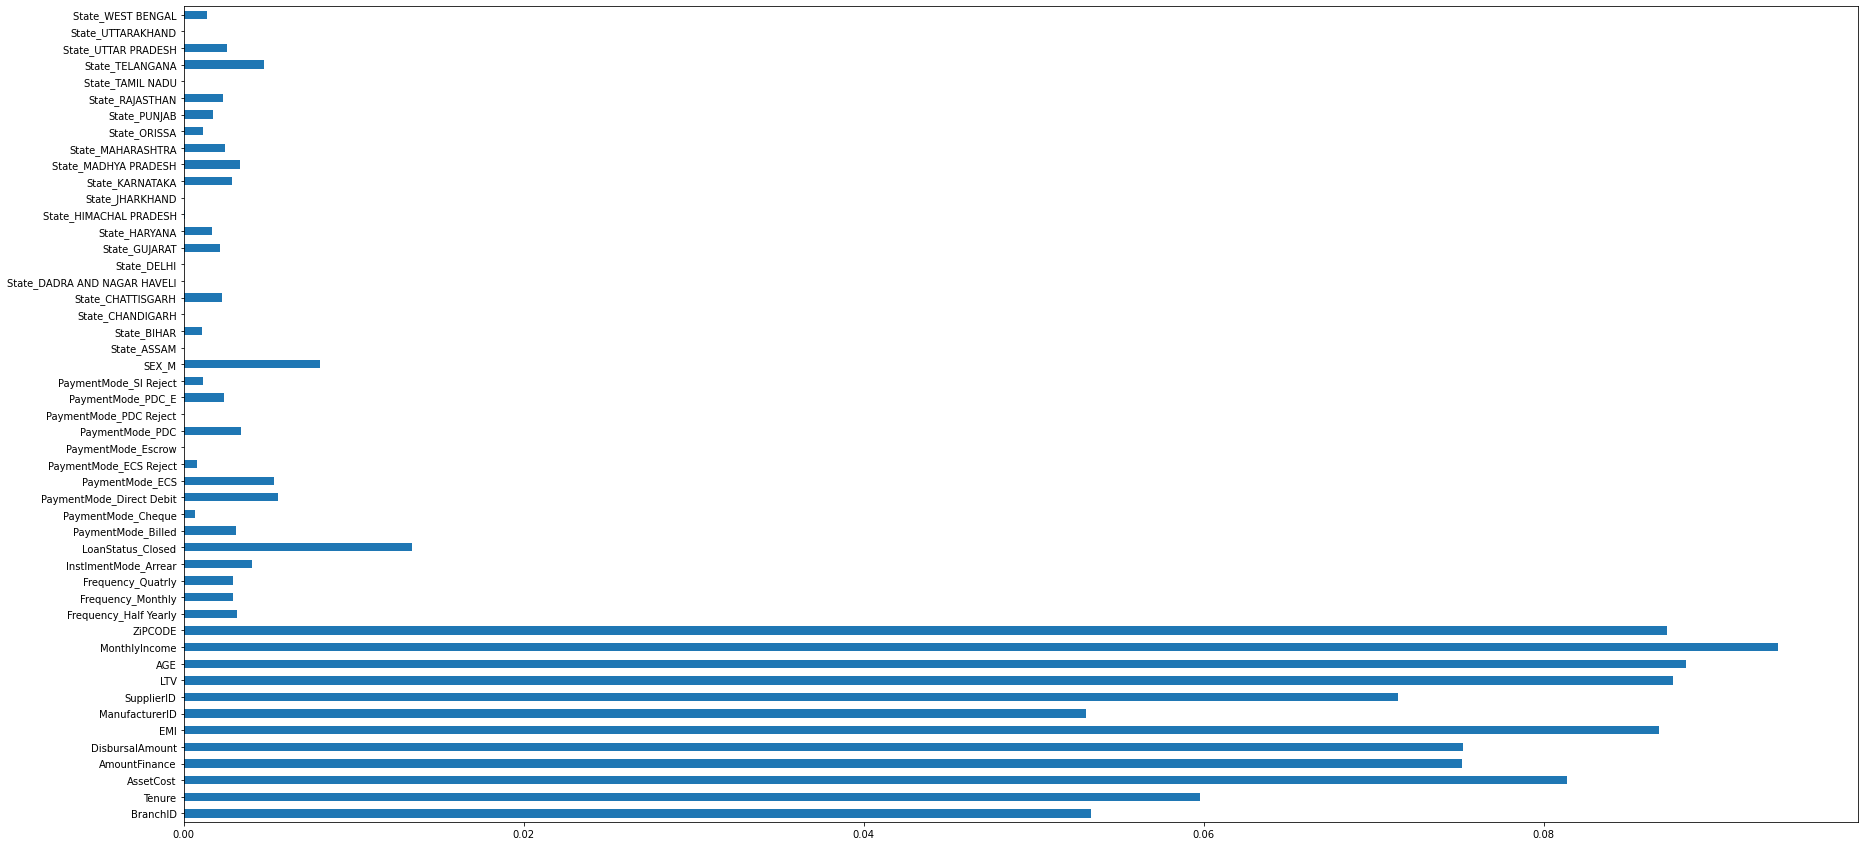

In [ ]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model_feature_Selection.feature_importances_, index=dataset_only_independent.columns)
fig=plt.figure(figsize=[30,15])
feat_importances.plot(kind='barh')
plt.show()

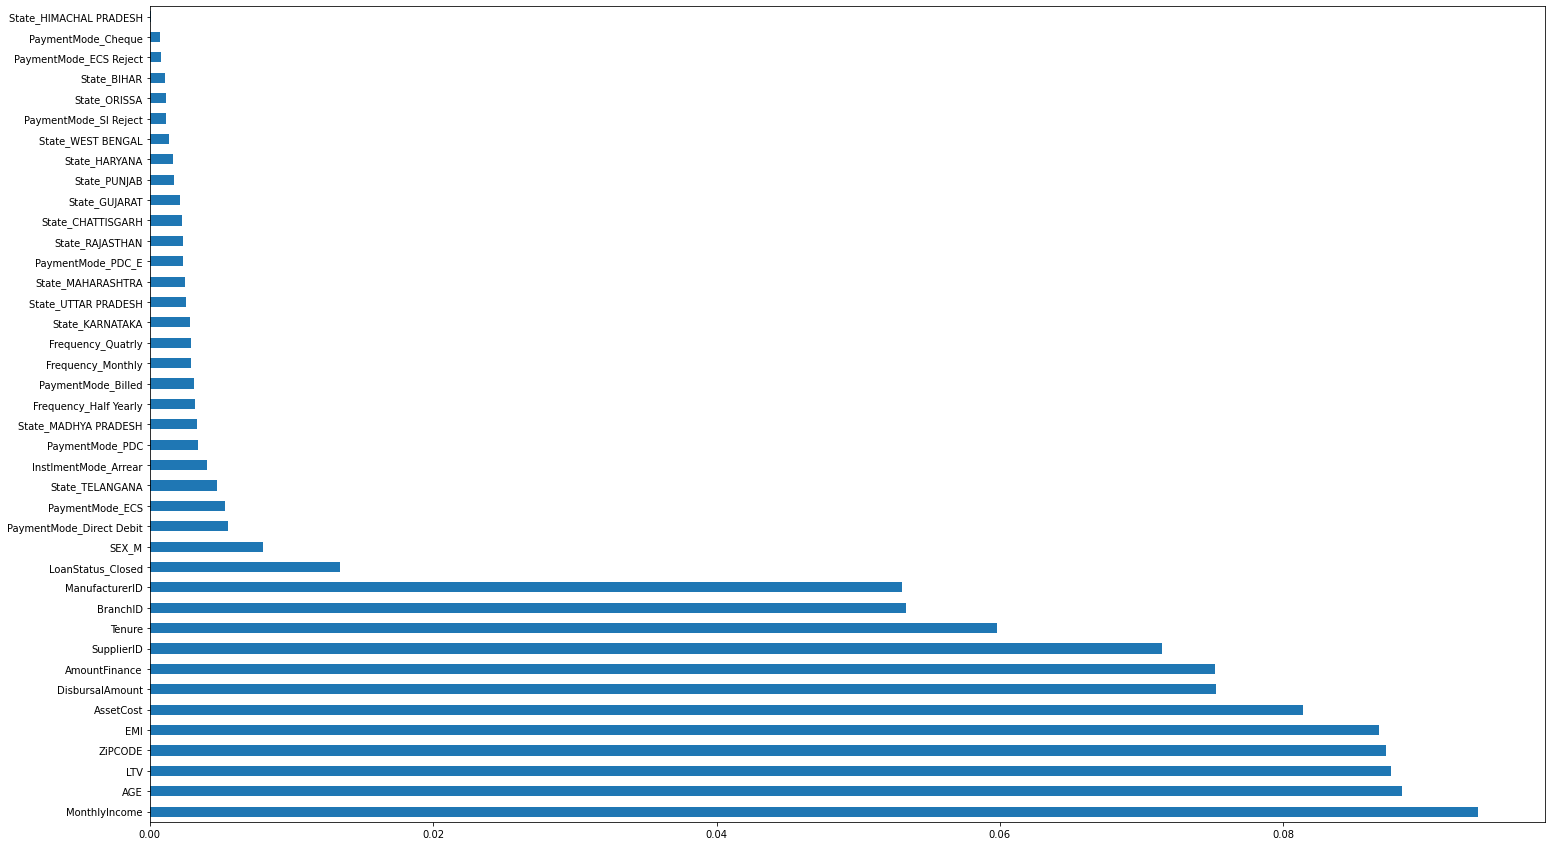

In [ ]:
feat_importances = pd.Series(model_feature_Selection.feature_importances_, index=dataset_only_independent.columns)
fig=plt.figure(figsize=[25,15])
feat_importances.nlargest(40).plot(kind='barh')
plt.show()

In [ ]:
imp_features_for_model = list(feat_importances.nlargest(40).index)
imp_features_for_model

['MonthlyIncome',
 'AGE',
 'LTV',
 'ZiPCODE',
 'EMI',
 'AssetCost',
 'DisbursalAmount',
 'AmountFinance',
 'SupplierID',
 'Tenure',
 'BranchID',
 'ManufacturerID',
 'LoanStatus_Closed',
 'SEX_M',
 'PaymentMode_Direct Debit',
 'PaymentMode_ECS',
 'State_TELANGANA',
 'InstlmentMode_Arrear',
 'PaymentMode_PDC',
 'State_MADHYA PRADESH',
 'Frequency_Half Yearly',
 'PaymentMode_Billed',
 'Frequency_Monthly',
 'Frequency_Quatrly',
 'State_KARNATAKA',
 'State_UTTAR PRADESH',
 'State_MAHARASHTRA',
 'PaymentMode_PDC_E',
 'State_RAJASTHAN',
 'State_CHATTISGARH',
 'State_GUJARAT',
 'State_PUNJAB',
 'State_HARYANA',
 'State_WEST BENGAL',
 'PaymentMode_SI Reject',
 'State_ORISSA',
 'State_BIHAR',
 'PaymentMode_ECS Reject',
 'PaymentMode_Cheque',
 'State_HIMACHAL PRADESH']

In [ ]:
train_new_imp_features = train_new[['top_up_class']+imp_features_for_model]
train_new_imp_features

top_up_class  MonthlyIncome  AGE    LTV  ZiPCODE      EMI  AssetCost  \
0                  1       35833.33   49  61.11   464993  24000.0     450000   
1                  0         666.67   23  70.00   466001  10500.0     485000   
2                  6       45257.00   39  69.77   462030  38300.0     690000   
3                  1       20833.33   24  80.92   473335  11600.0     480000   
4                  2       27313.67   56  71.05   495442  15000.0     619265   
...              ...            ...  ...    ...      ...      ...        ...   
128649             3       65333.33   25  40.17   131403  76800.0     470000   
128650             0       83333.33   25  59.92   131403  80100.0     460000   
128651             0      248500.00   36  52.38   131024  15277.0     545000   
128652             0       84500.00   37  50.37   131103  74341.0     350000   
128653             0      178166.67   33  54.17   131402  59200.0     370000   

        DisbursalAmount  AmountFinance  SupplierID  Tenure  BranchID  \
0              275000.0       275000.0       21946      48         1   
1              350000.0       350000.0       34802      47       333   
2              519728.0       519728.0      127335      68         1   
3              400000.0       400000.0       25094      48       125   
4              440000.0       440000.0       21853      44       152   
...                 ...            ...         ...     ...       ...   
128649         265601.0       265601.0       48879      24       424   
128650         275630.0       275630.0       48879      24       424   
128651         300733.0       300733.0       44118      23       424   
128652         250962.0       250962.0       48879      35       424   
128653         200428.0       200428.0       48879      24       424   

        ManufacturerID  LoanStatus_Closed  SEX_M  PaymentMode_Direct Debit  \
0                 1568                  1      1                         0   
1                 1062                  1      1                         0   
2                 1060                  0      1                         1   
3                 1060                  1      1                         0   
4                 1046                  1      1                         0   
...                ...                ...    ...                       ...   
128649            1568                  1      1                         1   
128650            1568                  1      1                         1   
128651            1568                  0      1                         1   
128652            1568                  0      1                         1   
128653            1568                  0      1                         1   

        PaymentMode_ECS  State_TELANGANA  InstlmentMode_Arrear  \
0                     0                0                     1   
1                     0                0                     0   
2                     0                0                     1   
3                     0                0                     0   
4                     0                0                     1   
...                 ...              ...                   ...   
128649                0                0                     1   
128650                0                0                     1   
128651                0                0                     1   
128652                0                0                     1   
128653                0                0                     1   

        PaymentMode_PDC  State_MADHYA PRADESH  Frequency_Half Yearly  \
0                     0                     1                      0   
1                     1                     1                      0   
2                     0                     1                      0   
3                     0                     1                      0   
4                     0                     0                      0   
...                 

In [ ]:
test_new_imp_features = test_new[imp_features_for_model]
test_new_imp_features

MonthlyIncome  AGE    LTV  ZiPCODE      EMI  AssetCost  \
0           32069.00   50  75.83   473001   1000.0     480000   
1           25000.00   35  57.44   473001   9300.0     480000   
2           23333.33   37  68.97   473001  35800.0     580000   
3           91666.67   55  61.79   493558  52000.0     725000   
4           12500.00   48  59.09   754137  35400.0     617000   
...              ...  ...    ...      ...      ...        ...   
14740       33333.33   39  79.17   122001  14723.0     530016   
14741       33333.33   39  75.04   560020  15491.0     595000   
14742       33333.33   39  75.04   560020  15491.0     595000   
14743       33333.33   39  70.00   335001  25350.0     400000   
14744       33333.33   39  70.00   335001  25350.0     400000   

       DisbursalAmount  AmountFinance  SupplierID  Tenure  BranchID  \
0             365000.0       365000.0       22354      46         2   
1             285000.0       285000.0       22354      45         2   
2             400000.0       400000.0       65929      48         2   
3             500000.0       500000.0       68597      36       154   
4             400000.0       400000.0       38493      48       194   
...                ...            ...         ...     ...       ...   
14740         419616.0       419616.0       22094      35       143   
14741         446500.0       446500.0       61196      36        32   
14742         446500.0       446500.0       61196      36        32   
14743         280000.0       280000.0       63565      12       246   
14744         280000.0       280000.0       63565      12       246   

       ManufacturerID  LoanStatus_Closed  SEX_M  PaymentMode_Direct Debit  \
0                1046                  1      1                         0   
1                1046                  1      1                         0   
2                1060                  1      1                         0   
3                1049                  1      1                         0   
4                1049                  1      1                         0   
...               ...                ...    ...                       ...   
14740            1046                  1      1                         0   
14741            2721                  1      1                         0   
14742            2721                  1      1                         0   
14743            1046                  1      1                         0   
14744            1046                  1      1                         0   

       PaymentMode_ECS  State_TELANGANA  InstlmentMode_Arrear  \
0                    0                0                     0   
1                    0                0                     0   
2                    0                0                     1   
3                    0                0                     1   
4                    0                0                     1   
...                ...              ...                   ...   
14740                0                0                     1   
14741                0                0                     1   
14742                0                0                     1   
14743                0                0                     1   
14744                0                0                     1   

       PaymentMode_PDC  State_MADHYA PRADESH  Frequency_Half Yearly  \
0                    0                     1                      0   
1                    1                     1                      0   
2                    1                     1                      0   
3                    0                     0                      1   
4                    1                     0                      0   
...                ...                   ...                    ...   
14740                1                     0                      0   
14741                1                     0                      0   
14742                1      

In [ ]:
y = train_new_imp_features['top_up_class']
X = train_new_imp_features.drop('top_up_class',axis=1)
print(X.shape,y.shape)

(128654, 40) (128654,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(102923, 40) (25731, 40) (102923,) (25731,)


In [ ]:
sc = StandardScaler()
X_train_st = sc.fit_transform(X_train)
X_test_st = sc.transform(X_test)
test_new_st = sc.transform(test_new_imp_features)

In [ ]:
estimators_st = {
    'Logistic Regression': [LogisticRegression()],
    'KNN' :[KNeighborsClassifier()],
    'Decision Tree' :[DecisionTreeClassifier()],
    'Random Forest' :[RandomForestClassifier()],
    'Gradient Boosting':[GradientBoostingClassifier()],
    'XG Boost': [XGBClassifier()],
    'LGBM':[LGBMClassifier()],
    'Cat Boost':[CatBoostClassifier(verbose=0, n_estimators=1000)],
}

#writing a function to fit models above to the train dataset
def mfit(estimators_st, X_train, y_train):
    for m in estimators_st:
        estimators_st[m][0].fit(X_train, y_train)
        print(m+' fitted')

mfit(estimators_st, X_train_st, y_train)

def mpredict(estimators_st, X_test_st, y_test):
    outcome = dict()
    for m in estimators_st:
        y_pred = estimators_st[m][0].predict(X_test_st)
        outcome[m] = [metrics.f1_score(y_test,y_pred,average='macro'),
                      metrics.accuracy_score(y_test,y_pred),
                      metrics.classification_report(y_test,y_pred)]
    return outcome


outcome_st = mpredict(estimators_st, X_test_st, y_test)

for m in outcome_st:
    print('------------------------'+m+'------------------------')
    print('F1 Score', round(outcome_st[m][0],4))
    print('Accuracy Score', round(outcome_st[m][1],4))
    print('Classification report \n ')
    print(outcome_st[m][2])
    print('\n')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression fitted
KNN fitted
Decision Tree fitted
Random Forest fitted
Gradient Boosting fitted
XG Boost fitted
LGBM fitted
Cat Boost fitted


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------------------------Logistic Regression------------------------
F1 Score 0.1303
Accuracy Score 0.8269
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     21279
           1       0.00      0.00      0.00      1642
           2       0.00      0.00      0.00       761
           3       0.00      0.00      0.00       683
           4       1.00      0.00      0.00       663
           5       0.17      0.00      0.00       502
           6       0.00      0.00      0.00       201

    accuracy                           0.83     25731
   macro avg       0.28      0.14      0.13     25731
weighted avg       0.71      0.83      0.75     25731



------------------------KNN------------------------
F1 Score 0.1515
Accuracy Score 0.815
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     21279
           1       0.19      0.03      0.05    

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=30)
knn = KNeighborsClassifier(n_neighbors=1 , weights ='distance' ,metric='minkowski')
rf=RandomForestClassifier(max_depth=30,max_features='auto',min_samples_leaf=5,min_samples_split=15,n_estimators=100)

Ens = VotingClassifier( 
    estimators= [('DecisionTreeClassifier',dt),('KNeighborsClassifier',knn),('RandomForestClassifier',rf)],voting='soft')

## Training the Ensemble learning:
Ens= Ens.fit(X_train_st , y_train)

y_pred = Ens.predict(X_test_st)
print('------------------------COMBINED MODEL------------------------')
print('F1 Score', metrics.f1_score(y_test,y_pred,average='macro'))
print('Accuracy Score', metrics.accuracy_score(y_test,y_pred))
print('Classification report \n ')
print(metrics.classification_report(y_test,y_pred))
print('\n')

------------------------COMBINED MODEL------------------------
F1 Score 0.17825096915677638
Accuracy Score 0.8000854999805682
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     21279
           1       0.17      0.05      0.08      1642
           2       0.13      0.03      0.05       761
           3       0.15      0.05      0.08       683
           4       0.12      0.03      0.05       663
           5       0.17      0.05      0.07       502
           6       0.10      0.01      0.03       201

    accuracy                           0.80     25731
   macro avg       0.24      0.17      0.18     25731
weighted avg       0.72      0.80      0.75     25731





In [ ]:
y_train_encc = tf.keras.utils.to_categorical(y_train, 7)
y_test_encc = tf.keras.utils.to_categorical(y_test, 7)

print(y_train_encc.shape,y_test_encc.shape)


(102923, 7) (25731, 7)


In [ ]:

# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 50, kernel_initializer = 'he_uniform',activation='relu',input_dim = 40))

# Adding the second hidden layer
classifier.add(Dense(units = 25, kernel_initializer = 'he_uniform',activation='relu'))

# Adding the third hidden layer
classifier.add(Dense(units = 50, kernel_initializer = 'he_uniform',activation='relu'))
# Adding the output layer
classifier.add(Dense(units = 7, kernel_initializer = 'he_uniform',activation='softmax'))

# Compiling the ANN
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 50)                2050      
_________________________________________________________________
dense_41 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_42 (Dense)             (None, 50)                1300      
_________________________________________________________________
dense_43 (Dense)             (None, 7)                 357       
Total params: 4,982
Trainable params: 4,982
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fitting the ANN to the Training set
model_history=classifier.fit(X_train_st, y_train_encc,validation_split=0.20, batch_size = 10, epochs = 100)

Epoch 1/100
8234/8234 [==============================] - 22s 3ms/step - loss: 0.7131 - accuracy: 0.8209 - val_loss: 0.6358 - val_accuracy: 0.8344
Epoch 2/100
8234/8234 [==============================] - 22s 3ms/step - loss: 0.6548 - accuracy: 0.8263 - val_loss: 0.6324 - val_accuracy: 0.8344
Epoch 3/100
8234/8234 [==============================] - 22s 3ms/step - loss: 0.6451 - accuracy: 0.8283 - val_loss: 0.6308 - val_accuracy: 0.8344
Epoch 4/100
8234/8234 [==============================] - 22s 3ms/step - loss: 0.6405 - accuracy: 0.8283 - val_loss: 0.6272 - val_accuracy: 0.8344
Epoch 5/100
8234/8234 [==============================] - 22s 3ms/step - loss: 0.6360 - accuracy: 0.8289 - val_loss: 0.6296 - val_accuracy: 0.8345
Epoch 6/100
8234/8234 [==============================] - 22s 3ms/step - loss: 0.6317 - accuracy: 0.8293 - val_loss: 0.6288 - val_accuracy: 0.8344
Epoch 7/100
8234/8234 [==============================] - 22s 3ms/step - loss: 0.6347 - accuracy: 0.8285 - val_loss: 0.6277 -

In [ ]:
y_pred = classifier.predict(X_test_st)

In [ ]:
y_pred_final = np.argmax(y_pred,axis=1)

In [ ]:
print('------------------------ANN MODEL------------------------')
print('F1 Score', metrics.f1_score(y_test,y_pred_final,average='macro'))
print('Accuracy Score', metrics.accuracy_score(y_test,y_pred_final))
print('Classification report \n ')
print(metrics.classification_report(y_test,y_pred_final))
print('\n')

------------------------ANN MODEL------------------------
F1 Score 0.13047288952834993
Accuracy Score 0.8262795849364579
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      1.00      0.90     21279
           1       0.29      0.00      0.01      1642
           2       0.00      0.00      0.00       761
           3       0.00      0.00      0.00       683
           4       0.00      0.00      0.00       663
           5       0.00      0.00      0.00       502
           6       0.00      0.00      0.00       201

    accuracy                           0.83     25731
   macro avg       0.16      0.14      0.13     25731
weighted avg       0.70      0.83      0.75     25731





/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_knn_final_submit = KNeighborsClassifier(n_neighbors=1 , weights ='distance' ,metric='minkowski')
model_knn_final_submit = model_knn_final_submit.fit(X_st,y)

y_pred = model_knn_final_submit.predict(test_final_st)
y_pred

array([0, 0, 2, ..., 0, 0, 0])

In [ ]:
top_up_class_label_dict = {
    0:'No Top-up Service',
    1:' > 48 Months',
    2:'36-48 Months',
    3:'24-30 Months',
    4:'30-36 Months',
    5:'18-24 Months',
    6:'12-18 Months'
}
submission_df = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_Data.xlsx')
submission_df['Pred'] = list(y_pred)
sub = submission_df[['ID','Pred']]
sub.columns = ['ID','Top-up Month']
sub['Top-up Month_Final'] = sub['Top-up Month'].map(top_up_class_label_dict)
sub = sub.drop('Top-up Month',axis=1)
sub.columns = ['ID','Top-up Month']
sub['Top-up Month'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


No Top-up Service    12262
 > 48 Months          1026
36-48 Months           418
30-36 Months           394
24-30 Months           339
18-24 Months           217
12-18 Months            89
Name: Top-up Month, dtype: int64

In [ ]:
sub.to_csv('submit_knn_updated.csv',index=False)

GOT 0.14 Score on Leader board by submitting above File

#### Selecting Most IMP Features and Mean Encoding Cateogrical Features

In [ ]:
test_data = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_Data.xlsx')
test_data = test_data.drop(['ID','AssetID','Area','City','DisbursalDate','MaturityDAte','AuthDate','DisbursalAmount', 'LTV'],axis=1)

In [ ]:
train_data = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/train_data_missing_values_handled.xlsx')
train_data = train_data.drop(['DisbursalDate','MaturityDAte','AuthDate','DisbursalAmount', 'LTV'],axis=1)

In [ ]:
groupby_state_zipcode= train_data.groupby('State')['ZiPCODE'].agg(lambda x:x.value_counts().index[0])
def impute_zipcode(cols):
  zipcode = cols[0]
  state = cols[1]
  if pd.isnull(zipcode):
    return groupby_state_zipcode[state]
  else:
    return zipcode

In [ ]:
test_data['AGE'] =test_data['AGE'].fillna(train_data['AGE'].median())
test_data['MonthlyIncome'] =test_data['MonthlyIncome'].fillna(train_data['MonthlyIncome'].median())
test_data['ManufacturerID'] = test_data['ManufacturerID'].fillna(train_data['ManufacturerID'].mode()[0])
test_data['SEX'] = test_data['SEX'].fillna(train_data['SEX'].value_counts().index[0])
test_data['ZiPCODE'] = test_data[['ZiPCODE','State']].apply(impute_zipcode,axis=1)

In [ ]:
train_data.to_excel('train_missing_values_handled_feat_mean_enc.xlsx')
test_data.to_excel('test_missing_values_handled_feat_mean_enc.xlsx')

#### Mean Encoding

#### Combining Train and Test data for Mean Encoding 

In [ ]:
final_df = pd.concat([train_data,test_data],axis=0)
final_df.shape

(143399, 17)

In [ ]:
final_df.index = range(0,len(final_df))

In [ ]:
mean_encoding_state = train_data.groupby(['State'])['top_up_class'].mean().to_dict()
final_df['State'] = final_df['State'].map(mean_encoding_state)

In [ ]:
mean_enc_payment = train_data.groupby(['PaymentMode'])['top_up_class'].mean().to_dict()
final_df['PaymentMode'] = final_df['PaymentMode'].map(mean_enc_payment)

In [ ]:
final_df = pd.get_dummies(final_df,drop_first=True)

In [ ]:
train_data_final = final_df.iloc[:128654,:]
test_data_final = final_df.iloc[128654:,:]
train_data_final['top_up_class'] = train_data_final['top_up_class'].astype(int)
test_data_final.index = range(0,len(test_data_final))
test_data_final = test_data_final.drop('top_up_class',axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
y = train_data_final['top_up_class']
X = train_data_final.drop('top_up_class',axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(102923, 18) (25731, 18) (102923,) (25731,)


In [ ]:
sc = StandardScaler()
X_train_st = sc.fit_transform(X_train)
X_test_st = sc.transform(X_test)
test_final_st = sc.transform(test_data_final)

In [ ]:
estimators_st = {
    'Logistic Regression': [LogisticRegression()],
    'KNN' :[KNeighborsClassifier()],
    'Decision Tree' :[DecisionTreeClassifier()],
    'Random Forest' :[RandomForestClassifier()],
    'Gradient Boosting':[GradientBoostingClassifier()],
    'XG Boost': [XGBClassifier()],
    'LGBM':[LGBMClassifier()],
    'Cat Boost':[CatBoostClassifier(verbose=0, n_estimators=100)],
}

#writing a function to fit models above to the train dataset
def mfit(estimators_st, X_train, y_train):
    for m in estimators_st:
        estimators_st[m][0].fit(X_train, y_train)
        print(m+' fitted')

mfit(estimators_st, X_train_st, y_train)

def mpredict(estimators_st, X_test_st, y_test):
    outcome = dict()
    for m in estimators_st:
        y_pred = estimators_st[m][0].predict(X_test_st)
        outcome[m] = [metrics.f1_score(y_test,y_pred,average='macro'),
                      metrics.accuracy_score(y_test,y_pred),
                      metrics.classification_report(y_test,y_pred)]
    return outcome


outcome_st = mpredict(estimators_st, X_test_st, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression fitted
KNN fitted
Decision Tree fitted
Random Forest fitted
Gradient Boosting fitted
XG Boost fitted
LGBM fitted
Cat Boost fitted


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for m in outcome_st:
    print('------------------------'+m+'------------------------')
    print('F1 Score', round(outcome_st[m][0],4))
    print('Accuracy Score', round(outcome_st[m][1],4))
    print('Classification report \n ')
    print(outcome_st[m][2])
    print('\n')

------------------------Logistic Regression------------------------
F1 Score 0.1303
Accuracy Score 0.8269
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     21279
           1       0.00      0.00      0.00      1642
           2       0.00      0.00      0.00       761
           3       0.00      0.00      0.00       683
           4       1.00      0.00      0.00       663
           5       0.20      0.00      0.00       502
           6       0.00      0.00      0.00       201

    accuracy                           0.83     25731
   macro avg       0.29      0.14      0.13     25731
weighted avg       0.71      0.83      0.75     25731



------------------------KNN------------------------
F1 Score 0.1505
Accuracy Score 0.8156
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     21279
           1       0.15      0.02      0.04   

In [ ]:
test_data_final.to_excel('test_final_mean_encoded_final_less_feat.xlsx')
train_data_final.to_excel('train_final_mean_encoded_final_less_feat.xlsx')

### Preprocessing of Bureau Data

In [ ]:
train_data = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/train_final_mean_encoded_final_less_feat.xlsx')
train_data = train_data.iloc[:,1:]

In [ ]:
train_data_og = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/train_Data.xlsx')
train_data_og.shape

(128655, 26)

In [ ]:
train_data_og.iloc[53390:53395,:]

In [ ]:
## Drop row where Maturity date is null
train_data_og = train_data_og.drop(53392)
train_data_og.iloc[53390:53395,:]

In [ ]:
train_data_og.index = range(0,len(train_data_og))
train_data_og.shape

(128654, 26)

In [ ]:
train_data['ID'] = list(train_data_og['ID'])
train_data.head()

In [ ]:
bur_data= pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/train_bureau.xlsx')
bur_data.head()

ID  SELF-INDICATOR MATCH-TYPE             ACCT-TYPE CONTRIBUTOR-TYPE  \
0   1           False    PRIMARY             Overdraft              NAB   
1   1           False    PRIMARY  Auto Loan (Personal)              NAB   
2   1            True    PRIMARY          Tractor Loan              NBF   
3   1            True    PRIMARY  Auto Loan (Personal)              NBF   
4   1            True    PRIMARY          Tractor Loan              NBF   

  DATE-REPORTED OWNERSHIP-IND ACCOUNT-STATUS DISBURSED-DT  \
0    2018-04-30    Individual     Delinquent   2015-10-05   
1    2019-12-31    Individual         Active   2018-03-19   
2    2020-01-31    Individual         Active   2019-08-30   
3    2017-09-30    Individual         Closed   2013-09-27   
4    2016-02-29    Individual         Closed   2012-02-10   

              CLOSE-DT LAST-PAYMENT-DATE CREDIT-LIMIT/SANC AMT  \
0                  NaN        2018-02-27                   NaN   
1                  NaN        2019-12-19                   NaN   
2                  NaN               NaT                   NaN   
3  2017-09-21 00:00:00               NaT                   NaN   
4  2016-02-01 00:00:00               NaT                   NaN   

  DISBURSED-AMT/HIGH CREDIT INSTALLMENT-AMT CURRENT-BAL INSTALLMENT-FREQUENCY  \
0                    37,352             NaN      37,873                   NaN   
1                    44,000   1,405/Monthly      20,797                   F03   
2                  1,45,000             NaN    1,16,087                   NaN   
3                  3,00,000             NaN           0                   NaN   
4                  2,75,000             NaN           0                   NaN   

  OVERDUE-AMT  WRITE-OFF-AMT ASSET_CLASS  \
0      37,873            0.0    Standard   
1         NaN            0.0    Standard   
2           0            0.0         NaN   
3           0            0.0         NaN   
4           0            0.0         NaN   

                                REPORTED DATE - HIST  \
0                                 20180430,20180331,   
1  20191231,20191130,20191031,20190930,20190831,2...   
2  20200131,20191231,20191130,20191031,20190930,2...   
3  20170930,20170801,20170731,20170630,20170531,2...   
4  20160229,20160131,20151231,20151130,20151031,2...   

                                          DPD - HIST  \
0                                             030000   
1  0000000000000000000000000000000000000000000000...   
2                                 000000000000000000   
3  000DDD0270260270260270240270270000320000000000...   
4  0000000000000000000000000000000000000000000000...   

                                      CUR BAL - HIST  \
0                                       37873,12820,   
1  20797,21988,23174,24341,25504,26648,27780,2891...   
2         116087,116087,145000,145000,145000,145000,   
3  0,,15925,23754,31494,39147,46713,54194,61590,6...   
4  0,0,23658,23321,22989,46321,45662,45012,68030,...   

                                  AMT OVERDUE - HIST  \
0                                            37873,,   
1                         ,,,,,,,,,,,,,,,,,,,,1452,,   
2                                       0,0,0,0,0,0,   
3  0,,1014,1014,1014,1014,1014,1014,1014,983,0,92...   
4  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   

                         AMT PAID - HIST  TENURE  
0                                     ,,     NaN  
1                 ,,,,,,,,,,,,,,,,,,,,,,    36.0  
2                                 ,,,,,,     NaN  
3  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,     NaN  
4  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,     NaN

In [ ]:
bur_data.shape

(560844, 25)

In [ ]:
len(bur_data['ID'].unique())

128655

In [ ]:
bur_data[bur_data['ID']==57606].index

Int64Index([267728, 267729], dtype='int64')

In [ ]:
bur_data = bur_data.drop(bur_data[bur_data['ID']==57606].index)
bur_data.shape

(560842, 25)

In [ ]:
bur_data.index = range(0,len(bur_data))

### Now we will add Features one by one

Before Adding we will handle missing values 

In [ ]:
bur_data['CURRENT-BAL'] = bur_data['CURRENT-BAL'].fillna('0')
bur_data['INSTALLMENT-AMT'] = bur_data['INSTALLMENT-AMT'].fillna('0')
bur_data['OVERDUE-AMT'] = bur_data['OVERDUE-AMT'].fillna('0')
bur_data['WRITE-OFF-AMT'] = bur_data['WRITE-OFF-AMT'].fillna(0)
bur_data['TENURE'] = bur_data['TENURE'].fillna(0)
bur_data.dtypes

In [ ]:
bur_data['INSTALLMENT-AMT'] = bur_data['INSTALLMENT-AMT'].str.replace(',', '')

In [ ]:
bur_data['INSTALLMENT-AMT'] = bur_data['INSTALLMENT-AMT'].str.extract('(\d+)')

In [ ]:
bur_data['DISBURSED-AMT/HIGH CREDIT'] = bur_data['DISBURSED-AMT/HIGH CREDIT'].str.replace(',', '')
bur_data['CURRENT-BAL'] = bur_data['CURRENT-BAL'].str.replace(',', '')
bur_data['OVERDUE-AMT'] = bur_data['OVERDUE-AMT'].str.replace(',', '')

In [ ]:
bur_data['DISBURSED-AMT/HIGH CREDIT'] = bur_data['DISBURSED-AMT/HIGH CREDIT'].astype(int)
bur_data['CURRENT-BAL'] = bur_data['CURRENT-BAL'].astype(int)
bur_data['OVERDUE-AMT'] = bur_data['OVERDUE-AMT'].astype(int)
bur_data['INSTALLMENT-AMT'] = bur_data['INSTALLMENT-AMT'].astype(int)
bur_data.dtypes

In [ ]:
bur_data_groupby = bur_data.groupby('ID')
bur_data_groupby

In [ ]:
def extract_median_values(bur_data_groupby,features,train_data):
  for feature in features:
    feat_median = bur_data_groupby[feature].median()
    d=feat_median.to_frame().reset_index()
    d.columns = ['ID','{}_Median'.format(feature)]
    train_data = pd.merge(train_data,d,on='ID')
  return train_data

train_data_bur = extract_median_values(bur_data_groupby,['DISBURSED-AMT/HIGH CREDIT','INSTALLMENT-AMT','CURRENT-BAL','OVERDUE-AMT','WRITE-OFF-AMT','TENURE'],train_data)

In [ ]:
train_data_bur

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0          0.186877         1      48     450000       275000.0  24000.0   
1          0.255776       333      47     485000       350000.0  10500.0   
2          0.668451         1      68     690000       519728.0  38300.0   
3          0.168888       125      48     480000       400000.0  11600.0   
4          0.168888       152      44     619265       440000.0  15000.0   
...             ...       ...     ...        ...            ...      ...   
128649     0.668451       424      24     470000       265601.0  76800.0   
128650     0.668451       424      24     460000       275630.0  80100.0   
128651     0.668451       424      23     545000       300733.0  15277.0   
128652     0.668451       424      35     350000       250962.0  74341.0   
128653     0.668451       424      24     370000       200428.0  59200.0   

        ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0                 1568       21946   49       35833.33  0.425187   464993   
1                 1062       34802   23         666.67  0.425187   466001   
2                 1060      127335   39       45257.00  0.425187   462030   
3                 1060       25094   24       20833.33  0.425187   473335   
4                 1046       21853   56       27313.67  0.269824   495442   
...                ...         ...  ...            ...       ...      ...   
128649            1568       48879   25       65333.33  0.533554   131403   
128650            1568       48879   25       83333.33  0.533554   131403   
128651            1568       44118   36      248500.00  0.533554   131024   
128652            1568       48879   37       84500.00  0.533554   131103   
128653            1568       48879   33      178166.67  0.533554   131402   

        top_up_class  Frequency_Half Yearly  Frequency_Monthly  \
0                  1                      0                  1   
1                  0                      0                  1   
2                  6                      0                  0   
3                  1                      0                  1   
4                  2                      0                  1   
...              ...                    ...                ...   
128649             3                      1                  0   
128650             0                      1                  0   
128651             0                      0                  1   
128652             0                      1                  0   
128653             0                      1                  0   

        Frequency_Quatrly  InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  \
0                       0                     1                  1      1   
1                       0                     0                  1      1   
2                       1                     1                  0      1   
3                       0                     0                  1      1   
4                       0                     1                  1      1   
...                   ...                   ...                ...    ...   
128649                  0                     1                  1      1   
128650                  0                     1                  1      1   
128651                  0                     1                  0      1   
128652                  0                     1                  0      1   
128653                  0                     1                  0      1   

            ID  DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0            1                          275000.0                     0.0   
1            2                          700000.0                     0.0   
2            3                           44000.0                     0.0   
3            7                          315000.0                     0.0   
4            8                          200000.0                     0.0

### Model Training on Train BUR Dataset

In [ ]:
train_data_bur.head(5)

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   
2     0.668451         1      68     690000       519728.0  38300.0   
3     0.168888       125      48     480000       400000.0  11600.0   
4     0.168888       152      44     619265       440000.0  15000.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   
2            1060      127335   39       45257.00  0.425187   462030   
3            1060       25094   24       20833.33  0.425187   473335   
4            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0             1                      0                  1                  0   
1             0                      0                  1                  0   
2             6                      0                  0                  1   
3             1                      0                  1                  0   
4             2                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          275000.0                     0.0   
1                          700000.0                     0.0   
2                           44000.0                     0.0   
3                          315000.0                     0.0   
4                          200000.0                     0.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  TENURE_Median  
0                 0.0                 0.0                   0.0            0.0  
1             52421.0                 0.0                   0.0           35.0  
2                 0.0                 0.0                   0.0            0.0  
3                 0.0                 0.0                   0.0            5.0  
4              6989.0                 0.0                   0.0           42.0

In [ ]:
train_data_bur = train_data_bur.drop('ID',axis=1)
train_data_bur

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0          0.186877         1      48     450000       275000.0  24000.0   
1          0.255776       333      47     485000       350000.0  10500.0   
2          0.668451         1      68     690000       519728.0  38300.0   
3          0.168888       125      48     480000       400000.0  11600.0   
4          0.168888       152      44     619265       440000.0  15000.0   
...             ...       ...     ...        ...            ...      ...   
128649     0.668451       424      24     470000       265601.0  76800.0   
128650     0.668451       424      24     460000       275630.0  80100.0   
128651     0.668451       424      23     545000       300733.0  15277.0   
128652     0.668451       424      35     350000       250962.0  74341.0   
128653     0.668451       424      24     370000       200428.0  59200.0   

        ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0                 1568       21946   49       35833.33  0.425187   464993   
1                 1062       34802   23         666.67  0.425187   466001   
2                 1060      127335   39       45257.00  0.425187   462030   
3                 1060       25094   24       20833.33  0.425187   473335   
4                 1046       21853   56       27313.67  0.269824   495442   
...                ...         ...  ...            ...       ...      ...   
128649            1568       48879   25       65333.33  0.533554   131403   
128650            1568       48879   25       83333.33  0.533554   131403   
128651            1568       44118   36      248500.00  0.533554   131024   
128652            1568       48879   37       84500.00  0.533554   131103   
128653            1568       48879   33      178166.67  0.533554   131402   

        top_up_class  Frequency_Half Yearly  Frequency_Monthly  \
0                  1                      0                  1   
1                  0                      0                  1   
2                  6                      0                  0   
3                  1                      0                  1   
4                  2                      0                  1   
...              ...                    ...                ...   
128649             3                      1                  0   
128650             0                      1                  0   
128651             0                      0                  1   
128652             0                      1                  0   
128653             0                      1                  0   

        Frequency_Quatrly  InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  \
0                       0                     1                  1      1   
1                       0                     0                  1      1   
2                       1                     1                  0      1   
3                       0                     0                  1      1   
4                       0                     1                  1      1   
...                   ...                   ...                ...    ...   
128649                  0                     1                  1      1   
128650                  0                     1                  1      1   
128651                  0                     1                  0      1   
128652                  0                     1                  0      1   
128653                  0                     1                  0      1   

        DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                               275000.0                     0.0   
1                               700000.0                     0.0   
2                                44000.0                     0.0   
3                               315000.0                     0.0   
4                               200000.0                     0.0   
...                                  ...    

In [ ]:
y = train_data_bur['top_up_class']
X = train_data_bur.drop('top_up_class',axis=1)
X.head()

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   
2     0.668451         1      68     690000       519728.0  38300.0   
3     0.168888       125      48     480000       400000.0  11600.0   
4     0.168888       152      44     619265       440000.0  15000.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   
2            1060      127335   39       45257.00  0.425187   462030   
3            1060       25094   24       20833.33  0.425187   473335   
4            1046       21853   56       27313.67  0.269824   495442   

   Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0                      0                  1                  0   
1                      0                  1                  0   
2                      0                  0                  1   
3                      0                  1                  0   
4                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  \
0                     1                  1      1   
1                     0                  1      1   
2                     1                  0      1   
3                     0                  1      1   
4                     1                  1      1   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          275000.0                     0.0   
1                          700000.0                     0.0   
2                           44000.0                     0.0   
3                          315000.0                     0.0   
4                          200000.0                     0.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  TENURE_Median  
0                 0.0                 0.0                   0.0            0.0  
1             52421.0                 0.0                   0.0           35.0  
2                 0.0                 0.0                   0.0            0.0  
3                 0.0                 0.0                   0.0            5.0  
4              6989.0                 0.0                   0.0           42.0

In [ ]:
X.shape,y.shape

((128654, 24), (128654,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(102923, 24) (25731, 24) (102923,) (25731,)


In [ ]:
sc = StandardScaler()
X_train_st = sc.fit_transform(X_train)
X_test_st = sc.transform(X_test)

In [ ]:
estimators_st = {
    'Logistic Regression': [LogisticRegression()],
    'KNN' :[KNeighborsClassifier()],
    'Decision Tree' :[DecisionTreeClassifier()],
    'Random Forest' :[RandomForestClassifier()],
    'Gradient Boosting':[GradientBoostingClassifier()],
    'XG Boost': [XGBClassifier()],
    'LGBM':[LGBMClassifier()],
    'Cat Boost':[CatBoostClassifier(verbose=0, n_estimators=100)],
}

#writing a function to fit models above to the train dataset
def mfit(estimators_st, X_train, y_train):
    for m in estimators_st:
        estimators_st[m][0].fit(X_train, y_train)
        print(m+' fitted')

mfit(estimators_st, X_train_st, y_train)

def mpredict(estimators_st, X_test_st, y_test):
    outcome = dict()
    for m in estimators_st:
        y_pred = estimators_st[m][0].predict(X_test_st)
        outcome[m] = [metrics.f1_score(y_test,y_pred,average='macro'),
                      metrics.accuracy_score(y_test,y_pred),
                      metrics.classification_report(y_test,y_pred)]
    return outcome


outcome_st = mpredict(estimators_st, X_test_st, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression fitted
KNN fitted
Decision Tree fitted
Random Forest fitted
Gradient Boosting fitted
XG Boost fitted
LGBM fitted
Cat Boost fitted


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for m in outcome_st:
    print('------------------------'+m+'------------------------')
    print('F1 Score', round(outcome_st[m][0],4))
    print('Accuracy Score', round(outcome_st[m][1],4))
    print('Classification report \n ')
    print(outcome_st[m][2])
    print('\n')

------------------------Logistic Regression------------------------
F1 Score 0.1328
Accuracy Score 0.8267
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     21279
           1       0.48      0.01      0.01      1642
           2       0.00      0.00      0.00       761
           3       0.10      0.00      0.00       683
           4       1.00      0.00      0.00       663
           5       0.12      0.00      0.00       502
           6       0.00      0.00      0.00       201

    accuracy                           0.83     25731
   macro avg       0.36      0.14      0.13     25731
weighted avg       0.75      0.83      0.75     25731



------------------------KNN------------------------
F1 Score 0.1624
Accuracy Score 0.818
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     21279
           1       0.32      0.07      0.11    

### RF

In [ ]:
X_train.shape

(102923, 24)

In [ ]:
#Randomized Search CV

model_rf = RandomForestClassifier()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = model_rf, param_distributions = random_grid,scoring=f1, n_iter = 10, cv = 5, verbose=2, random_state=1, n_jobs = 1)

rf_random.fit(X_st,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=600, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=15 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=600, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=15, total= 1.5min
[CV] n_estimators=600, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=15 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


[CV]  n_estimators=600, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=15, total= 1.5min
[CV] n_estimators=600, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=15 
[CV]  n_estimators=600, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=15, total= 1.6min
[CV] n_estimators=600, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=15 
[CV]  n_estimators=600, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=15, total= 1.5min
[CV] n_estimators=600, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=15 
[CV]  n_estimators=600, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=15, total= 1.5min
[CV] n_estimators=800, min_samples_split=100, min_samples_leaf=10, max_features=auto, max_depth=5 
[CV]  n_estimators=800, min_samples_split=100, min_samples_leaf=10, max_features=auto, max_depth=5, total=  53.5s
[CV] n_estimators=800, min_samples_split=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 41.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_random.best_params_

{'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 15,
 'n_estimators': 100}

In [ ]:
model_rf_final = RandomForestClassifier(max_depth=30,max_features='auto',min_samples_leaf=5,min_samples_split=15,n_estimators=100)
model_rf_final = model_rf_final.fit(X_train_st,y_train)

y_pred = model_rf_final.predict(X_test_st)
print('------------------------RF MODEL------------------------')
print('F1 Score', metrics.f1_score(y_test,y_pred,average='macro'))
print('Accuracy Score', metrics.accuracy_score(y_test,y_pred))
print('Classification report \n ')
print(metrics.classification_report(y_test,y_pred))
print('\n')

------------------------RF MODEL------------------------
F1 Score 0.13982377737525178
Accuracy Score 0.8285725389607866
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     21279
           1       0.66      0.04      0.07      1642
           2       0.00      0.00      0.00       761
           3       0.00      0.00      0.00       683
           4       0.00      0.00      0.00       663
           5       0.00      0.00      0.00       502
           6       0.00      0.00      0.00       201

    accuracy                           0.83     25731
   macro avg       0.21      0.15      0.14     25731
weighted avg       0.73      0.83      0.75     25731





/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
test_data = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_final_mean_encoded_final_less_feat.xlsx')
test_data = test_data.iloc[:,1:]
print(test_data.shape)

(14745, 18)


In [ ]:
test_data_og = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_Data.xlsx')
test_data_og.shape

(14745, 25)

In [ ]:
test_data['ID'] = list(test_data_og['ID'])

In [ ]:
bur_data= pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_bureau.xlsx')
bur_data.head()

ID  SELF-INDICATOR MATCH-TYPE      ACCT-TYPE CONTRIBUTOR-TYPE  \
0   4           False    PRIMARY    Credit Card              CCC   
1   4           False    PRIMARY   Housing Loan              HFC   
2   4           False    PRIMARY  Property Loan              HFC   
3   4            True    PRIMARY   Tractor Loan              NBF   
4   5           False    PRIMARY      Gold Loan              PRB   

  DATE-REPORTED OWNERSHIP-IND ACCOUNT-STATUS DISBURSED-DT  \
0    2019-11-17    Individual         Active   2019-09-26   
1    2019-10-31         Joint         Active   2017-06-21   
2    2019-10-31         Joint         Active   2017-06-27   
3    2015-10-31    Individual         Closed   2011-12-29   
4    2017-08-31    Individual         Closed   2016-05-04   

              CLOSE-DT LAST-PAYMENT-DATE CREDIT-LIMIT/SANC AMT  \
0                  NaN               NaT                10,000   
1                  NaN        2019-10-15                   NaN   
2                  NaN        2019-10-15                   NaN   
3  2015-10-13 00:00:00               NaT                   NaN   
4  2017-06-15 00:00:00        2017-06-15                   NaN   

  DISBURSED-AMT/HIGH CREDIT INSTALLMENT-AMT CURRENT-BAL INSTALLMENT-FREQUENCY  \
0                       588             NaN         589                   NaN   
1                 25,00,000  30,797/Monthly   21,07,227                   F03   
2                    99,000   1,223/Monthly      83,458                   F03   
3                  3,65,000             NaN           0                   NaN   
4                    25,801             NaN           0                   NaN   

  OVERDUE-AMT  WRITE-OFF-AMT ASSET_CLASS  \
0           0            0.0         NaN   
1           0            0.0         NaN   
2           0            0.0         NaN   
3           0            0.0         NaN   
4           0            0.0         NaN   

                                REPORTED DATE - HIST  \
0                                          20191117,   
1  20191031,20190930,20190831,20190731,20190630,2...   
2  20191031,20190930,20190831,20190731,20190630,2...   
3  20151031,20150901,20150831,20150731,20150630,2...   
4  20170630,20170501,20170401,20170331,20170201,2...   

                                          DPD - HIST  \
0                                                000   
1  0000000000000000000000000000000000000000000000...   
2  0000000000000000000000000000000000000000000000...   
3  000DDD0270000000000000000000000000000000000000...   
4            000DDDDDD000DDDDDD000DDDDDD000DDDDDD000   

                                      CUR BAL - HIST  \
0                                               589,   
1  2107227,2122196,2136877,2151448,2165910,218026...   
2  83458,84051,84632,85209,85781,86349,86913,8747...   
3  0,,21548,32097,42500,52758,62874,72850,82688,9...   
4                 0,,,25846,,,25846,,,25846,,,25846,   

                                  AMT OVERDUE - HIST  \
0                                                 0,   
1  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
2  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
3  0,,11000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...   
4                                  0,,,0,,,0,,,0,,,0   

                         AMT PAID - HIST  TENURE  
0                                     0,     NaN  
1          ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,   120.0  
2          ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,   120.0  
3  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,     NaN  
4                         ,,,,,,,,,,,,,,     NaN

### Fill all missing values 

In [ ]:
bur_data['DISBURSED-AMT/HIGH CREDIT'] = bur_data['DISBURSED-AMT/HIGH CREDIT'].fillna('0')
bur_data['CURRENT-BAL'] = bur_data['CURRENT-BAL'].fillna('0')
bur_data['INSTALLMENT-AMT'] = bur_data['INSTALLMENT-AMT'].fillna('0')
bur_data['OVERDUE-AMT'] = bur_data['OVERDUE-AMT'].fillna('0')
bur_data['WRITE-OFF-AMT'] = bur_data['WRITE-OFF-AMT'].fillna(0)
bur_data['TENURE'] = bur_data['TENURE'].fillna(0)
bur_data.dtypes

### String Manipulation

In [ ]:
bur_data['INSTALLMENT-AMT'] = bur_data['INSTALLMENT-AMT'].str.replace(',', '')
bur_data['INSTALLMENT-AMT'] = bur_data['INSTALLMENT-AMT'].str.extract('(\d+)')
bur_data['DISBURSED-AMT/HIGH CREDIT'] = bur_data['DISBURSED-AMT/HIGH CREDIT'].str.replace(',', '')
bur_data['CURRENT-BAL'] = bur_data['CURRENT-BAL'].str.replace(',', '')
bur_data['OVERDUE-AMT'] = bur_data['OVERDUE-AMT'].str.replace(',', '')
bur_data['DISBURSED-AMT/HIGH CREDIT'] = bur_data['DISBURSED-AMT/HIGH CREDIT'].astype(int)
bur_data['CURRENT-BAL'] = bur_data['CURRENT-BAL'].astype(int)
bur_data['OVERDUE-AMT'] = bur_data['OVERDUE-AMT'].astype(int)
bur_data['INSTALLMENT-AMT'] = bur_data['INSTALLMENT-AMT'].astype(int)
bur_data.head()

ID  SELF-INDICATOR MATCH-TYPE      ACCT-TYPE CONTRIBUTOR-TYPE  \
0   4           False    PRIMARY    Credit Card              CCC   
1   4           False    PRIMARY   Housing Loan              HFC   
2   4           False    PRIMARY  Property Loan              HFC   
3   4            True    PRIMARY   Tractor Loan              NBF   
4   5           False    PRIMARY      Gold Loan              PRB   

  DATE-REPORTED OWNERSHIP-IND ACCOUNT-STATUS DISBURSED-DT  \
0    2019-11-17    Individual         Active   2019-09-26   
1    2019-10-31         Joint         Active   2017-06-21   
2    2019-10-31         Joint         Active   2017-06-27   
3    2015-10-31    Individual         Closed   2011-12-29   
4    2017-08-31    Individual         Closed   2016-05-04   

              CLOSE-DT LAST-PAYMENT-DATE CREDIT-LIMIT/SANC AMT  \
0                  NaN               NaT                10,000   
1                  NaN        2019-10-15                   NaN   
2                  NaN        2019-10-15                   NaN   
3  2015-10-13 00:00:00               NaT                   NaN   
4  2017-06-15 00:00:00        2017-06-15                   NaN   

   DISBURSED-AMT/HIGH CREDIT  INSTALLMENT-AMT  CURRENT-BAL  \
0                        588                0          589   
1                    2500000            30797      2107227   
2                      99000             1223        83458   
3                     365000                0            0   
4                      25801                0            0   

  INSTALLMENT-FREQUENCY  OVERDUE-AMT  WRITE-OFF-AMT ASSET_CLASS  \
0                   NaN            0            0.0         NaN   
1                   F03            0            0.0         NaN   
2                   F03            0            0.0         NaN   
3                   NaN            0            0.0         NaN   
4                   NaN            0            0.0         NaN   

                                REPORTED DATE - HIST  \
0                                          20191117,   
1  20191031,20190930,20190831,20190731,20190630,2...   
2  20191031,20190930,20190831,20190731,20190630,2...   
3  20151031,20150901,20150831,20150731,20150630,2...   
4  20170630,20170501,20170401,20170331,20170201,2...   

                                          DPD - HIST  \
0                                                000   
1  0000000000000000000000000000000000000000000000...   
2  0000000000000000000000000000000000000000000000...   
3  000DDD0270000000000000000000000000000000000000...   
4            000DDDDDD000DDDDDD000DDDDDD000DDDDDD000   

                                      CUR BAL - HIST  \
0                                               589,   
1  2107227,2122196,2136877,2151448,2165910,218026...   
2  83458,84051,84632,85209,85781,86349,86913,8747...   
3  0,,21548,32097,42500,52758,62874,72850,82688,9...   
4                 0,,,25846,,,25846,,,25846,,,25846,   

                                  AMT OVERDUE - HIST  \
0                                                 0,   
1  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
2  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
3  0,,11000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...   
4                                  0,,,0,,,0,,,0,,,0   

                         AMT PAID - HIST  TENURE  
0                                     0,     0.0  
1          ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,   120.0  
2          ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,   120.0  
3  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,     0.0  
4                         ,,,,,,,,,,,,,,     0.0

In [ ]:
bur_data_groupby = bur_data.groupby('ID')
bur_data_groupby

In [ ]:
def extract_median_values(bur_data_groupby,features,test_data):
  for feature in features:
    feat_median = bur_data_groupby[feature].median()
    d=feat_median.to_frame().reset_index()
    d.columns = ['ID','{}_Median'.format(feature)]
    test_data = pd.merge(test_data,d,on='ID')
  return test_data

test_data_bur = extract_median_values(bur_data_groupby,['DISBURSED-AMT/HIGH CREDIT','INSTALLMENT-AMT','CURRENT-BAL','OVERDUE-AMT','WRITE-OFF-AMT','TENURE'],test_data)

### Model Trainnig and Testing on Test Dataset with Features added currently

In [ ]:
test_data_bur = test_data_bur.drop('ID',axis=1)
test_data_bur

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0         0.186877         2      46     480000       365000.0   1000.0   
1         0.255776         2      45     480000       285000.0   9300.0   
2         0.255776         2      48     580000       400000.0  35800.0   
3         0.168888       154      36     725000       500000.0  52000.0   
4         0.255776       194      48     617000       400000.0  35400.0   
...            ...       ...     ...        ...            ...      ...   
14740     0.255776       143      35     530016       419616.0  14723.0   
14741     0.255776        32      36     595000       446500.0  15491.0   
14742     0.255776        32      36     595000       446500.0  15491.0   
14743     0.186877       246      12     400000       280000.0  25350.0   
14744     0.186877       246      12     400000       280000.0  25350.0   

       ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0                1046       22354   50       32069.00  0.425187   473001   
1                1046       22354   35       25000.00  0.425187   473001   
2                1060       65929   37       23333.33  0.425187   473001   
3                1049       68597   55       91666.67  0.269824   493558   
4                1049       38493   48       12500.00  0.430084   754137   
...               ...         ...  ...            ...       ...      ...   
14740            1046       22094   40       35833.33  0.533554   122001   
14741            2721       61196   40       35833.33  0.436771   560020   
14742            2721       61196   40       35833.33  0.436771   560020   
14743            1046       63565   40       35833.33  0.185561   335001   
14744            1046       63565   40       35833.33  0.185561   335001   

       Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0                          0                  1                  0   
1                          0                  1                  0   
2                          0                  0                  1   
3                          1                  0                  0   
4                          0                  0                  1   
...                      ...                ...                ...   
14740                      0                  1                  0   
14741                      0                  1                  0   
14742                      0                  1                  0   
14743                      0                  1                  0   
14744                      0                  1                  0   

       InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  \
0                         0                  1      1   
1                         0                  1      1   
2                         1                  1      1   
3                         1                  1      1   
4                         1                  1      1   
...                     ...                ...    ...   
14740                     1                  1      1   
14741                     1                  1      1   
14742                     1                  1      1   
14743                     1                  1      1   
14744                     1                  1      1   

       DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                              232000.0                   611.5   
1                              106008.0                     0.0   
2                              230000.0                     0.0   
3                              400000.0                     0.0   
4                              465000.0                  8000.0   
...                                 ...                     ...   
14740                          228690.0                     0.0   
14741                         1850000.0                     0.0   
14742                         1850000.0                     0.0 

In [ ]:
train_data_bur = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/train_data_bur.xlsx')
train_data_bur

Unnamed: 0  PaymentMode  BranchID  Tenure  AssetCost  AmountFinance  \
0                0     0.186877         1      48     450000       275000.0   
1                1     0.255776       333      47     485000       350000.0   
2                2     0.668451         1      68     690000       519728.0   
3                3     0.168888       125      48     480000       400000.0   
4                4     0.168888       152      44     619265       440000.0   
...            ...          ...       ...     ...        ...            ...   
128649      128649     0.668451       424      24     470000       265601.0   
128650      128650     0.668451       424      24     460000       275630.0   
128651      128651     0.668451       424      23     545000       300733.0   
128652      128652     0.668451       424      35     350000       250962.0   
128653      128653     0.668451       424      24     370000       200428.0   

            EMI  ManufacturerID  SupplierID  AGE  MonthlyIncome     State  \
0       24000.0            1568       21946   49       35833.33  0.425187   
1       10500.0            1062       34802   23         666.67  0.425187   
2       38300.0            1060      127335   39       45257.00  0.425187   
3       11600.0            1060       25094   24       20833.33  0.425187   
4       15000.0            1046       21853   56       27313.67  0.269824   
...         ...             ...         ...  ...            ...       ...   
128649  76800.0            1568       48879   25       65333.33  0.533554   
128650  80100.0            1568       48879   25       83333.33  0.533554   
128651  15277.0            1568       44118   36      248500.00  0.533554   
128652  74341.0            1568       48879   37       84500.00  0.533554   
128653  59200.0            1568       48879   33      178166.67  0.533554   

        ZiPCODE  top_up_class  Frequency_Half Yearly  Frequency_Monthly  \
0        464993             1                      0                  1   
1        466001             0                      0                  1   
2        462030             6                      0                  0   
3        473335             1                      0                  1   
4        495442             2                      0                  1   
...         ...           ...                    ...                ...   
128649   131403             3                      1                  0   
128650   131403             0                      1                  0   
128651   131024             0                      0                  1   
128652   131103             0                      1                  0   
128653   131402             0                      1                  0   

        Frequency_Quatrly  InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  \
0                       0                     1                  1      1   
1                       0                     0                  1      1   
2                       1                     1                  0      1   
3                       0                     0                  1      1   
4                       0                     1                  1      1   
...                   ...                   ...                ...    ...   
128649                  0                     1                  1      1   
128650                  0                     1                  1      1   
128651                  0                     1                  0      1   
128652                  0                     1                  0      1   
128653                  0                     1                  0      1   

            ID  DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0            1                          275000.0                     0.0   
1            2                          700000.0                     0.0   
2            3                           44000.0                     0.0   
3   

In [ ]:
train_data_bur = train_data_bur.iloc[:,1:]
train_data_bur

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0          0.186877         1      48     450000       275000.0  24000.0   
1          0.255776       333      47     485000       350000.0  10500.0   
2          0.668451         1      68     690000       519728.0  38300.0   
3          0.168888       125      48     480000       400000.0  11600.0   
4          0.168888       152      44     619265       440000.0  15000.0   
...             ...       ...     ...        ...            ...      ...   
128649     0.668451       424      24     470000       265601.0  76800.0   
128650     0.668451       424      24     460000       275630.0  80100.0   
128651     0.668451       424      23     545000       300733.0  15277.0   
128652     0.668451       424      35     350000       250962.0  74341.0   
128653     0.668451       424      24     370000       200428.0  59200.0   

        ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0                 1568       21946   49       35833.33  0.425187   464993   
1                 1062       34802   23         666.67  0.425187   466001   
2                 1060      127335   39       45257.00  0.425187   462030   
3                 1060       25094   24       20833.33  0.425187   473335   
4                 1046       21853   56       27313.67  0.269824   495442   
...                ...         ...  ...            ...       ...      ...   
128649            1568       48879   25       65333.33  0.533554   131403   
128650            1568       48879   25       83333.33  0.533554   131403   
128651            1568       44118   36      248500.00  0.533554   131024   
128652            1568       48879   37       84500.00  0.533554   131103   
128653            1568       48879   33      178166.67  0.533554   131402   

        top_up_class  Frequency_Half Yearly  Frequency_Monthly  \
0                  1                      0                  1   
1                  0                      0                  1   
2                  6                      0                  0   
3                  1                      0                  1   
4                  2                      0                  1   
...              ...                    ...                ...   
128649             3                      1                  0   
128650             0                      1                  0   
128651             0                      0                  1   
128652             0                      1                  0   
128653             0                      1                  0   

        Frequency_Quatrly  InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  \
0                       0                     1                  1      1   
1                       0                     0                  1      1   
2                       1                     1                  0      1   
3                       0                     0                  1      1   
4                       0                     1                  1      1   
...                   ...                   ...                ...    ...   
128649                  0                     1                  1      1   
128650                  0                     1                  1      1   
128651                  0                     1                  0      1   
128652                  0                     1                  0      1   
128653                  0                     1                  0      1   

            ID  DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0            1                          275000.0                     0.0   
1            2                          700000.0                     0.0   
2            3                           44000.0                     0.0   
3            7                          315000.0                     0.0   
4            8                          200000.0                     0.0

In [ ]:
train_data_bur = train_data_bur.drop('ID',axis=1)
y = train_data_bur['top_up_class']
X = train_data_bur.drop('top_up_class',axis=1)
X.head()

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   
2     0.668451         1      68     690000       519728.0  38300.0   
3     0.168888       125      48     480000       400000.0  11600.0   
4     0.168888       152      44     619265       440000.0  15000.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   
2            1060      127335   39       45257.00  0.425187   462030   
3            1060       25094   24       20833.33  0.425187   473335   
4            1046       21853   56       27313.67  0.269824   495442   

   Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0                      0                  1                  0   
1                      0                  1                  0   
2                      0                  0                  1   
3                      0                  1                  0   
4                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  \
0                     1                  1      1   
1                     0                  1      1   
2                     1                  0      1   
3                     0                  1      1   
4                     1                  1      1   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          275000.0                     0.0   
1                          700000.0                     0.0   
2                           44000.0                     0.0   
3                          315000.0                     0.0   
4                          200000.0                     0.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  TENURE_Median  
0                 0.0                 0.0                   0.0            0.0  
1             52421.0                 0.0                   0.0           35.0  
2                 0.0                 0.0                   0.0            0.0  
3                 0.0                 0.0                   0.0            5.0  
4              6989.0                 0.0                   0.0           42.0

In [ ]:
sc = StandardScaler()
X_st = sc.fit_transform(X)
test_final_st = sc.transform(test_data_bur)

Combined

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=30)
knn = KNeighborsClassifier(n_neighbors=1 , weights ='distance' ,metric='minkowski')
rf=RandomForestClassifier()
gbm = GradientBoostingClassifier()
lgbm = LGBMClassifier()

Ens = VotingClassifier( 
    estimators= [('DecisionTreeClassifier',dt),('KNeighborsClassifier',knn),('RandomForestClassifier',rf),
                 ('GradientBoostingClassifier',gbm),('LGBMClassifier',lgbm)
                 ],voting='soft')

## Training the Ensemble learning:
Ens= Ens.fit(X_st , y)

y_pred = Ens.predict(test_final_st)
top_up_class_label_dict = {
    0:'No Top-up Service',
    1:' > 48 Months',
    2:'36-48 Months',
    3:'24-30 Months',
    4:'30-36 Months',
    5:'18-24 Months',
    6:'12-18 Months'
}
submission_df = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_Data.xlsx')
submission_df['Pred'] = list(y_pred)
sub = submission_df[['ID','Pred']]
sub.columns = ['ID','Top-up Month']
sub['Top-up Month_Final'] = sub['Top-up Month'].map(top_up_class_label_dict)
sub = sub.drop('Top-up Month',axis=1)
sub.columns = ['ID','Top-up Month']
sub['Top-up Month'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


No Top-up Service    14499
 > 48 Months           159
24-30 Months            30
30-36 Months            26
18-24 Months            15
36-48 Months            12
12-18 Months             4
Name: Top-up Month, dtype: int64

In [ ]:
sub.to_csv('submit_combined_bur.csv',index=False)

## Features Extraction from Bureau Dataset 

Features creation from Bureau Data 


In [ ]:
train_data_bur = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/train_data_bur.xlsx')
train_data_bur.head()

Unnamed: 0  PaymentMode  BranchID  Tenure  AssetCost  AmountFinance  \
0           0     0.186877         1      48     450000       275000.0   
1           1     0.255776       333      47     485000       350000.0   
2           2     0.668451         1      68     690000       519728.0   
3           3     0.168888       125      48     480000       400000.0   
4           4     0.168888       152      44     619265       440000.0   

       EMI  ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0  24000.0            1568       21946   49       35833.33  0.425187   464993   
1  10500.0            1062       34802   23         666.67  0.425187   466001   
2  38300.0            1060      127335   39       45257.00  0.425187   462030   
3  11600.0            1060       25094   24       20833.33  0.425187   473335   
4  15000.0            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0             1                      0                  1                  0   
1             0                      0                  1                  0   
2             6                      0                  0                  1   
3             1                      0                  1                  0   
4             2                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          275000.0                     0.0   
1                          700000.0                     0.0   
2                           44000.0                     0.0   
3                          315000.0                     0.0   
4                          200000.0                     0.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  TENURE_Median  
0                 0.0                 0.0                   0.0            0.0  
1             52421.0                 0.0                   0.0           35.0  
2                 0.0                 0.0                   0.0            0.0  
3                 0.0                 0.0                   0.0            5.0  
4              6989.0                 0.0                   0.0           42.0

In [ ]:
train_data_bur = train_data_bur.iloc[:,1:]
train_data_bur.head()

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   
2     0.668451         1      68     690000       519728.0  38300.0   
3     0.168888       125      48     480000       400000.0  11600.0   
4     0.168888       152      44     619265       440000.0  15000.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   
2            1060      127335   39       45257.00  0.425187   462030   
3            1060       25094   24       20833.33  0.425187   473335   
4            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0             1                      0                  1                  0   
1             0                      0                  1                  0   
2             6                      0                  0                  1   
3             1                      0                  1                  0   
4             2                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          275000.0                     0.0   
1                          700000.0                     0.0   
2                           44000.0                     0.0   
3                          315000.0                     0.0   
4                          200000.0                     0.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  TENURE_Median  
0                 0.0                 0.0                   0.0            0.0  
1             52421.0                 0.0                   0.0           35.0  
2                 0.0                 0.0                   0.0            0.0  
3                 0.0                 0.0                   0.0            5.0  
4              6989.0                 0.0                   0.0           42.0

In [ ]:
bur_train = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/bureau_data_train_manipulated.xlsx')
bur_train  

Unnamed: 0      ID  SELF-INDICATOR MATCH-TYPE             ACCT-TYPE  \
0                0       1           False    PRIMARY             Overdraft   
1                1       1           False    PRIMARY  Auto Loan (Personal)   
2                2       1            True    PRIMARY          Tractor Loan   
3                3       1            True    PRIMARY  Auto Loan (Personal)   
4                4       1            True    PRIMARY          Tractor Loan   
...            ...     ...             ...        ...                   ...   
560837      560837  143393           False    PRIMARY          Tractor Loan   
560838      560838  143393           False    PRIMARY          Tractor Loan   
560839      560839  143393           False    PRIMARY  Auto Loan (Personal)   
560840      560840  143394            True    PRIMARY          Tractor Loan   
560841      560841  143395            True    PRIMARY          Tractor Loan   

       CONTRIBUTOR-TYPE DATE-REPORTED OWNERSHIP-IND ACCOUNT-STATUS  \
0                   NAB    2018-04-30    Individual     Delinquent   
1                   NAB    2019-12-31    Individual         Active   
2                   NBF    2020-01-31    Individual         Active   
3                   NBF    2017-09-30    Individual         Closed   
4                   NBF    2016-02-29    Individual         Closed   
...                 ...           ...           ...            ...   
560837              NBF    2019-12-31    Individual         Closed   
560838              NBF    2019-12-31    Individual         Active   
560839              NBF    2020-01-31     Guarantor         Active   
560840              NBF    2020-01-31    Individual         Active   
560841              NBF    2020-01-31    Individual         Active   

       DISBURSED-DT             CLOSE-DT LAST-PAYMENT-DATE  \
0        2015-10-05                  NaN        2018-02-27   
1        2018-03-19                  NaN        2019-12-19   
2        2019-08-30                  NaN               NaT   
3        2013-09-27  2017-09-21 00:00:00               NaT   
4        2012-02-10  2016-02-01 00:00:00               NaT   
...             ...                  ...               ...   
560837          NaT                  NaN               NaT   
560838   2017-10-31                  NaN               NaT   
560839   2016-11-28                  NaN        2020-01-16   
560840   2018-12-20                  NaN               NaT   
560841   2018-12-31                  NaN               NaT   

       CREDIT-LIMIT/SANC AMT  DISBURSED-AMT/HIGH CREDIT  INSTALLMENT-AMT  \
0                        NaN                      37352                0   
1                        NaN                      44000             1405   
2                        NaN                     145000                0   
3                        NaN                     300000                0   
4                        NaN                     275000                0   
...                      ...                        ...              ...   
560837                   NaN                     250000                0   
560838                   NaN                      30000                0   
560839                   NaN                     393819                0   
560840                   NaN                     250643                0   
560841                   NaN                      20428                0   

        CURRENT-BAL INSTALLMENT-FREQUENCY  OVERDUE-AMT  WRITE-OFF-AMT  \
0             37873                   NaN        37873              0   
1             20797                   F03            0              0   
2            116087                   NaN            0              0   
3                 0                   NaN            0              0   
4                 0                   NaN            0              0   
...             ...                   ...          ...            ...   
560837            0                   NaN        

In [ ]:
bur_train = bur_train.iloc[:,1:]
bur_train.head()

ID  SELF-INDICATOR MATCH-TYPE             ACCT-TYPE CONTRIBUTOR-TYPE  \
0   1           False    PRIMARY             Overdraft              NAB   
1   1           False    PRIMARY  Auto Loan (Personal)              NAB   
2   1            True    PRIMARY          Tractor Loan              NBF   
3   1            True    PRIMARY  Auto Loan (Personal)              NBF   
4   1            True    PRIMARY          Tractor Loan              NBF   

  DATE-REPORTED OWNERSHIP-IND ACCOUNT-STATUS DISBURSED-DT  \
0    2018-04-30    Individual     Delinquent   2015-10-05   
1    2019-12-31    Individual         Active   2018-03-19   
2    2020-01-31    Individual         Active   2019-08-30   
3    2017-09-30    Individual         Closed   2013-09-27   
4    2016-02-29    Individual         Closed   2012-02-10   

              CLOSE-DT LAST-PAYMENT-DATE CREDIT-LIMIT/SANC AMT  \
0                  NaN        2018-02-27                   NaN   
1                  NaN        2019-12-19                   NaN   
2                  NaN               NaT                   NaN   
3  2017-09-21 00:00:00               NaT                   NaN   
4  2016-02-01 00:00:00               NaT                   NaN   

   DISBURSED-AMT/HIGH CREDIT  INSTALLMENT-AMT  CURRENT-BAL  \
0                      37352                0        37873   
1                      44000             1405        20797   
2                     145000                0       116087   
3                     300000                0            0   
4                     275000                0            0   

  INSTALLMENT-FREQUENCY  OVERDUE-AMT  WRITE-OFF-AMT ASSET_CLASS  \
0                   NaN        37873              0    Standard   
1                   F03            0              0    Standard   
2                   NaN            0              0         NaN   
3                   NaN            0              0         NaN   
4                   NaN            0              0         NaN   

                                REPORTED DATE - HIST  \
0                                 20180430,20180331,   
1  20191231,20191130,20191031,20190930,20190831,2...   
2  20200131,20191231,20191130,20191031,20190930,2...   
3  20170930,20170801,20170731,20170630,20170531,2...   
4  20160229,20160131,20151231,20151130,20151031,2...   

                                          DPD - HIST  \
0                                             030000   
1  0000000000000000000000000000000000000000000000...   
2                                 000000000000000000   
3  000DDD0270260270260270240270270000320000000000...   
4  0000000000000000000000000000000000000000000000...   

                                      CUR BAL - HIST  \
0                                       37873,12820,   
1  20797,21988,23174,24341,25504,26648,27780,2891...   
2         116087,116087,145000,145000,145000,145000,   
3  0,,15925,23754,31494,39147,46713,54194,61590,6...   
4  0,0,23658,23321,22989,46321,45662,45012,68030,...   

                                  AMT OVERDUE - HIST  \
0                                            37873,,   
1                         ,,,,,,,,,,,,,,,,,,,,1452,,   
2                                       0,0,0,0,0,0,   
3  0,,1014,1014,1014,1014,1014,1014,1014,983,0,92...   
4  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   

                         AMT PAID - HIST  TENURE  
0                                     ,,       0  
1                 ,,,,,,,,,,,,,,,,,,,,,,      36  
2                                 ,,,,,,       0  
3  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,       0  
4  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,       0

In [ ]:
def extract_categorical_features_values_bur(bur_data_train_groupby,features,train_data_bur):
  for feature in features:
    dd = bur_data_train_groupby[feature].describe().reset_index()
    ddd= bur_data_train_groupby[feature].unique().to_frame().reset_index()
    dddd = pd.merge(dd,ddd,on='ID')
    dddd.columns = ['ID','{}_Bureau_Traits_Total_Count'.format(feature),'{}_Unique_count'.format(feature),'{}_Top_value'.format(feature),
                  '{}_Top_value_freq'.format(feature),'{}_unique_values'.format(feature)]
    train_data_bur = pd.merge(train_data_bur,dddd,on='ID')
  return train_data_bur
    
train_data_bur_cat_feat = extract_categorical_features_values_bur(bur_data_train_groupby,['SELF-INDICATOR','MATCH-TYPE','ACCT-TYPE','CONTRIBUTOR-TYPE','OWNERSHIP-IND','ACCOUNT-STATUS'],train_data_bur)

In [ ]:
train_data_bur_cat_feat.head()

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   
2     0.668451         1      68     690000       519728.0  38300.0   
3     0.168888       125      48     480000       400000.0  11600.0   
4     0.168888       152      44     619265       440000.0  15000.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   
2            1060      127335   39       45257.00  0.425187   462030   
3            1060       25094   24       20833.33  0.425187   473335   
4            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0             1                      0                  1                  0   
1             0                      0                  1                  0   
2             6                      0                  0                  1   
3             1                      0                  1                  0   
4             2                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          275000.0                     0.0   
1                          700000.0                     0.0   
2                           44000.0                     0.0   
3                          315000.0                     0.0   
4                          200000.0                     0.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0                 0.0                 0.0                   0.0   
1             52421.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   
3                 0.0                 0.0                   0.0   
4              6989.0                 0.0                   0.0   

   TENURE_Median SELF-INDICATOR_Bureau_Traits_Total_Count  \
0            0.0                                        9   
1           35.0                                       13   
2            0.0                                       31   
3            5.0                                        4   
4           42.0                                        7   

  SELF-INDICATOR_Unique_count SELF-INDICATOR_Top_value  \
0                           2                     True   
1                           2                    False   
2                           2                    False   
3                           2                     True   
4                           2                    False   

  SELF-INDICATOR_Top_value_freq SELF-INDICATOR_unique_values  \
0                             5                [False, True]   
1                            12                [False, True]   
2                            29                [True, False]   
3                             2                [True, False]   
4                             6                [False, True]   

  MATCH-TYPE_Bureau_Traits_Total_Count MATCH-TYPE_Unique_count  \
0                                    9                       1   
1                                   13                       1   
2                                   31                       1   
3                                    4                       1   
4                                    7                       1   

  MATCH-TYPE_Top_value MATCH-TYPE_Top_v

In [ ]:
train_data_bur_cat_feat.columns 

Index(['PaymentMode', 'BranchID', 'Tenure', 'AssetCost', 'AmountFinance',
       'EMI', 'ManufacturerID', 'SupplierID', 'AGE', 'MonthlyIncome', 'State',
       'ZiPCODE', 'top_up_class', 'Frequency_Half Yearly', 'Frequency_Monthly',
       'Frequency_Quatrly', 'InstlmentMode_Arrear', 'LoanStatus_Closed',
       'SEX_M', 'ID', 'DISBURSED-AMT/HIGH CREDIT_Median',
       'INSTALLMENT-AMT_Median', 'CURRENT-BAL_Median', 'OVERDUE-AMT_Median',
       'WRITE-OFF-AMT_Median', 'TENURE_Median',
       'SELF-INDICATOR_Bureau_Traits_Total_Count',
       'SELF-INDICATOR_Unique_count', 'SELF-INDICATOR_Top_value',
       'SELF-INDICATOR_Top_value_freq', 'SELF-INDICATOR_unique_values',
       'MATCH-TYPE_Bureau_Traits_Total_Count', 'MATCH-TYPE_Unique_count',
       'MATCH-TYPE_Top_value', 'MATCH-TYPE_Top_value_freq',
       'MATCH-TYPE_unique_values', 'ACCT-TYPE_Bureau_Traits_Total_Count',
       'ACCT-TYPE_Unique_count', 'ACCT-TYPE_Top_value',
       'ACCT-TYPE_Top_value_freq', 'ACCT-TYPE_unique_value

In [ ]:
train_data_bur_cat_feat = train_data_bur_cat_feat.drop(['SELF-INDICATOR_Unique_count','MATCH-TYPE_Unique_count','MATCH-TYPE_Bureau_Traits_Total_Count','ACCT-TYPE_Bureau_Traits_Total_Count','CONTRIBUTOR-TYPE_Bureau_Traits_Total_Count','OWNERSHIP-IND_Bureau_Traits_Total_Count','ACCOUNT-STATUS_Bureau_Traits_Total_Count'],axis=1)
train_data_bur_cat_feat.head()

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   
2     0.668451         1      68     690000       519728.0  38300.0   
3     0.168888       125      48     480000       400000.0  11600.0   
4     0.168888       152      44     619265       440000.0  15000.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   
2            1060      127335   39       45257.00  0.425187   462030   
3            1060       25094   24       20833.33  0.425187   473335   
4            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0             1                      0                  1                  0   
1             0                      0                  1                  0   
2             6                      0                  0                  1   
3             1                      0                  1                  0   
4             2                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          275000.0                     0.0   
1                          700000.0                     0.0   
2                           44000.0                     0.0   
3                          315000.0                     0.0   
4                          200000.0                     0.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0                 0.0                 0.0                   0.0   
1             52421.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   
3                 0.0                 0.0                   0.0   
4              6989.0                 0.0                   0.0   

   TENURE_Median SELF-INDICATOR_Bureau_Traits_Total_Count  \
0            0.0                                        9   
1           35.0                                       13   
2            0.0                                       31   
3            5.0                                        4   
4           42.0                                        7   

  SELF-INDICATOR_Top_value SELF-INDICATOR_Top_value_freq  \
0                     True                             5   
1                    False                            12   
2                    False                            29   
3                     True                             2   
4                    False                             6   

  SELF-INDICATOR_unique_values MATCH-TYPE_Top_value MATCH-TYPE_Top_value_freq  \
0                [False, True]              PRIMARY                         9   
1                [False, True]              PRIMARY                        13   
2                [True, False]              PRIMARY                        31   
3                [True, False]              PRIMARY                         4   
4                [False, True]              PRIMARY                         7   

  MATCH-TYPE_unique_values ACCT-TYPE_Unique_count      ACCT-TYPE_Top_value  \
0                [PRIMARY]                      4     Auto Loan (Personal)   
1                [PRIMARY]                      7  Commercial Vehicle Loan   
2                [PRIMARY]                      8                Gold Loan   
3         

#### Preprocessing of remaining features

### DPD

In [ ]:
import statistics
def extract_features_dpd(cols):
  dpdd = cols[0]
  splitted_string= [dpdd[i:i+3] for i in range(0, len(dpdd), 3)]
  resD = [ele.replace('DDD','000') for ele in splitted_string]
  res_final = [ele.replace('XXX','000') for ele in resD]
  res_int = [int(float(i)) for i in res_final]
  dpdmedian = statistics.median(res_int)
  return dpdmedian

In [ ]:
bur_train['DPD - HIST'] = bur_train['DPD - HIST'].fillna('0')

In [ ]:
bur_train.loc[bur_train['DPD - HIST'].str.contains('E'),'DPD - HIST']='0'

In [ ]:
bur_train['DPD_Hist_Median'] = bur_train[['DPD - HIST']].apply(extract_features_dpd,axis=1)
bur_train.head()

ID  SELF-INDICATOR MATCH-TYPE             ACCT-TYPE CONTRIBUTOR-TYPE  \
0   1           False    PRIMARY             Overdraft              NAB   
1   1           False    PRIMARY  Auto Loan (Personal)              NAB   
2   1            True    PRIMARY          Tractor Loan              NBF   
3   1            True    PRIMARY  Auto Loan (Personal)              NBF   
4   1            True    PRIMARY          Tractor Loan              NBF   

  DATE-REPORTED OWNERSHIP-IND ACCOUNT-STATUS DISBURSED-DT  \
0    2018-04-30    Individual     Delinquent   2015-10-05   
1    2019-12-31    Individual         Active   2018-03-19   
2    2020-01-31    Individual         Active   2019-08-30   
3    2017-09-30    Individual         Closed   2013-09-27   
4    2016-02-29    Individual         Closed   2012-02-10   

              CLOSE-DT LAST-PAYMENT-DATE CREDIT-LIMIT/SANC AMT  \
0                  NaN        2018-02-27                   NaN   
1                  NaN        2019-12-19                   NaN   
2                  NaN               NaT                   NaN   
3  2017-09-21 00:00:00               NaT                   NaN   
4  2016-02-01 00:00:00               NaT                   NaN   

   DISBURSED-AMT/HIGH CREDIT  INSTALLMENT-AMT  CURRENT-BAL  \
0                      37352                0        37873   
1                      44000             1405        20797   
2                     145000                0       116087   
3                     300000                0            0   
4                     275000                0            0   

  INSTALLMENT-FREQUENCY  OVERDUE-AMT  WRITE-OFF-AMT ASSET_CLASS  \
0                   NaN        37873              0    Standard   
1                   F03            0              0    Standard   
2                   NaN            0              0         NaN   
3                   NaN            0              0         NaN   
4                   NaN            0              0         NaN   

                                REPORTED DATE - HIST  \
0                                 20180430,20180331,   
1  20191231,20191130,20191031,20190930,20190831,2...   
2  20200131,20191231,20191130,20191031,20190930,2...   
3  20170930,20170801,20170731,20170630,20170531,2...   
4  20160229,20160131,20151231,20151130,20151031,2...   

                                          DPD - HIST  \
0                                             030000   
1  0000000000000000000000000000000000000000000000...   
2                                 000000000000000000   
3  000DDD0270260270260270240270270000320000000000...   
4  0000000000000000000000000000000000000000000000...   

                                      CUR BAL - HIST  \
0                                       37873,12820,   
1  20797,21988,23174,24341,25504,26648,27780,2891...   
2         116087,116087,145000,145000,145000,145000,   
3  0,,15925,23754,31494,39147,46713,54194,61590,6...   
4  0,0,23658,23321,22989,46321,45662,45012,68030,...   

                                  AMT OVERDUE - HIST  \
0                                            37873,,   
1                         ,,,,,,,,,,,,,,,,,,,,1452,,   
2                                       0,0,0,0,0,0,   
3  0,,1014,1014,1014,1014,1014,1014,1014,983,0,92...   
4  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   

                         AMT PAID - HIST  TENURE  DPD_Hist_Median  
0                                     ,,       0             15.0  
1                 ,,,,,,,,,,,,,,,,,,,,,,      36              0.0  
2                                 ,,,,,,       0              0.0  
3  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,       0             26.0  
4  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,       0              0.0

In [ ]:
import statistics
def extract_features_curr_bal_hist(cols):
  crr = cols[0]
  crrlst= crr.split(',')
  test_list = list(filter(None, crrlst))
  if not test_list:
    return 0
  else:
    res_int = [int(i) for i in test_list]
    crrmedian = statistics.median(res_int)
    return crrmedian 

In [ ]:
### Handle Missing values of curr balance
bur_train.isnull().sum()

ID                                0
SELF-INDICATOR                    0
MATCH-TYPE                        0
ACCT-TYPE                         0
CONTRIBUTOR-TYPE                  0
DATE-REPORTED                  3683
OWNERSHIP-IND                     0
ACCOUNT-STATUS                    0
DISBURSED-DT                  32150
CLOSE-DT                     251757
LAST-PAYMENT-DATE            319281
CREDIT-LIMIT/SANC AMT        545683
DISBURSED-AMT/HIGH CREDIT         0
INSTALLMENT-AMT                   0
CURRENT-BAL                       0
INSTALLMENT-FREQUENCY        425133
OVERDUE-AMT                       0
WRITE-OFF-AMT                     0
ASSET_CLASS                  300374
REPORTED DATE - HIST          19123
DPD - HIST                        0
CUR BAL - HIST                19123
AMT OVERDUE - HIST            19123
AMT PAID - HIST               20294
TENURE                            0
DPD_Hist_Median                   0
dtype: int64

In [ ]:
bur_train['CUR BAL - HIST'] = bur_train['CUR BAL - HIST'].fillna('0')
bur_train['AMT OVERDUE - HIST'] = bur_train['AMT OVERDUE - HIST'].fillna('0')
bur_train['AMT PAID - HIST'] = bur_train['AMT PAID - HIST'].fillna('0')
bur_train.isnull().sum() 

ID                                0
SELF-INDICATOR                    0
MATCH-TYPE                        0
ACCT-TYPE                         0
CONTRIBUTOR-TYPE                  0
DATE-REPORTED                  3683
OWNERSHIP-IND                     0
ACCOUNT-STATUS                    0
DISBURSED-DT                  32150
CLOSE-DT                     251757
LAST-PAYMENT-DATE            319281
CREDIT-LIMIT/SANC AMT        545683
DISBURSED-AMT/HIGH CREDIT         0
INSTALLMENT-AMT                   0
CURRENT-BAL                       0
INSTALLMENT-FREQUENCY        425133
OVERDUE-AMT                       0
WRITE-OFF-AMT                     0
ASSET_CLASS                  300374
REPORTED DATE - HIST          19123
DPD - HIST                        0
CUR BAL - HIST                    0
AMT OVERDUE - HIST                0
AMT PAID - HIST                   0
TENURE                            0
DPD_Hist_Median                   0
dtype: int64

In [ ]:
bur_train['CUR BAL-Hist_Median'] = bur_train[['CUR BAL - HIST']].apply(extract_features_curr_bal_hist,axis=1)

#### Extract Features Crr function can also be applied to extract median values for all other Feature Columns 

In [ ]:
import statistics
def extract_features_hist(cols):
  crr = cols[0]
  crrlst= crr.split(',')
  test_list = list(filter(None, crrlst))
  if not test_list:
    return 0
  else:
    res_int = [int(float(i)) for i in test_list]
    crrmedian = statistics.median(res_int)
    return crrmedian 

In [ ]:
bur_train['AMT OVERDUE - HIST_Median'] = bur_train[['AMT OVERDUE - HIST']].apply(extract_features_hist,axis=1)
bur_train['AMT PAID - HIST_Median'] = bur_train[['AMT PAID - HIST']].apply(extract_features_hist,axis=1)

In [ ]:
def extract_median_values(bur_train_groupby,features,train_data_bur_cat_feat):
  for feature in features:
    feat_median = bur_train_groupby[feature].median()
    d=feat_median.to_frame().reset_index()
    d.columns = ['ID','{}_Median'.format(feature)]
    train_data_bur_cat_feat = pd.merge(train_data_bur_cat_feat,d,on='ID')
  return train_data_bur_cat_feat

train_data_bur_demo = extract_median_values(bur_train_groupby,['DPD_Hist_Median','CUR BAL-Hist_Median','AMT OVERDUE - HIST_Median','AMT PAID - HIST_Median'],train_data_bur_cat_feat)

In [ ]:
train_data_bur_demo.shape

(128654, 53)

In [ ]:
train_data_bur_demo.to_excel('train_bur_demo_combined_with_hist_median.xlsx')

--------

### String Manipulation for certain Features .

In [ ]:
train_combined_median = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/train_bur_demo_combined_with_hist_median.xlsx')
train_combined_median.head()

Unnamed: 0  PaymentMode  BranchID  Tenure  AssetCost  AmountFinance  \
0           0     0.186877         1      48     450000       275000.0   
1           1     0.255776       333      47     485000       350000.0   
2           2     0.668451         1      68     690000       519728.0   
3           3     0.168888       125      48     480000       400000.0   
4           4     0.168888       152      44     619265       440000.0   

       EMI  ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0  24000.0            1568       21946   49       35833.33  0.425187   464993   
1  10500.0            1062       34802   23         666.67  0.425187   466001   
2  38300.0            1060      127335   39       45257.00  0.425187   462030   
3  11600.0            1060       25094   24       20833.33  0.425187   473335   
4  15000.0            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0             1                      0                  1                  0   
1             0                      0                  1                  0   
2             6                      0                  0                  1   
3             1                      0                  1                  0   
4             2                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          275000.0                     0.0   
1                          700000.0                     0.0   
2                           44000.0                     0.0   
3                          315000.0                     0.0   
4                          200000.0                     0.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0                 0.0                 0.0                   0.0   
1             52421.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   
3                 0.0                 0.0                   0.0   
4              6989.0                 0.0                   0.0   

   TENURE_Median  SELF-INDICATOR_Bureau_Traits_Total_Count  \
0            0.0                                         9   
1           35.0                                        13   
2            0.0                                        31   
3            5.0                                         4   
4           42.0                                         7   

   SELF-INDICATOR_Top_value  SELF-INDICATOR_Top_value_freq  \
0                      True                              5   
1                     False                             12   
2                     False                             29   
3                      True                              2   
4                     False                              6   

  SELF-INDICATOR_unique_values MATCH-TYPE_Top_value  \
0                [False  True]              PRIMARY   
1                [False  True]              PRIMARY   
2                [ True False]              PRIMARY   
3                [ True False]              PRIMARY   
4                [False  True]              PRIMARY   

   MATCH-TYPE_Top_value_freq MATCH-TYPE_unique_values  ACCT-TYPE_Unique_count  \
0                          9              ['PRIMARY']                       4   
1                         13              ['PRIMARY']                       7   
2                         31              ['PRIMARY']                       8   
3                          4              ['PRIMARY']           

In [ ]:
### preprocessing of Self Indicator
def preproc_self_ind(cols):
  t = cols[0]
  rep = {"[": "","]":""} # define desired replacements here
  rep = dict((re.escape(k), v) for k, v in rep.items()) 
  pattern = re.compile("|".join(rep.keys()))
  text = pattern.sub(lambda m: rep[re.escape(m.group(0))], t).strip()
  return text

In [ ]:
train_combined_median['SELF-INDICATOR_unique_values'] = train_combined_median[['SELF-INDICATOR_unique_values']].apply(preproc_self_ind,axis=1)
train_combined_median['SELF-INDICATOR_unique_values'].value_counts()

False  True    51085
True           51010
True False     24441
False           2118
Name: SELF-INDICATOR_unique_values, dtype: int64

In [ ]:
## Convert False True to True False
def preproc_self_ind_false_true(cols):
  t = cols[0]
  rep = {"False  True": "True False"} # define desired replacements here
  rep = dict((re.escape(k), v) for k, v in rep.items()) 
  pattern = re.compile("|".join(rep.keys()))
  text = pattern.sub(lambda m: rep[re.escape(m.group(0))], t).strip()
  return text

In [ ]:
train_combined_median['SELF-INDICATOR_unique_values'] = train_combined_median[['SELF-INDICATOR_unique_values']].apply(preproc_self_ind_false_true,axis=1)
train_combined_median['SELF-INDICATOR_unique_values'].value_counts()

True False    75526
True          51010
False          2118
Name: SELF-INDICATOR_unique_values, dtype: int64

### Match Type Unique Values

In [ ]:
train_combined_median['MATCH-TYPE_unique_values'].value_counts()

['PRIMARY']                128576
['PRIMARY' 'SECONDARY']        47
['SECONDARY']                  31
Name: MATCH-TYPE_unique_values, dtype: int64

In [ ]:
def preproc_self_match_type(cols):
  t = cols[0]
  rep = {"'": "","[":"","]":""} # define desired replacements here
  rep = dict((re.escape(k), v) for k, v in rep.items()) 
  pattern = re.compile("|".join(rep.keys()))
  text = pattern.sub(lambda m: rep[re.escape(m.group(0))], t).strip()
  return text

In [ ]:
train_combined_median['MATCH-TYPE_unique_values'] = train_combined_median[['MATCH-TYPE_unique_values']].apply(preproc_self_match_type,axis=1)
train_combined_median['MATCH-TYPE_unique_values'].value_counts()

PRIMARY              128576
PRIMARY SECONDARY        47
SECONDARY                31
Name: MATCH-TYPE_unique_values, dtype: int64

#### ACCT TYPE Unique Values

##### Function for sorting splitting and String manipulation for all categorical variables 

In [ ]:
def preproc_acc_type_unique(cols):
  t = cols[0]
  rep = {"[":"","]":"","\n":""} # define desired replacements here
  rep = dict((re.escape(k), v) for k, v in rep.items()) 
  pattern = re.compile("|".join(rep.keys()))
  text = pattern.sub(lambda m: rep[re.escape(m.group(0))], t).strip()
  text1 = text.replace("' '",'|')
  text2 = text1.replace("'","")
  splitt = text2.split('|')
  final = sorted(splitt)
  final_text = str(final)
  return final_text

In [ ]:
train_combined_median['ACCT-TYPE_unique_values'] = train_combined_median[['ACCT-TYPE_unique_values']].apply(preproc_acc_type_unique,axis=1)

These Function can be applied to all other cat unique values

In [ ]:
len(train_combined_median['CONTRIBUTOR-TYPE_unique_values'].unique())

1046

In [ ]:
train_combined_median['CONTRIBUTOR-TYPE_unique_values'] = train_combined_median[['CONTRIBUTOR-TYPE_unique_values']].apply(preproc_acc_type_unique,axis=1)

In [ ]:
len(train_combined_median['CONTRIBUTOR-TYPE_unique_values'].unique())

182

OWNERSHIP-IND_unique_values

In [ ]:
len(train_combined_median['OWNERSHIP-IND_unique_values'].unique())

75

In [ ]:
train_combined_median['OWNERSHIP-IND_unique_values'] = train_combined_median[['OWNERSHIP-IND_unique_values']].apply(preproc_acc_type_unique,axis=1)

In [ ]:
len(train_combined_median['OWNERSHIP-IND_unique_values'].unique())

18

ACCOUNT-STATUS_unique_values

In [ ]:
len(train_combined_median['ACCOUNT-STATUS_unique_values'].unique())

390

In [ ]:
train_combined_median['ACCOUNT-STATUS_unique_values'] = train_combined_median[['ACCOUNT-STATUS_unique_values']].apply(preproc_acc_type_unique,axis=1)

In [ ]:
len(train_combined_median['ACCOUNT-STATUS_unique_values'].unique())

91

In [ ]:
train_combined_median = train_combined_median.iloc[:,1:]
train_combined_median

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0          0.186877         1      48     450000       275000.0  24000.0   
1          0.255776       333      47     485000       350000.0  10500.0   
2          0.668451         1      68     690000       519728.0  38300.0   
3          0.168888       125      48     480000       400000.0  11600.0   
4          0.168888       152      44     619265       440000.0  15000.0   
...             ...       ...     ...        ...            ...      ...   
128649     0.668451       424      24     470000       265601.0  76800.0   
128650     0.668451       424      24     460000       275630.0  80100.0   
128651     0.668451       424      23     545000       300733.0  15277.0   
128652     0.668451       424      35     350000       250962.0  74341.0   
128653     0.668451       424      24     370000       200428.0  59200.0   

        ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0                 1568       21946   49       35833.33  0.425187   464993   
1                 1062       34802   23         666.67  0.425187   466001   
2                 1060      127335   39       45257.00  0.425187   462030   
3                 1060       25094   24       20833.33  0.425187   473335   
4                 1046       21853   56       27313.67  0.269824   495442   
...                ...         ...  ...            ...       ...      ...   
128649            1568       48879   25       65333.33  0.533554   131403   
128650            1568       48879   25       83333.33  0.533554   131403   
128651            1568       44118   36      248500.00  0.533554   131024   
128652            1568       48879   37       84500.00  0.533554   131103   
128653            1568       48879   33      178166.67  0.533554   131402   

        top_up_class  Frequency_Half Yearly  Frequency_Monthly  \
0                  1                      0                  1   
1                  0                      0                  1   
2                  6                      0                  0   
3                  1                      0                  1   
4                  2                      0                  1   
...              ...                    ...                ...   
128649             3                      1                  0   
128650             0                      1                  0   
128651             0                      0                  1   
128652             0                      1                  0   
128653             0                      1                  0   

        Frequency_Quatrly  InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  \
0                       0                     1                  1      1   
1                       0                     0                  1      1   
2                       1                     1                  0      1   
3                       0                     0                  1      1   
4                       0                     1                  1      1   
...                   ...                   ...                ...    ...   
128649                  0                     1                  1      1   
128650                  0                     1                  1      1   
128651                  0                     1                  0      1   
128652                  0                     1                  0      1   
128653                  0                     1                  0      1   

            ID  DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0            1                          275000.0                     0.0   
1            2                          700000.0                     0.0   
2            3                           44000.0                     0.0   
3            7                          315000.0                     0.0   
4            8                          200000.0                     0.0

In [ ]:
train_combined_median.to_excel('train_bur_demo_median_updated_string_manipulation.xlsx')

In [ ]:
train_combined_median['SELF-INDICATOR_Top_value'] = train_combined_median['SELF-INDICATOR_Top_value'].astype('object')

##### Creating all new Features for TEST Data

In [ ]:
test_data_bur = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_data_bur.xlsx')
test_data_bur.head()

Unnamed: 0  PaymentMode  BranchID  Tenure  AssetCost  AmountFinance  \
0           0     0.186877         2      46     480000       365000.0   
1           1     0.255776         2      45     480000       285000.0   
2           2     0.255776         2      48     580000       400000.0   
3           3     0.168888       154      36     725000       500000.0   
4           4     0.255776       194      48     617000       400000.0   

       EMI  ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0   1000.0            1046       22354   50       32069.00  0.425187   473001   
1   9300.0            1046       22354   35       25000.00  0.425187   473001   
2  35800.0            1060       65929   37       23333.33  0.425187   473001   
3  52000.0            1049       68597   55       91666.67  0.269824   493558   
4  35400.0            1049       38493   48       12500.00  0.430084   754137   

   Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0                      0                  1                  0   
1                      0                  1                  0   
2                      0                  0                  1   
3                      1                  0                  0   
4                      0                  0                  1   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M   ID  \
0                     0                  1      1    4   
1                     0                  1      1    5   
2                     1                  1      1    6   
3                     1                  1      1   25   
4                     1                  1      1  119   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          232000.0                   611.5   
1                          106008.0                     0.0   
2                          230000.0                     0.0   
3                          400000.0                     0.0   
4                          465000.0                  8000.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  TENURE_Median  
0             42023.5                 0.0                   0.0           60.0  
1                 0.0                 0.0                   0.0            0.0  
2                 0.0                 0.0                   0.0            9.5  
3             63796.5                 0.0                   0.0            0.0  
4             58100.0                 0.0                   0.0           23.0

In [ ]:
test_data_bur = test_data_bur.iloc[:,1:]
test_data_bur.head()

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         2      46     480000       365000.0   1000.0   
1     0.255776         2      45     480000       285000.0   9300.0   
2     0.255776         2      48     580000       400000.0  35800.0   
3     0.168888       154      36     725000       500000.0  52000.0   
4     0.255776       194      48     617000       400000.0  35400.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1046       22354   50       32069.00  0.425187   473001   
1            1046       22354   35       25000.00  0.425187   473001   
2            1060       65929   37       23333.33  0.425187   473001   
3            1049       68597   55       91666.67  0.269824   493558   
4            1049       38493   48       12500.00  0.430084   754137   

   Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0                      0                  1                  0   
1                      0                  1                  0   
2                      0                  0                  1   
3                      1                  0                  0   
4                      0                  0                  1   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M   ID  \
0                     0                  1      1    4   
1                     0                  1      1    5   
2                     1                  1      1    6   
3                     1                  1      1   25   
4                     1                  1      1  119   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          232000.0                   611.5   
1                          106008.0                     0.0   
2                          230000.0                     0.0   
3                          400000.0                     0.0   
4                          465000.0                  8000.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  TENURE_Median  
0             42023.5                 0.0                   0.0           60.0  
1                 0.0                 0.0                   0.0            0.0  
2                 0.0                 0.0                   0.0            9.5  
3             63796.5                 0.0                   0.0            0.0  
4             58100.0                 0.0                   0.0           23.0

In [ ]:
bur_test = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/bureau_data_test_manipulated.xlsx')
bur_test.head()

Unnamed: 0  ID  SELF-INDICATOR MATCH-TYPE      ACCT-TYPE CONTRIBUTOR-TYPE  \
0           0   4           False    PRIMARY    Credit Card              CCC   
1           1   4           False    PRIMARY   Housing Loan              HFC   
2           2   4           False    PRIMARY  Property Loan              HFC   
3           3   4            True    PRIMARY   Tractor Loan              NBF   
4           4   5           False    PRIMARY      Gold Loan              PRB   

  DATE-REPORTED OWNERSHIP-IND ACCOUNT-STATUS DISBURSED-DT  \
0    2019-11-17    Individual         Active   2019-09-26   
1    2019-10-31         Joint         Active   2017-06-21   
2    2019-10-31         Joint         Active   2017-06-27   
3    2015-10-31    Individual         Closed   2011-12-29   
4    2017-08-31    Individual         Closed   2016-05-04   

              CLOSE-DT LAST-PAYMENT-DATE CREDIT-LIMIT/SANC AMT  \
0                  NaN               NaT                10,000   
1                  NaN        2019-10-15                   NaN   
2                  NaN        2019-10-15                   NaN   
3  2015-10-13 00:00:00               NaT                   NaN   
4  2017-06-15 00:00:00        2017-06-15                   NaN   

   DISBURSED-AMT/HIGH CREDIT  INSTALLMENT-AMT  CURRENT-BAL  \
0                        588                0          589   
1                    2500000            30797      2107227   
2                      99000             1223        83458   
3                     365000                0            0   
4                      25801                0            0   

  INSTALLMENT-FREQUENCY  OVERDUE-AMT  WRITE-OFF-AMT ASSET_CLASS  \
0                   NaN            0              0         NaN   
1                   F03            0              0         NaN   
2                   F03            0              0         NaN   
3                   NaN            0              0         NaN   
4                   NaN            0              0         NaN   

                                REPORTED DATE - HIST  \
0                                          20191117,   
1  20191031,20190930,20190831,20190731,20190630,2...   
2  20191031,20190930,20190831,20190731,20190630,2...   
3  20151031,20150901,20150831,20150731,20150630,2...   
4  20170630,20170501,20170401,20170331,20170201,2...   

                                          DPD - HIST  \
0                                                000   
1  0000000000000000000000000000000000000000000000...   
2  0000000000000000000000000000000000000000000000...   
3  000DDD0270000000000000000000000000000000000000...   
4            000DDDDDD000DDDDDD000DDDDDD000DDDDDD000   

                                      CUR BAL - HIST  \
0                                               589,   
1  2107227,2122196,2136877,2151448,2165910,218026...   
2  83458,84051,84632,85209,85781,86349,86913,8747...   
3  0,,21548,32097,42500,52758,62874,72850,82688,9...   
4                 0,,,25846,,,25846,,,25846,,,25846,   

                                  AMT OVERDUE - HIST  \
0                                                 0,   
1  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
2  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
3  0,,11000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...   
4                                  0,,,0,,,0,,,0,,,0   

                         AMT PAID - HIST  TENURE  
0                                     0,       0  
1          ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,     120  
2          ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,     120  
3  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,       0  
4                         ,,,,,,,,,,,,,,       0

In [ ]:
bur_test = bur_test.iloc[:,1:]
bur_test.head()

ID  SELF-INDICATOR MATCH-TYPE      ACCT-TYPE CONTRIBUTOR-TYPE  \
0   4           False    PRIMARY    Credit Card              CCC   
1   4           False    PRIMARY   Housing Loan              HFC   
2   4           False    PRIMARY  Property Loan              HFC   
3   4            True    PRIMARY   Tractor Loan              NBF   
4   5           False    PRIMARY      Gold Loan              PRB   

  DATE-REPORTED OWNERSHIP-IND ACCOUNT-STATUS DISBURSED-DT  \
0    2019-11-17    Individual         Active   2019-09-26   
1    2019-10-31         Joint         Active   2017-06-21   
2    2019-10-31         Joint         Active   2017-06-27   
3    2015-10-31    Individual         Closed   2011-12-29   
4    2017-08-31    Individual         Closed   2016-05-04   

              CLOSE-DT LAST-PAYMENT-DATE CREDIT-LIMIT/SANC AMT  \
0                  NaN               NaT                10,000   
1                  NaN        2019-10-15                   NaN   
2                  NaN        2019-10-15                   NaN   
3  2015-10-13 00:00:00               NaT                   NaN   
4  2017-06-15 00:00:00        2017-06-15                   NaN   

   DISBURSED-AMT/HIGH CREDIT  INSTALLMENT-AMT  CURRENT-BAL  \
0                        588                0          589   
1                    2500000            30797      2107227   
2                      99000             1223        83458   
3                     365000                0            0   
4                      25801                0            0   

  INSTALLMENT-FREQUENCY  OVERDUE-AMT  WRITE-OFF-AMT ASSET_CLASS  \
0                   NaN            0              0         NaN   
1                   F03            0              0         NaN   
2                   F03            0              0         NaN   
3                   NaN            0              0         NaN   
4                   NaN            0              0         NaN   

                                REPORTED DATE - HIST  \
0                                          20191117,   
1  20191031,20190930,20190831,20190731,20190630,2...   
2  20191031,20190930,20190831,20190731,20190630,2...   
3  20151031,20150901,20150831,20150731,20150630,2...   
4  20170630,20170501,20170401,20170331,20170201,2...   

                                          DPD - HIST  \
0                                                000   
1  0000000000000000000000000000000000000000000000...   
2  0000000000000000000000000000000000000000000000...   
3  000DDD0270000000000000000000000000000000000000...   
4            000DDDDDD000DDDDDD000DDDDDD000DDDDDD000   

                                      CUR BAL - HIST  \
0                                               589,   
1  2107227,2122196,2136877,2151448,2165910,218026...   
2  83458,84051,84632,85209,85781,86349,86913,8747...   
3  0,,21548,32097,42500,52758,62874,72850,82688,9...   
4                 0,,,25846,,,25846,,,25846,,,25846,   

                                  AMT OVERDUE - HIST  \
0                                                 0,   
1  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
2  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...   
3  0,,11000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...   
4                                  0,,,0,,,0,,,0,,,0   

                         AMT PAID - HIST  TENURE  
0                                     0,       0  
1          ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,     120  
2          ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,     120  
3  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,       0  
4                         ,,,,,,,,,,,,,,       0

In [ ]:
bur_data_test_groupby = bur_test.groupby('ID')
bur_data_test_groupby

In [ ]:
def extract_categorical_features_values_bur(bur_data_test_groupby,features,test_data_bur):
  for feature in features:
    dd = bur_data_test_groupby[feature].describe().reset_index()
    ddd= bur_data_test_groupby[feature].unique().to_frame().reset_index()
    dddd = pd.merge(dd,ddd,on='ID')
    dddd.columns = ['ID','{}_Bureau_Traits_Total_Count'.format(feature),'{}_Unique_count'.format(feature),'{}_Top_value'.format(feature),
                  '{}_Top_value_freq'.format(feature),'{}_unique_values'.format(feature)]
    test_data_bur = pd.merge(test_data_bur,dddd,on='ID')
  return test_data_bur
    
test_data_bur_cat_feat = extract_categorical_features_values_bur(bur_data_test_groupby,['SELF-INDICATOR','MATCH-TYPE','ACCT-TYPE','CONTRIBUTOR-TYPE','OWNERSHIP-IND','ACCOUNT-STATUS'],test_data_bur)

In [ ]:
test_data_bur_cat_feat.columns

Index(['PaymentMode', 'BranchID', 'Tenure', 'AssetCost', 'AmountFinance',
       'EMI', 'ManufacturerID', 'SupplierID', 'AGE', 'MonthlyIncome', 'State',
       'ZiPCODE', 'Frequency_Half Yearly', 'Frequency_Monthly',
       'Frequency_Quatrly', 'InstlmentMode_Arrear', 'LoanStatus_Closed',
       'SEX_M', 'ID', 'DISBURSED-AMT/HIGH CREDIT_Median',
       'INSTALLMENT-AMT_Median', 'CURRENT-BAL_Median', 'OVERDUE-AMT_Median',
       'WRITE-OFF-AMT_Median', 'TENURE_Median',
       'SELF-INDICATOR_Bureau_Traits_Total_Count',
       'SELF-INDICATOR_Unique_count', 'SELF-INDICATOR_Top_value',
       'SELF-INDICATOR_Top_value_freq', 'SELF-INDICATOR_unique_values',
       'MATCH-TYPE_Bureau_Traits_Total_Count', 'MATCH-TYPE_Unique_count',
       'MATCH-TYPE_Top_value', 'MATCH-TYPE_Top_value_freq',
       'MATCH-TYPE_unique_values', 'ACCT-TYPE_Bureau_Traits_Total_Count',
       'ACCT-TYPE_Unique_count', 'ACCT-TYPE_Top_value',
       'ACCT-TYPE_Top_value_freq', 'ACCT-TYPE_unique_values',
       'CONT

In [ ]:
test_data_bur_cat_feat = test_data_bur_cat_feat.drop(['SELF-INDICATOR_Unique_count','MATCH-TYPE_Unique_count','MATCH-TYPE_Bureau_Traits_Total_Count','ACCT-TYPE_Bureau_Traits_Total_Count','CONTRIBUTOR-TYPE_Bureau_Traits_Total_Count','OWNERSHIP-IND_Bureau_Traits_Total_Count','ACCOUNT-STATUS_Bureau_Traits_Total_Count'],axis=1)
test_data_bur_cat_feat.head()

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         2      46     480000       365000.0   1000.0   
1     0.255776         2      45     480000       285000.0   9300.0   
2     0.255776         2      48     580000       400000.0  35800.0   
3     0.168888       154      36     725000       500000.0  52000.0   
4     0.255776       194      48     617000       400000.0  35400.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1046       22354   50       32069.00  0.425187   473001   
1            1046       22354   35       25000.00  0.425187   473001   
2            1060       65929   37       23333.33  0.425187   473001   
3            1049       68597   55       91666.67  0.269824   493558   
4            1049       38493   48       12500.00  0.430084   754137   

   Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0                      0                  1                  0   
1                      0                  1                  0   
2                      0                  0                  1   
3                      1                  0                  0   
4                      0                  0                  1   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M   ID  \
0                     0                  1      1    4   
1                     0                  1      1    5   
2                     1                  1      1    6   
3                     1                  1      1   25   
4                     1                  1      1  119   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          232000.0                   611.5   
1                          106008.0                     0.0   
2                          230000.0                     0.0   
3                          400000.0                     0.0   
4                          465000.0                  8000.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0             42023.5                 0.0                   0.0   
1                 0.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   
3             63796.5                 0.0                   0.0   
4             58100.0                 0.0                   0.0   

   TENURE_Median SELF-INDICATOR_Bureau_Traits_Total_Count  \
0           60.0                                        4   
1            0.0                                        8   
2            9.5                                       12   
3            0.0                                        2   
4           23.0                                        2   

  SELF-INDICATOR_Top_value SELF-INDICATOR_Top_value_freq  \
0                    False                             3   
1                    False                             7   
2                    False                            10   
3                     True                             1   
4                     True                             1   

  SELF-INDICATOR_unique_values MATCH-TYPE_Top_value MATCH-TYPE_Top_value_freq  \
0                [False, True]              PRIMARY                         4   
1                [False, True]              PRIMARY                         8   
2                [False, True]              PRIMARY                        12   
3                [False, True]              PRIMARY                         2   
4                [False, True]              PRIMARY                         2   

  MATCH-TYPE_unique_values ACCT-TYPE_Unique_count  \
0                [PRIMARY]                      4   
1                [PRIMARY]                      5   
2                [PRIMARY]                      4   
3                [PRIMARY]                      2   
4                [PRIMARY]                      2   

                          ACCT-TYPE_Top_value ACCT-TYPE_Top_value_freq  \
0      

#### Remaining HIST Features 

In [ ]:
bur_test['DPD - HIST'] = bur_test['DPD - HIST'].fillna('0')
bur_test.loc[bur_test['DPD - HIST'].str.contains('E'),'DPD - HIST']='0'

In [ ]:
import statistics
def extract_features_dpd(cols):
  dpdd = cols[0]
  splitted_string= [dpdd[i:i+3] for i in range(0, len(dpdd), 3)]
  resD = [ele.replace('DDD','000') for ele in splitted_string]
  res_final = [ele.replace('XXX','000') for ele in resD]
  res_int = [int(float(i)) for i in res_final]
  dpdmedian = statistics.median(res_int)
  return dpdmedian

In [ ]:
bur_test['DPD_Hist_Median'] = bur_test[['DPD - HIST']].apply(extract_features_dpd,axis=1)
bur_test.head()

Curr Bal Hist

In [ ]:
import statistics
def extract_features_curr_bal_hist(cols):
  crr = cols[0]
  crrlst= crr.split(',')
  test_list = list(filter(None, crrlst))
  if not test_list:
    return 0
  else:
    res_int = [int(i) for i in test_list]
    crrmedian = statistics.median(res_int)
    return crrmedian 

In [ ]:
bur_test['CUR BAL - HIST'] = bur_test['CUR BAL - HIST'].fillna('0')
bur_test['AMT OVERDUE - HIST'] = bur_test['AMT OVERDUE - HIST'].fillna('0')
bur_test['AMT PAID - HIST'] = bur_test['AMT PAID - HIST'].fillna('0')
bur_test.isnull().sum() 

ID                               0
SELF-INDICATOR                   0
MATCH-TYPE                       0
ACCT-TYPE                        0
CONTRIBUTOR-TYPE                 0
DATE-REPORTED                    0
OWNERSHIP-IND                    0
ACCOUNT-STATUS                   0
DISBURSED-DT                    44
CLOSE-DT                     31453
LAST-PAYMENT-DATE            32550
CREDIT-LIMIT/SANC AMT        62421
DISBURSED-AMT/HIGH CREDIT        0
INSTALLMENT-AMT                  0
CURRENT-BAL                      0
INSTALLMENT-FREQUENCY        48243
OVERDUE-AMT                      0
WRITE-OFF-AMT                    0
ASSET_CLASS                  34902
REPORTED DATE - HIST          2561
DPD - HIST                       0
CUR BAL - HIST                   0
AMT OVERDUE - HIST               0
AMT PAID - HIST                  0
TENURE                           0
DPD_Hist_Median                  0
dtype: int64

In [ ]:
bur_test['CUR BAL-Hist_Median'] = bur_test[['CUR BAL - HIST']].apply(extract_features_curr_bal_hist,axis=1)

#### Extract Features Crr function can also be applied to extract median values for all other Feature Columns

In [ ]:
import statistics
def extract_features_hist(cols):
  crr = cols[0]
  crrlst= crr.split(',')
  test_list = list(filter(None, crrlst))
  if not test_list:
    return 0
  else:
    res_int = [int(float(i)) for i in test_list]
    crrmedian = statistics.median(res_int)
    return crrmedian 

In [ ]:
bur_test['AMT OVERDUE - HIST_Median'] = bur_test[['AMT OVERDUE - HIST']].apply(extract_features_hist,axis=1)
bur_test['AMT PAID - HIST_Median'] = bur_test[['AMT PAID - HIST']].apply(extract_features_hist,axis=1)

In [ ]:
bur_test.to_excel('test_data_bur_hist_features.xlsx')

In [ ]:
bur_test_groupby = bur_test.groupby('ID')
bur_test_groupby

In [ ]:
def extract_median_values(bur_test_groupby,features,test_data_bur_cat_feat):
  for feature in features:
    feat_median = bur_test_groupby[feature].median()
    d=feat_median.to_frame().reset_index()
    d.columns = ['ID','{}_Median'.format(feature)]
    test_data_bur_cat_feat = pd.merge(test_data_bur_cat_feat,d,on='ID')
  return test_data_bur_cat_feat

test_data_bur_demo = extract_median_values(bur_test_groupby,['DPD_Hist_Median','CUR BAL-Hist_Median','AMT OVERDUE - HIST_Median','AMT PAID - HIST_Median'],test_data_bur_cat_feat)

In [ ]:
test_data_bur_demo.to_excel('test_bur_demo_combined_with_hist_median.xlsx')

##### String Maniulation on Test Data 

In [ ]:
test_combined_median = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_bur_demo_combined_with_hist_median.xlsx')
test_combined_median.head()

Unnamed: 0  PaymentMode  BranchID  Tenure  AssetCost  AmountFinance  \
0           0     0.186877         2      46     480000       365000.0   
1           1     0.255776         2      45     480000       285000.0   
2           2     0.255776         2      48     580000       400000.0   
3           3     0.168888       154      36     725000       500000.0   
4           4     0.255776       194      48     617000       400000.0   

       EMI  ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0   1000.0            1046       22354   50       32069.00  0.425187   473001   
1   9300.0            1046       22354   35       25000.00  0.425187   473001   
2  35800.0            1060       65929   37       23333.33  0.425187   473001   
3  52000.0            1049       68597   55       91666.67  0.269824   493558   
4  35400.0            1049       38493   48       12500.00  0.430084   754137   

   Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0                      0                  1                  0   
1                      0                  1                  0   
2                      0                  0                  1   
3                      1                  0                  0   
4                      0                  0                  1   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M   ID  \
0                     0                  1      1    4   
1                     0                  1      1    5   
2                     1                  1      1    6   
3                     1                  1      1   25   
4                     1                  1      1  119   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          232000.0                   611.5   
1                          106008.0                     0.0   
2                          230000.0                     0.0   
3                          400000.0                     0.0   
4                          465000.0                  8000.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0             42023.5                 0.0                   0.0   
1                 0.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   
3             63796.5                 0.0                   0.0   
4             58100.0                 0.0                   0.0   

   TENURE_Median  SELF-INDICATOR_Bureau_Traits_Total_Count  \
0           60.0                                         4   
1            0.0                                         8   
2            9.5                                        12   
3            0.0                                         2   
4           23.0                                         2   

   SELF-INDICATOR_Top_value  SELF-INDICATOR_Top_value_freq  \
0                     False                              3   
1                     False                              7   
2                     False                             10   
3                      True                              1   
4                      True                              1   

  SELF-INDICATOR_unique_values MATCH-TYPE_Top_value  \
0                [False  True]              PRIMARY   
1                [False  True]              PRIMARY   
2                [False  True]              PRIMARY   
3                [False  True]              PRIMARY   
4                [False  True]              PRIMARY   

   MATCH-TYPE_Top_value_freq MATCH-TYPE_unique_values  ACCT-TYPE_Unique_count  \
0                          4              ['PRIMARY']                       4   
1                          8              ['PRIMARY']                       5   
2                         12              ['PRIMARY']                       4   
3                          2              ['PRIMARY']                       2   
4                          2              ['PRIMARY']        

In [ ]:
test_combined_median['SELF-INDICATOR_unique_values'].value_counts()

[False  True]    6791
[ True]          4572
[ True False]    3185
[False]           197
Name: SELF-INDICATOR_unique_values, dtype: int64

In [ ]:
### preprocessing of Self Indicator
def preproc_self_ind(cols):
  t = cols[0]
  rep = {"[": "","]":""} # define desired replacements here
  rep = dict((re.escape(k), v) for k, v in rep.items()) 
  pattern = re.compile("|".join(rep.keys()))
  text = pattern.sub(lambda m: rep[re.escape(m.group(0))], t).strip()
  return text

In [ ]:
test_combined_median['SELF-INDICATOR_unique_values'] = test_combined_median[['SELF-INDICATOR_unique_values']].apply(preproc_self_ind,axis=1)
test_combined_median['SELF-INDICATOR_unique_values'].value_counts()

False  True    6791
True           4572
True False     3185
False           197
Name: SELF-INDICATOR_unique_values, dtype: int64

In [ ]:
## Convert False True to True False
def preproc_self_ind_false_true(cols):
  t = cols[0]
  rep = {"False  True": "True False"} # define desired replacements here
  rep = dict((re.escape(k), v) for k, v in rep.items()) 
  pattern = re.compile("|".join(rep.keys()))
  text = pattern.sub(lambda m: rep[re.escape(m.group(0))], t).strip()
  return text

In [ ]:
test_combined_median['SELF-INDICATOR_unique_values'] = test_combined_median[['SELF-INDICATOR_unique_values']].apply(preproc_self_ind_false_true,axis=1)
test_combined_median['SELF-INDICATOR_unique_values'].value_counts()

True False    9976
True          4572
False          197
Name: SELF-INDICATOR_unique_values, dtype: int64

### Match Type Unique Values 

In [ ]:
test_combined_median['MATCH-TYPE_unique_values'].value_counts()

['PRIMARY']                14734
['SECONDARY']                  9
['PRIMARY' 'SECONDARY']        2
Name: MATCH-TYPE_unique_values, dtype: int64

In [ ]:
def preproc_self_match_type(cols):
  t = cols[0]
  rep = {"'": "","[":"","]":""} # define desired replacements here
  rep = dict((re.escape(k), v) for k, v in rep.items()) 
  pattern = re.compile("|".join(rep.keys()))
  text = pattern.sub(lambda m: rep[re.escape(m.group(0))], t).strip()
  return text

In [ ]:
test_combined_median['MATCH-TYPE_unique_values'] = test_combined_median[['MATCH-TYPE_unique_values']].apply(preproc_self_match_type,axis=1)
test_combined_median['MATCH-TYPE_unique_values'].value_counts()

PRIMARY              14734
SECONDARY                9
PRIMARY SECONDARY        2
Name: MATCH-TYPE_unique_values, dtype: int64

Other Features


In [ ]:
def preproc_acc_type_unique(cols):
  t = cols[0]
  rep = {"[":"","]":"","\n":""} # define desired replacements here
  rep = dict((re.escape(k), v) for k, v in rep.items()) 
  pattern = re.compile("|".join(rep.keys()))
  text = pattern.sub(lambda m: rep[re.escape(m.group(0))], t).strip()
  text1 = text.replace("' '",'|')
  text2 = text1.replace("'","")
  splitt = text2.split('|')
  final = sorted(splitt)
  final_text = str(final)
  return final_text

In [ ]:
test_combined_median['ACCT-TYPE_unique_values'] = test_combined_median[['ACCT-TYPE_unique_values']].apply(preproc_acc_type_unique,axis=1)

In [ ]:
test_combined_median['CONTRIBUTOR-TYPE_unique_values'] = test_combined_median[['CONTRIBUTOR-TYPE_unique_values']].apply(preproc_acc_type_unique,axis=1)

In [ ]:
test_combined_median['OWNERSHIP-IND_unique_values'] = test_combined_median[['OWNERSHIP-IND_unique_values']].apply(preproc_acc_type_unique,axis=1)

In [ ]:
test_combined_median['ACCOUNT-STATUS_unique_values'] = test_combined_median[['ACCOUNT-STATUS_unique_values']].apply(preproc_acc_type_unique,axis=1)

In [ ]:
test_combined_median.head()

Unnamed: 0  PaymentMode  BranchID  Tenure  AssetCost  AmountFinance  \
0           0     0.186877         2      46     480000       365000.0   
1           1     0.255776         2      45     480000       285000.0   
2           2     0.255776         2      48     580000       400000.0   
3           3     0.168888       154      36     725000       500000.0   
4           4     0.255776       194      48     617000       400000.0   

       EMI  ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0   1000.0            1046       22354   50       32069.00  0.425187   473001   
1   9300.0            1046       22354   35       25000.00  0.425187   473001   
2  35800.0            1060       65929   37       23333.33  0.425187   473001   
3  52000.0            1049       68597   55       91666.67  0.269824   493558   
4  35400.0            1049       38493   48       12500.00  0.430084   754137   

   Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0                      0                  1                  0   
1                      0                  1                  0   
2                      0                  0                  1   
3                      1                  0                  0   
4                      0                  0                  1   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M   ID  \
0                     0                  1      1    4   
1                     0                  1      1    5   
2                     1                  1      1    6   
3                     1                  1      1   25   
4                     1                  1      1  119   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          232000.0                   611.5   
1                          106008.0                     0.0   
2                          230000.0                     0.0   
3                          400000.0                     0.0   
4                          465000.0                  8000.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0             42023.5                 0.0                   0.0   
1                 0.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   
3             63796.5                 0.0                   0.0   
4             58100.0                 0.0                   0.0   

   TENURE_Median  SELF-INDICATOR_Bureau_Traits_Total_Count  \
0           60.0                                         4   
1            0.0                                         8   
2            9.5                                        12   
3            0.0                                         2   
4           23.0                                         2   

   SELF-INDICATOR_Top_value  SELF-INDICATOR_Top_value_freq  \
0                     False                              3   
1                     False                              7   
2                     False                             10   
3                      True                              1   
4                      True                              1   

  SELF-INDICATOR_unique_values MATCH-TYPE_Top_value  \
0                   True False              PRIMARY   
1                   True False              PRIMARY   
2                   True False              PRIMARY   
3                   True False              PRIMARY   
4                   True False              PRIMARY   

   MATCH-TYPE_Top_value_freq MATCH-TYPE_unique_values  ACCT-TYPE_Unique_count  \
0                          4                  PRIMARY                       4   
1                          8                  PRIMARY                       5   
2                         12                  PRIMARY                       4   
3                          2                  PRIMARY                       2   
4                          2                  PRIMARY        

In [ ]:
test_combined_median = test_combined_median.iloc[:,1:]
test_combined_median

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0         0.186877         2      46     480000       365000.0   1000.0   
1         0.255776         2      45     480000       285000.0   9300.0   
2         0.255776         2      48     580000       400000.0  35800.0   
3         0.168888       154      36     725000       500000.0  52000.0   
4         0.255776       194      48     617000       400000.0  35400.0   
...            ...       ...     ...        ...            ...      ...   
14740     0.255776       143      35     530016       419616.0  14723.0   
14741     0.255776        32      36     595000       446500.0  15491.0   
14742     0.255776        32      36     595000       446500.0  15491.0   
14743     0.186877       246      12     400000       280000.0  25350.0   
14744     0.186877       246      12     400000       280000.0  25350.0   

       ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0                1046       22354   50       32069.00  0.425187   473001   
1                1046       22354   35       25000.00  0.425187   473001   
2                1060       65929   37       23333.33  0.425187   473001   
3                1049       68597   55       91666.67  0.269824   493558   
4                1049       38493   48       12500.00  0.430084   754137   
...               ...         ...  ...            ...       ...      ...   
14740            1046       22094   40       35833.33  0.533554   122001   
14741            2721       61196   40       35833.33  0.436771   560020   
14742            2721       61196   40       35833.33  0.436771   560020   
14743            1046       63565   40       35833.33  0.185561   335001   
14744            1046       63565   40       35833.33  0.185561   335001   

       Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0                          0                  1                  0   
1                          0                  1                  0   
2                          0                  0                  1   
3                          1                  0                  0   
4                          0                  0                  1   
...                      ...                ...                ...   
14740                      0                  1                  0   
14741                      0                  1                  0   
14742                      0                  1                  0   
14743                      0                  1                  0   
14744                      0                  1                  0   

       InstlmentMode_Arrear  LoanStatus_Closed  SEX_M      ID  \
0                         0                  1      1       4   
1                         0                  1      1       5   
2                         1                  1      1       6   
3                         1                  1      1      25   
4                         1                  1      1     119   
...                     ...                ...    ...     ...   
14740                     1                  1      1  143396   
14741                     1                  1      1  143397   
14742                     1                  1      1  143398   
14743                     1                  1      1  143399   
14744                     1                  1      1  143400   

       DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                              232000.0                   611.5   
1                              106008.0                     0.0   
2                              230000.0                     0.0   
3                              400000.0                     0.0   
4                              465000.0                  8000.0   
...                                 ...                     ...   
14740                          228690.0                     0.0   
14741                         18500

In [ ]:
test_combined_median.to_excel('test_bur_demo_median_updated_string_manipulation.xlsx')

Categorical Encoding on Above Features Created

In [ ]:
train_bur_demo = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/train_bur_demo_mean_updated_string_manipulation.xlsx')
train_bur_demo.head()

Unnamed: 0  PaymentMode  BranchID  Tenure  AssetCost  AmountFinance  \
0           0     0.186877         1      48     450000       275000.0   
1           1     0.255776       333      47     485000       350000.0   
2           2     0.668451         1      68     690000       519728.0   
3           3     0.168888       125      48     480000       400000.0   
4           4     0.168888       152      44     619265       440000.0   

       EMI  ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0  24000.0            1568       21946   49       35833.33  0.425187   464993   
1  10500.0            1062       34802   23         666.67  0.425187   466001   
2  38300.0            1060      127335   39       45257.00  0.425187   462030   
3  11600.0            1060       25094   24       20833.33  0.425187   473335   
4  15000.0            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0             1                      0                  1                  0   
1             0                      0                  1                  0   
2             6                      0                  0                  1   
3             1                      0                  1                  0   
4             2                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   SELF-INDICATOR_Bureau_Traits_Total_Count  SELF-INDICATOR_Top_value  \
0                                         9                      True   
1                                        13                     False   
2                                        31                     False   
3                                         4                      True   
4                                         7                     False   

   SELF-INDICATOR_Top_value_freq SELF-INDICATOR_unique_values  \
0                              5                   True False   
1                             12                   True False   
2                             29                   True False   
3                              2                   True False   
4                              6                   True False   

  MATCH-TYPE_Top_value  MATCH-TYPE_Top_value_freq MATCH-TYPE_unique_values  \
0              PRIMARY                          9                  PRIMARY   
1              PRIMARY                         13                  PRIMARY   
2              PRIMARY                         31                  PRIMARY   
3              PRIMARY                          4                  PRIMARY   
4              PRIMARY                          7                  PRIMARY   

   ACCT-TYPE_Unique_count      ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
0                       4     Auto Loan (Personal)                         5   
1                       7  Commercial Vehicle Loan                         4   
2                       8                Gold Loan                         8   
3                       2             Tractor Loan                         3   
4                       3             Tractor Loan                         4   

                             ACCT-TYPE_unique_values  \
0  ['Auto Loan (Personal)', 'Credit Card', 'Overd...   
1  ['Auto Loan (Personal)', 'Business Loan Genera...   
2  ['Commercial Vehicle Loan', 'Consumer Loan', '...   
3                  ['Personal Loan', 'Tractor Loan']   
4  ['Commercial Vehicle Loan', 'Personal Loan', '...   

   CONTRIBUTOR-TYPE_Unique_count CONTRIBUTOR-TYPE_Top_value  \
0                              2                        NBF   
1   

In [ ]:
train_bur_demo = train_bur_demo.iloc[:,1:]

In [ ]:
test_bur_demo=pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_bur_demo_mean_updated_string_manipulation.xlsx')

In [ ]:
test_bur_demo = test_bur_demo.iloc[:,1:]

In [ ]:
train_bur_demo['SELF-INDICATOR_Top_value'] = train_bur_demo['SELF-INDICATOR_Top_value'].astype('object')

In [ ]:
test_bur_demo['SELF-INDICATOR_Top_value'] = test_bur_demo['SELF-INDICATOR_Top_value'].astype('object')

In [ ]:
categorical_features = ['SELF-INDICATOR_Top_value', 'SELF-INDICATOR_unique_values', 'MATCH-TYPE_Top_value', 'MATCH-TYPE_unique_values',
                        'ACCT-TYPE_Top_value','ACCT-TYPE_unique_values','CONTRIBUTOR-TYPE_Top_value','CONTRIBUTOR-TYPE_unique_values',
                        'OWNERSHIP-IND_Top_value','OWNERSHIP-IND_unique_values','ACCOUNT-STATUS_Top_value','ACCOUNT-STATUS_unique_values']

### Cardinality of Categorical Variables
for feature in categorical_features:
  print('Feature : {} ------- Number of Unique Categories : {} '.format(feature,len(train_bur_demo[feature].unique())))

Feature : SELF-INDICATOR_Top_value ------- Number of Unique Categories : 2 
Feature : SELF-INDICATOR_unique_values ------- Number of Unique Categories : 3 
Feature : MATCH-TYPE_Top_value ------- Number of Unique Categories : 2 
Feature : MATCH-TYPE_unique_values ------- Number of Unique Categories : 3 
Feature : ACCT-TYPE_Top_value ------- Number of Unique Categories : 41 
Feature : ACCT-TYPE_unique_values ------- Number of Unique Categories : 7782 
Feature : CONTRIBUTOR-TYPE_Top_value ------- Number of Unique Categories : 10 
Feature : CONTRIBUTOR-TYPE_unique_values ------- Number of Unique Categories : 182 
Feature : OWNERSHIP-IND_Top_value ------- Number of Unique Categories : 5 
Feature : OWNERSHIP-IND_unique_values ------- Number of Unique Categories : 18 
Feature : ACCOUNT-STATUS_Top_value ------- Number of Unique Categories : 9 
Feature : ACCOUNT-STATUS_unique_values ------- Number of Unique Categories : 91 


In [ ]:
for feature in categorical_features:
  print('Feature : {} ------- Number of Unique Categories : {} '.format(feature,len(test_bur_demo[feature].unique())))

Feature : SELF-INDICATOR_Top_value ------- Number of Unique Categories : 2 
Feature : SELF-INDICATOR_unique_values ------- Number of Unique Categories : 3 
Feature : MATCH-TYPE_Top_value ------- Number of Unique Categories : 2 
Feature : MATCH-TYPE_unique_values ------- Number of Unique Categories : 3 
Feature : ACCT-TYPE_Top_value ------- Number of Unique Categories : 38 
Feature : ACCT-TYPE_unique_values ------- Number of Unique Categories : 1743 
Feature : CONTRIBUTOR-TYPE_Top_value ------- Number of Unique Categories : 9 
Feature : CONTRIBUTOR-TYPE_unique_values ------- Number of Unique Categories : 99 
Feature : OWNERSHIP-IND_Top_value ------- Number of Unique Categories : 4 
Feature : OWNERSHIP-IND_unique_values ------- Number of Unique Categories : 13 
Feature : ACCOUNT-STATUS_Top_value ------- Number of Unique Categories : 6 
Feature : ACCOUNT-STATUS_unique_values ------- Number of Unique Categories : 44 


In [ ]:
final_df = pd.concat([train_bur_demo,test_bur_demo],axis=0)
final_df.head()

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   
2     0.668451         1      68     690000       519728.0  38300.0   
3     0.168888       125      48     480000       400000.0  11600.0   
4     0.168888       152      44     619265       440000.0  15000.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   
2            1060      127335   39       45257.00  0.425187   462030   
3            1060       25094   24       20833.33  0.425187   473335   
4            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0           1.0                      0                  1                  0   
1           0.0                      0                  1                  0   
2           6.0                      0                  0                  1   
3           1.0                      0                  1                  0   
4           2.0                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   SELF-INDICATOR_Bureau_Traits_Total_Count SELF-INDICATOR_Top_value  \
0                                         9                     True   
1                                        13                    False   
2                                        31                    False   
3                                         4                     True   
4                                         7                    False   

   SELF-INDICATOR_Top_value_freq SELF-INDICATOR_unique_values  \
0                              5                   True False   
1                             12                   True False   
2                             29                   True False   
3                              2                   True False   
4                              6                   True False   

  MATCH-TYPE_Top_value  MATCH-TYPE_Top_value_freq MATCH-TYPE_unique_values  \
0              PRIMARY                          9                  PRIMARY   
1              PRIMARY                         13                  PRIMARY   
2              PRIMARY                         31                  PRIMARY   
3              PRIMARY                          4                  PRIMARY   
4              PRIMARY                          7                  PRIMARY   

   ACCT-TYPE_Unique_count      ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
0                       4     Auto Loan (Personal)                         5   
1                       7  Commercial Vehicle Loan                         4   
2                       8                Gold Loan                         8   
3                       2             Tractor Loan                         3   
4                       3             Tractor Loan                         4   

                             ACCT-TYPE_unique_values  \
0  ['Auto Loan (Personal)', 'Credit Card', 'Overd...   
1  ['Auto Loan (Personal)', 'Business Loan Genera...   
2  ['Commercial Vehicle Loan', 'Consumer Loan', '...   
3                  ['Personal Loan', 'Tractor Loan']   
4  ['Commercial Vehicle Loan', 'Personal Loan', '...   

   CONTRIBUTOR-TYPE_Unique_count CONTRIBUTOR-TYPE_Top_value  \
0                              2                        NBF   
1                              2                        NBF   
2                  

In [ ]:
final_df.index = range(0,len(final_df))

In [ ]:
for feature in categorical_features:
  print('Feature : {} ------- Number of Unique Categories : {} '.format(feature,len(final_df[feature].unique())))

Feature : SELF-INDICATOR_Top_value ------- Number of Unique Categories : 2 
Feature : SELF-INDICATOR_unique_values ------- Number of Unique Categories : 3 
Feature : MATCH-TYPE_Top_value ------- Number of Unique Categories : 2 
Feature : MATCH-TYPE_unique_values ------- Number of Unique Categories : 3 
Feature : ACCT-TYPE_Top_value ------- Number of Unique Categories : 41 
Feature : ACCT-TYPE_unique_values ------- Number of Unique Categories : 8349 
Feature : CONTRIBUTOR-TYPE_Top_value ------- Number of Unique Categories : 10 
Feature : CONTRIBUTOR-TYPE_unique_values ------- Number of Unique Categories : 186 
Feature : OWNERSHIP-IND_Top_value ------- Number of Unique Categories : 5 
Feature : OWNERSHIP-IND_unique_values ------- Number of Unique Categories : 18 
Feature : ACCOUNT-STATUS_Top_value ------- Number of Unique Categories : 9 
Feature : ACCOUNT-STATUS_unique_values ------- Number of Unique Categories : 92 


### Categorical Encoding based on RANK

In [ ]:
final_dff = final_df.copy()

In [ ]:
def cat_enc_rank_value_count(features,final_dff):
  for feature in features:
    rank_acc_type_top = final_dff[feature].value_counts().to_frame()
    rank_acc_type_top[feature] = range(1,len(rank_acc_type_top)+1)
    rank_acc_type_dict = rank_acc_type_top[feature].to_dict()
    final_dff[feature] = final_dff[feature].map(rank_acc_type_dict)
  return final_dff

In [ ]:
final_df_acc_top = cat_enc_rank_value_count(categorical_features,final_dff)

In [ ]:
train_data_final = final_df_acc_top.iloc[:128654,:]
test_data_final = final_df_acc_top.iloc[128654:,:]
display(train_data_final.head())
display(test_data_final.head())

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   
2     0.668451         1      68     690000       519728.0  38300.0   
3     0.168888       125      48     480000       400000.0  11600.0   
4     0.168888       152      44     619265       440000.0  15000.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   
2            1060      127335   39       45257.00  0.425187   462030   
3            1060       25094   24       20833.33  0.425187   473335   
4            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0           1.0                      0                  1                  0   
1           0.0                      0                  1                  0   
2           6.0                      0                  0                  1   
3           1.0                      0                  1                  0   
4           2.0                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   SELF-INDICATOR_Bureau_Traits_Total_Count  SELF-INDICATOR_Top_value  \
0                                         9                         1   
1                                        13                         2   
2                                        31                         2   
3                                         4                         1   
4                                         7                         2   

   SELF-INDICATOR_Top_value_freq  SELF-INDICATOR_unique_values  \
0                              5                             1   
1                             12                             1   
2                             29                             1   
3                              2                             1   
4                              6                             1   

   MATCH-TYPE_Top_value  MATCH-TYPE_Top_value_freq  MATCH-TYPE_unique_values  \
0                     1                          9                         1   
1                     1                         13                         1   
2                     1                         31                         1   
3                     1                          4                         1   
4                     1                          7                         1   

   ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
0                       4                    7                         5   
1                       7                   10                         4   
2                       8                    2                         8   
3                       2                    1                         3   
4                       3                    1                         4   

   ACCT-TYPE_unique_values  CONTRIBUTOR-TYPE_Unique_count  \
0                      495                              2   
1                     4006                              2   
2                     2899                              5   
3                       19                              1   
4                      162                              3   

   CONTRIBUTOR-TYPE_Top_value  CONTRIBUTOR-TYPE_Top_value_freq  \
0                           1                                5   
1                           1                 

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
128654     0.186877         2      46     480000       365000.0   1000.0   
128655     0.255776         2      45     480000       285000.0   9300.0   
128656     0.255776         2      48     580000       400000.0  35800.0   
128657     0.168888       154      36     725000       500000.0  52000.0   
128658     0.255776       194      48     617000       400000.0  35400.0   

        ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
128654            1046       22354   50       32069.00  0.425187   473001   
128655            1046       22354   35       25000.00  0.425187   473001   
128656            1060       65929   37       23333.33  0.425187   473001   
128657            1049       68597   55       91666.67  0.269824   493558   
128658            1049       38493   48       12500.00  0.430084   754137   

        top_up_class  Frequency_Half Yearly  Frequency_Monthly  \
128654           NaN                      0                  1   
128655           NaN                      0                  1   
128656           NaN                      0                  0   
128657           NaN                      1                  0   
128658           NaN                      0                  0   

        Frequency_Quatrly  InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  \
128654                  0                     0                  1      1   
128655                  0                     0                  1      1   
128656                  1                     1                  1      1   
128657                  0                     1                  1      1   
128658                  1                     1                  1      1   

         ID  SELF-INDICATOR_Bureau_Traits_Total_Count  \
128654    4                                         4   
128655    5                                         8   
128656    6                                        12   
128657   25                                         2   
128658  119                                         2   

        SELF-INDICATOR_Top_value  SELF-INDICATOR_Top_value_freq  \
128654                         2                              3   
128655                         2                              7   
128656                         2                             10   
128657                         1                              1   
128658                         1                              1   

        SELF-INDICATOR_unique_values  MATCH-TYPE_Top_value  \
128654                             1                     1   
128655                             1                     1   
128656                             1                     1   
128657                             1                     1   
128658                             1                     1   

        MATCH-TYPE_Top_value_freq  MATCH-TYPE_unique_values  \
128654                          4                         1   
128655                          8                         1   
128656                         12                         1   
128657                          2                         1   
128658                          2                         1   

        ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
128654                       4                    1                         1   
128655                       5                    2                         3   
128656                       4                    7                         7   
128657                       2                    3                         1   
128658                       2                    7                         1   

        ACCT-TYPE_unique_values  CONTRIBUTOR-TYPE_Unique_count  \
128654                     2683                              3   
128655                     1251                              4   
128656                      310              

In [ ]:
train_data_final['top_up_class'] = train_data_final['top_up_class'].astype(int)
test_data_final.index = range(0,len(test_data_final))
test_data_final = test_data_final.drop('top_up_class',axis=1)
display(train_data_final.head())
display(test_data_final.head())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   
2     0.668451         1      68     690000       519728.0  38300.0   
3     0.168888       125      48     480000       400000.0  11600.0   
4     0.168888       152      44     619265       440000.0  15000.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   
2            1060      127335   39       45257.00  0.425187   462030   
3            1060       25094   24       20833.33  0.425187   473335   
4            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0             1                      0                  1                  0   
1             0                      0                  1                  0   
2             6                      0                  0                  1   
3             1                      0                  1                  0   
4             2                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   SELF-INDICATOR_Bureau_Traits_Total_Count  SELF-INDICATOR_Top_value  \
0                                         9                         1   
1                                        13                         2   
2                                        31                         2   
3                                         4                         1   
4                                         7                         2   

   SELF-INDICATOR_Top_value_freq  SELF-INDICATOR_unique_values  \
0                              5                             1   
1                             12                             1   
2                             29                             1   
3                              2                             1   
4                              6                             1   

   MATCH-TYPE_Top_value  MATCH-TYPE_Top_value_freq  MATCH-TYPE_unique_values  \
0                     1                          9                         1   
1                     1                         13                         1   
2                     1                         31                         1   
3                     1                          4                         1   
4                     1                          7                         1   

   ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
0                       4                    7                         5   
1                       7                   10                         4   
2                       8                    2                         8   
3                       2                    1                         3   
4                       3                    1                         4   

   ACCT-TYPE_unique_values  CONTRIBUTOR-TYPE_Unique_count  \
0                      495                              2   
1                     4006                              2   
2                     2899                              5   
3                       19                              1   
4                      162                              3   

   CONTRIBUTOR-TYPE_Top_value  CONTRIBUTOR-TYPE_Top_value_freq  \
0                           1                                5   
1                           1                 

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         2      46     480000       365000.0   1000.0   
1     0.255776         2      45     480000       285000.0   9300.0   
2     0.255776         2      48     580000       400000.0  35800.0   
3     0.168888       154      36     725000       500000.0  52000.0   
4     0.255776       194      48     617000       400000.0  35400.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1046       22354   50       32069.00  0.425187   473001   
1            1046       22354   35       25000.00  0.425187   473001   
2            1060       65929   37       23333.33  0.425187   473001   
3            1049       68597   55       91666.67  0.269824   493558   
4            1049       38493   48       12500.00  0.430084   754137   

   Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0                      0                  1                  0   
1                      0                  1                  0   
2                      0                  0                  1   
3                      1                  0                  0   
4                      0                  0                  1   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M   ID  \
0                     0                  1      1    4   
1                     0                  1      1    5   
2                     1                  1      1    6   
3                     1                  1      1   25   
4                     1                  1      1  119   

   SELF-INDICATOR_Bureau_Traits_Total_Count  SELF-INDICATOR_Top_value  \
0                                         4                         2   
1                                         8                         2   
2                                        12                         2   
3                                         2                         1   
4                                         2                         1   

   SELF-INDICATOR_Top_value_freq  SELF-INDICATOR_unique_values  \
0                              3                             1   
1                              7                             1   
2                             10                             1   
3                              1                             1   
4                              1                             1   

   MATCH-TYPE_Top_value  MATCH-TYPE_Top_value_freq  MATCH-TYPE_unique_values  \
0                     1                          4                         1   
1                     1                          8                         1   
2                     1                         12                         1   
3                     1                          2                         1   
4                     1                          2                         1   

   ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
0                       4                    1                         1   
1                       5                    2                         3   
2                       4                    7                         7   
3                       2                    3                         1   
4                       2                    7                         1   

   ACCT-TYPE_unique_values  CONTRIBUTOR-TYPE_Unique_count  \
0                     2683                              3   
1                     1251                              4   
2                      310                              2   
3                        2                              2   
4                        5                              1   

   CONTRIBUTOR-TYPE_Top_value  CONTRIBUTOR-TYPE_Top_value_freq  \
0                           6                                2   
1                           1                                3   
2                           1                             

In [ ]:
print(train_data_final.shape)
print(test_data_final.shape)

(128654, 53)
(14745, 52)


In [ ]:
train_data_final.to_excel('train_data_final_bur_combined_rank_cat_enc_mean.xlsx')
test_data_final.to_excel('test_data_final_bur_combined_rank_cat_enc_mean.xlsx')

### Categorical Encoding based on Rank Top10 Dummiers

In [ ]:
def cat_enc_rank_value_count(features,final_dff):
  for feature in features:
    rank_acc_type_top = final_dff[feature].value_counts().to_frame()
    rank_acc_type_top[feature] = range(1,len(rank_acc_type_top)+1)
    rank_acc_type_dict = rank_acc_type_top[feature].to_dict()
    final_dff[feature] = final_dff[feature].map(rank_acc_type_dict)
  return final_dff

final_df_acc_top = cat_enc_rank_value_count(['ACCT-TYPE_Top_value','CONTRIBUTOR-TYPE_unique_values','OWNERSHIP-IND_unique_values','ACCOUNT-STATUS_unique_values'],final_dff)

### Encoding ACCT-TYPE_unique_values in Top 10 most frequent labels

In [ ]:
final_df_acc_top['ACCT-TYPE_unique_values'].value_counts().sort_values(ascending=False).head(20) ##In Kdd they took only top 10 for remaining it is 0

['Tractor Loan']                                                                                    56058
['Business Loan Priority Sector  Agriculture', 'Tractor Loan']                                       7102
['Kisan Credit Card', 'Tractor Loan']                                                                5394
['Business Loan Priority Sector  Agriculture', 'Kisan Credit Card', 'Tractor Loan']                  3745
['Auto Loan (Personal)', 'Tractor Loan']                                                             3332
['Tractor Loan', 'Two-Wheeler Loan']                                                                 3249
['Gold Loan', 'Tractor Loan']                                                                        3105
['Business Loan Priority Sector  Agriculture']                                                       3076
['Other', 'Tractor Loan']                                                                            1922
['Commercial Vehicle Loan', 'Tractor Loan']   

In [ ]:
top20 = [x for x in final_df_acc_top['ACCT-TYPE_unique_values'].value_counts().sort_values(ascending=False).head(20).index]
top20

["['Tractor Loan']",
 "['Business Loan Priority Sector  Agriculture', 'Tractor Loan']",
 "['Kisan Credit Card', 'Tractor Loan']",
 "['Business Loan Priority Sector  Agriculture', 'Kisan Credit Card', 'Tractor Loan']",
 "['Auto Loan (Personal)', 'Tractor Loan']",
 "['Tractor Loan', 'Two-Wheeler Loan']",
 "['Gold Loan', 'Tractor Loan']",
 "['Business Loan Priority Sector  Agriculture']",
 "['Other', 'Tractor Loan']",
 "['Commercial Vehicle Loan', 'Tractor Loan']",
 "['Business Loan Priority Sector  Agriculture', 'Gold Loan', 'Kisan Credit Card', 'Tractor Loan']",
 "['Business Loan Priority Sector  Agriculture', 'Gold Loan', 'Tractor Loan']",
 "['Credit Card', 'Tractor Loan']",
 "['Gold Loan', 'Kisan Credit Card', 'Tractor Loan']",
 "['Consumer Loan', 'Tractor Loan']",
 "['Other']",
 "['Auto Loan (Personal)', 'Business Loan Priority Sector  Agriculture', 'Tractor Loan']",
 "['Overdraft', 'Tractor Loan']",
 "['Personal Loan', 'Tractor Loan']",
 "['Business Loan Priority Sector  Agriculture

In [ ]:
for label in top20:
    #We will create a new column in data with 10 binary variables of top10 , use where as conditional operator 
    final_df_acc_top[label] = np.where(final_df_acc_top['ACCT-TYPE_unique_values']==label,1,0)

In [ ]:
final_df_acc_top[['ACCT-TYPE_unique_values']+top20].head(30)

ACCT-TYPE_unique_values  ['Tractor Loan']  \
0   ['Auto Loan (Personal)', 'Credit Card', 'Overd...                 0   
1   ['Auto Loan (Personal)', 'Business Loan Genera...                 0   
2   ['Commercial Vehicle Loan', 'Consumer Loan', '...                 0   
3                   ['Personal Loan', 'Tractor Loan']                 0   
4   ['Commercial Vehicle Loan', 'Personal Loan', '...                 0   
5                                    ['Tractor Loan']                 1   
6         ['Commercial Vehicle Loan', 'Tractor Loan']                 0   
7   ['Auto Loan (Personal)', 'Business Loan Genera...                 0   
8                                    ['Tractor Loan']                 1   
9   ['Auto Loan (Personal)', 'Business Loan Priori...                 0   
10  ['Business Loan Priority Sector  Agriculture',...                 0   
11  ['Auto Loan (Personal)', 'Business Loan Priori...                 0   
12  ['Auto Loan (Personal)', 'Other', 'Tractor Loan']                 0   
13                                   ['Tractor Loan']                 1   
14  ['Auto Loan (Personal)', 'Credit Card', 'Housi...                 0   
15                                   ['Tractor Loan']                 1   
16  ['Commercial Vehicle Loan', 'Personal Loan', '...                 0   
17  ['Auto Loan (Personal)', 'Business Loan Priori...                 0   
18  ['Auto Loan (Personal)', 'Tractor Loan', 'Two-...                 0   
19  ['Business Loan Priority Sector  Agriculture',...                 0   
20                                   ['Tractor Loan']                 1   
21  ['Commercial Vehicle Loan', 'Corporate Credit ...                 0   
22  ['Commercial Vehicle Loan', 'Kisan Credit Card...                 0   
23  ['Business Non-Funded Credit Facility-Priority...                 0   
24        ['Commercial Vehicle Loan', 'Tractor Loan']                 0   
25        ['Commercial Vehicle Loan', 'Tractor Loan']                 0   
26                    ['Credit Card', 'Tractor Loan']                 0   
27  ['Auto Loan (Personal)', 'Commercial Vehicle L...                 0   
28  ['Auto Loan (Personal)', 'Personal Loan', 'Tra...                 0   
29  ['Auto Loan (Personal)', 'Business Loan Genera...                 0   

    ['Business Loan Priority Sector  Agriculture', 'Tractor Loan']  \
0                                                   0                
1                                                   0                
2                                                   0                
3                                                   0                
4                                                   0                
5                                                   0                
6                                                   0                
7                                                   0                
8                                                   0                
9                                                   0                
10                                                  0                
11                                                  0                
12                                                  0                
13                                                  0                
14                                                  0                
15                                                  0                
16                                                  0                
17                                                  0                
18                                                  0                
19                                                  0                
20                                                  0                
21                                                  0                
22                                                  0                
23                      

In [ ]:
final_df_acc_top = final_df_acc_top.drop('ACCT-TYPE_unique_values',axis=1)
final_df_acc_top.head()

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   
2     0.668451         1      68     690000       519728.0  38300.0   
3     0.168888       125      48     480000       400000.0  11600.0   
4     0.168888       152      44     619265       440000.0  15000.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   
2            1060      127335   39       45257.00  0.425187   462030   
3            1060       25094   24       20833.33  0.425187   473335   
4            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0           1.0                      0                  1                  0   
1           0.0                      0                  1                  0   
2           6.0                      0                  0                  1   
3           1.0                      0                  1                  0   
4           2.0                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   SELF-INDICATOR_Bureau_Traits_Total_Count SELF-INDICATOR_Top_value  \
0                                         9                     True   
1                                        13                    False   
2                                        31                    False   
3                                         4                     True   
4                                         7                    False   

   SELF-INDICATOR_Top_value_freq SELF-INDICATOR_unique_values  \
0                              5                   True False   
1                             12                   True False   
2                             29                   True False   
3                              2                   True False   
4                              6                   True False   

  MATCH-TYPE_Top_value  MATCH-TYPE_Top_value_freq MATCH-TYPE_unique_values  \
0              PRIMARY                          9                  PRIMARY   
1              PRIMARY                         13                  PRIMARY   
2              PRIMARY                         31                  PRIMARY   
3              PRIMARY                          4                  PRIMARY   
4              PRIMARY                          7                  PRIMARY   

   ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
0                       4                    7                         5   
1                       7                   10                         4   
2                       8                    2                         8   
3                       2                    1                         3   
4                       3                    1                         4   

   CONTRIBUTOR-TYPE_Unique_count CONTRIBUTOR-TYPE_Top_value  \
0                              2                        NBF   
1                              2                        NBF   
2                              5                        PRB   
3                              1                        NBF   
4                              3                        NBF   

   CONTRIBUTOR-TYPE_Top_value_freq  CONTRIBUTOR-TYPE_unique_values  \
0                                5                               2   
1                                7                

In [ ]:
final_df_acc_top = pd.get_dummies(final_df_acc_top,drop_first=True)
final_df_acc_top.head()

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   
2     0.668451         1      68     690000       519728.0  38300.0   
3     0.168888       125      48     480000       400000.0  11600.0   
4     0.168888       152      44     619265       440000.0  15000.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   
2            1060      127335   39       45257.00  0.425187   462030   
3            1060       25094   24       20833.33  0.425187   473335   
4            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0           1.0                      0                  1                  0   
1           0.0                      0                  1                  0   
2           6.0                      0                  0                  1   
3           1.0                      0                  1                  0   
4           2.0                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   SELF-INDICATOR_Bureau_Traits_Total_Count  SELF-INDICATOR_Top_value_freq  \
0                                         9                              5   
1                                        13                             12   
2                                        31                             29   
3                                         4                              2   
4                                         7                              6   

   MATCH-TYPE_Top_value_freq  ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  \
0                          9                       4                    7   
1                         13                       7                   10   
2                         31                       8                    2   
3                          4                       2                    1   
4                          7                       3                    1   

   ACCT-TYPE_Top_value_freq  CONTRIBUTOR-TYPE_Unique_count  \
0                         5                              2   
1                         4                              2   
2                         8                              5   
3                         3                              1   
4                         4                              3   

   CONTRIBUTOR-TYPE_Top_value_freq  CONTRIBUTOR-TYPE_unique_values  \
0                                5                               2   
1                                7                               3   
2                               13                              55   
3                                4                               1   
4                                4                               4   

   OWNERSHIP-IND_Unique_count  OWNERSHIP-IND_Top_value_freq  \
0                           1                             9   
1                           2                             9   
2                           3                            26   
3                           1                             4   
4                           3                             3   

   OWNERSHIP-IND_unique_values  ACCOUNT-STATUS_Unique_count  \
0                            1                            3   
1                            3                            2   
2                        

In [ ]:
train_data_final = final_df_acc_top.iloc[:128654,:]
test_data_final = final_df_acc_top.iloc[128654:,:]
display(train_data_final.head())
display(test_data_final.head())

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   
2     0.668451         1      68     690000       519728.0  38300.0   
3     0.168888       125      48     480000       400000.0  11600.0   
4     0.168888       152      44     619265       440000.0  15000.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   
2            1060      127335   39       45257.00  0.425187   462030   
3            1060       25094   24       20833.33  0.425187   473335   
4            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0           1.0                      0                  1                  0   
1           0.0                      0                  1                  0   
2           6.0                      0                  0                  1   
3           1.0                      0                  1                  0   
4           2.0                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   SELF-INDICATOR_Bureau_Traits_Total_Count  SELF-INDICATOR_Top_value_freq  \
0                                         9                              5   
1                                        13                             12   
2                                        31                             29   
3                                         4                              2   
4                                         7                              6   

   MATCH-TYPE_Top_value_freq  ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  \
0                          9                       4                    7   
1                         13                       7                   10   
2                         31                       8                    2   
3                          4                       2                    1   
4                          7                       3                    1   

   ACCT-TYPE_Top_value_freq  CONTRIBUTOR-TYPE_Unique_count  \
0                         5                              2   
1                         4                              2   
2                         8                              5   
3                         3                              1   
4                         4                              3   

   CONTRIBUTOR-TYPE_Top_value_freq  CONTRIBUTOR-TYPE_unique_values  \
0                                5                               2   
1                                7                               3   
2                               13                              55   
3                                4                               1   
4                                4                               4   

   OWNERSHIP-IND_Unique_count  OWNERSHIP-IND_Top_value_freq  \
0                           1                             9   
1                           2                             9   
2                           3                            26   
3                           1                             4   
4                           3                             3   

   OWNERSHIP-IND_unique_values  ACCOUNT-STATUS_Unique_count  \
0                            1                            3   
1                            3                            2   
2                        

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
128654     0.186877         2      46     480000       365000.0   1000.0   
128655     0.255776         2      45     480000       285000.0   9300.0   
128656     0.255776         2      48     580000       400000.0  35800.0   
128657     0.168888       154      36     725000       500000.0  52000.0   
128658     0.255776       194      48     617000       400000.0  35400.0   

        ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
128654            1046       22354   50       32069.00  0.425187   473001   
128655            1046       22354   35       25000.00  0.425187   473001   
128656            1060       65929   37       23333.33  0.425187   473001   
128657            1049       68597   55       91666.67  0.269824   493558   
128658            1049       38493   48       12500.00  0.430084   754137   

        top_up_class  Frequency_Half Yearly  Frequency_Monthly  \
128654           NaN                      0                  1   
128655           NaN                      0                  1   
128656           NaN                      0                  0   
128657           NaN                      1                  0   
128658           NaN                      0                  0   

        Frequency_Quatrly  InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  \
128654                  0                     0                  1      1   
128655                  0                     0                  1      1   
128656                  1                     1                  1      1   
128657                  0                     1                  1      1   
128658                  1                     1                  1      1   

         ID  SELF-INDICATOR_Bureau_Traits_Total_Count  \
128654    4                                         4   
128655    5                                         8   
128656    6                                        12   
128657   25                                         2   
128658  119                                         2   

        SELF-INDICATOR_Top_value_freq  MATCH-TYPE_Top_value_freq  \
128654                              3                          4   
128655                              7                          8   
128656                             10                         12   
128657                              1                          2   
128658                              1                          2   

        ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
128654                       4                    1                         1   
128655                       5                    2                         3   
128656                       4                    7                         7   
128657                       2                    3                         1   
128658                       2                    7                         1   

        CONTRIBUTOR-TYPE_Unique_count  CONTRIBUTOR-TYPE_Top_value_freq  \
128654                              3                                2   
128655                              4                                3   
128656                              2                               11   
128657                              2                                1   
128658                              1                                2   

        CONTRIBUTOR-TYPE_unique_values  OWNERSHIP-IND_Unique_count  \
128654                              83                           2   
128655                              65                           2   
128656                               3                           3   
128657                               2                           1   
128658                               1                           2   

        OWNERSHIP-IND_Top_value_freq  OWNERSHIP-IND_unique_values  \
128654                             2                  

In [ ]:
train_data_final['top_up_class'] = train_data_final['top_up_class'].astype(int)
test_data_final.index = range(0,len(test_data_final))
test_data_final = test_data_final.drop('top_up_class',axis=1)
display(train_data_final.head())
display(test_data_final.head())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   
2     0.668451         1      68     690000       519728.0  38300.0   
3     0.168888       125      48     480000       400000.0  11600.0   
4     0.168888       152      44     619265       440000.0  15000.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   
2            1060      127335   39       45257.00  0.425187   462030   
3            1060       25094   24       20833.33  0.425187   473335   
4            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0             1                      0                  1                  0   
1             0                      0                  1                  0   
2             6                      0                  0                  1   
3             1                      0                  1                  0   
4             2                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   SELF-INDICATOR_Bureau_Traits_Total_Count  SELF-INDICATOR_Top_value_freq  \
0                                         9                              5   
1                                        13                             12   
2                                        31                             29   
3                                         4                              2   
4                                         7                              6   

   MATCH-TYPE_Top_value_freq  ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  \
0                          9                       4                    7   
1                         13                       7                   10   
2                         31                       8                    2   
3                          4                       2                    1   
4                          7                       3                    1   

   ACCT-TYPE_Top_value_freq  CONTRIBUTOR-TYPE_Unique_count  \
0                         5                              2   
1                         4                              2   
2                         8                              5   
3                         3                              1   
4                         4                              3   

   CONTRIBUTOR-TYPE_Top_value_freq  CONTRIBUTOR-TYPE_unique_values  \
0                                5                               2   
1                                7                               3   
2                               13                              55   
3                                4                               1   
4                                4                               4   

   OWNERSHIP-IND_Unique_count  OWNERSHIP-IND_Top_value_freq  \
0                           1                             9   
1                           2                             9   
2                           3                            26   
3                           1                             4   
4                           3                             3   

   OWNERSHIP-IND_unique_values  ACCOUNT-STATUS_Unique_count  \
0                            1                            3   
1                            3                            2   
2                        

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         2      46     480000       365000.0   1000.0   
1     0.255776         2      45     480000       285000.0   9300.0   
2     0.255776         2      48     580000       400000.0  35800.0   
3     0.168888       154      36     725000       500000.0  52000.0   
4     0.255776       194      48     617000       400000.0  35400.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1046       22354   50       32069.00  0.425187   473001   
1            1046       22354   35       25000.00  0.425187   473001   
2            1060       65929   37       23333.33  0.425187   473001   
3            1049       68597   55       91666.67  0.269824   493558   
4            1049       38493   48       12500.00  0.430084   754137   

   Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0                      0                  1                  0   
1                      0                  1                  0   
2                      0                  0                  1   
3                      1                  0                  0   
4                      0                  0                  1   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M   ID  \
0                     0                  1      1    4   
1                     0                  1      1    5   
2                     1                  1      1    6   
3                     1                  1      1   25   
4                     1                  1      1  119   

   SELF-INDICATOR_Bureau_Traits_Total_Count  SELF-INDICATOR_Top_value_freq  \
0                                         4                              3   
1                                         8                              7   
2                                        12                             10   
3                                         2                              1   
4                                         2                              1   

   MATCH-TYPE_Top_value_freq  ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  \
0                          4                       4                    1   
1                          8                       5                    2   
2                         12                       4                    7   
3                          2                       2                    3   
4                          2                       2                    7   

   ACCT-TYPE_Top_value_freq  CONTRIBUTOR-TYPE_Unique_count  \
0                         1                              3   
1                         3                              4   
2                         7                              2   
3                         1                              2   
4                         1                              1   

   CONTRIBUTOR-TYPE_Top_value_freq  CONTRIBUTOR-TYPE_unique_values  \
0                                2                              83   
1                                3                              65   
2                               11                               3   
3                                1                               2   
4                                2                               1   

   OWNERSHIP-IND_Unique_count  OWNERSHIP-IND_Top_value_freq  \
0                           2                             2   
1                           2                             6   
2                           3                             6   
3                           1                             2   
4                           2                             1   

   OWNERSHIP-IND_unique_values  ACCOUNT-STATUS_Unique_count  \
0                            2                            2   
1                            2                            2   
2                            4                            2   
3                            1          

In [ ]:
print(train_data_final.shape)
print(test_data_final.shape)

(128654, 92)
(14745, 91)


In [ ]:
train_data_final.to_excel('train_data_final_bur_combined_rank_top_dummies_cat_enc_mean.xlsx')
test_data_final.to_excel('test_data_final_bur_combined_rank_top_dummies_cat_enc_mean.xlsx')

#### Categorical Encoding of Value count 

In [ ]:
final_dff = final_df.copy()

In [ ]:
def cat_enc_rank_value_count(features,final_dff):
  for feature in features:
    rank_acc_type_top = final_dff[feature].value_counts().to_frame()
    rank_acc_type_dict = rank_acc_type_top[feature].to_dict()
    final_dff[feature] = final_dff[feature].map(rank_acc_type_dict)
  return final_dff

final_df_acc_top = cat_enc_rank_value_count(['ACCT-TYPE_Top_value','ACCT-TYPE_unique_values','CONTRIBUTOR-TYPE_Top_value','CONTRIBUTOR-TYPE_unique_values','OWNERSHIP-IND_unique_values','ACCOUNT-STATUS_unique_values'],final_dff)

In [ ]:
final_df_acc_top = pd.get_dummies(final_df_acc_top,drop_first=True)
final_df_acc_top.head()

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   
2     0.668451         1      68     690000       519728.0  38300.0   
3     0.168888       125      48     480000       400000.0  11600.0   
4     0.168888       152      44     619265       440000.0  15000.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   
2            1060      127335   39       45257.00  0.425187   462030   
3            1060       25094   24       20833.33  0.425187   473335   
4            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0           1.0                      0                  1                  0   
1           0.0                      0                  1                  0   
2           6.0                      0                  0                  1   
3           1.0                      0                  1                  0   
4           2.0                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   SELF-INDICATOR_Bureau_Traits_Total_Count  SELF-INDICATOR_Top_value_freq  \
0                                         9                              5   
1                                        13                             12   
2                                        31                             29   
3                                         4                              2   
4                                         7                              6   

   MATCH-TYPE_Top_value_freq  ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  \
0                          9                       4                 3140   
1                         13                       7                 1961   
2                         31                       8                13746   
3                          4                       2                80864   
4                          7                       3                80864   

   ACCT-TYPE_Top_value_freq  ACCT-TYPE_unique_values  \
0                         5                       13   
1                         4                        1   
2                         8                        1   
3                         3                      661   
4                         4                       50   

   CONTRIBUTOR-TYPE_Unique_count  CONTRIBUTOR-TYPE_Top_value  \
0                              2                       95479   
1                              2                       95479   
2                              5                        6842   
3                              1                       95479   
4                              3                       95479   

   CONTRIBUTOR-TYPE_Top_value_freq  CONTRIBUTOR-TYPE_unique_values  \
0                                5                           26367   
1                                7                           13997   
2                               13                              26   
3                                4                           68493   
4                                4                           11477   

   OWNERSHIP-IND_Unique_count  OWNERSHIP-IND_Top_value_freq  \
0                           1                             9   
1                           2                             9   
2                           3                          

In [ ]:
train_data_final = final_df_acc_top.iloc[:128654,:]
test_data_final = final_df_acc_top.iloc[128654:,:]
display(train_data_final.head())
display(test_data_final.head())

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   
2     0.668451         1      68     690000       519728.0  38300.0   
3     0.168888       125      48     480000       400000.0  11600.0   
4     0.168888       152      44     619265       440000.0  15000.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   
2            1060      127335   39       45257.00  0.425187   462030   
3            1060       25094   24       20833.33  0.425187   473335   
4            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0           1.0                      0                  1                  0   
1           0.0                      0                  1                  0   
2           6.0                      0                  0                  1   
3           1.0                      0                  1                  0   
4           2.0                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   SELF-INDICATOR_Bureau_Traits_Total_Count  SELF-INDICATOR_Top_value_freq  \
0                                         9                              5   
1                                        13                             12   
2                                        31                             29   
3                                         4                              2   
4                                         7                              6   

   MATCH-TYPE_Top_value_freq  ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  \
0                          9                       4                 3140   
1                         13                       7                 1961   
2                         31                       8                13746   
3                          4                       2                80864   
4                          7                       3                80864   

   ACCT-TYPE_Top_value_freq  ACCT-TYPE_unique_values  \
0                         5                       13   
1                         4                        1   
2                         8                        1   
3                         3                      661   
4                         4                       50   

   CONTRIBUTOR-TYPE_Unique_count  CONTRIBUTOR-TYPE_Top_value  \
0                              2                       95479   
1                              2                       95479   
2                              5                        6842   
3                              1                       95479   
4                              3                       95479   

   CONTRIBUTOR-TYPE_Top_value_freq  CONTRIBUTOR-TYPE_unique_values  \
0                                5                           26367   
1                                7                           13997   
2                               13                              26   
3                                4                           68493   
4                                4                           11477   

   OWNERSHIP-IND_Unique_count  OWNERSHIP-IND_Top_value_freq  \
0                           1                             9   
1                           2                             9   
2                           3                          

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
128654     0.186877         2      46     480000       365000.0   1000.0   
128655     0.255776         2      45     480000       285000.0   9300.0   
128656     0.255776         2      48     580000       400000.0  35800.0   
128657     0.168888       154      36     725000       500000.0  52000.0   
128658     0.255776       194      48     617000       400000.0  35400.0   

        ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
128654            1046       22354   50       32069.00  0.425187   473001   
128655            1046       22354   35       25000.00  0.425187   473001   
128656            1060       65929   37       23333.33  0.425187   473001   
128657            1049       68597   55       91666.67  0.269824   493558   
128658            1049       38493   48       12500.00  0.430084   754137   

        top_up_class  Frequency_Half Yearly  Frequency_Monthly  \
128654           NaN                      0                  1   
128655           NaN                      0                  1   
128656           NaN                      0                  0   
128657           NaN                      1                  0   
128658           NaN                      0                  0   

        Frequency_Quatrly  InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  \
128654                  0                     0                  1      1   
128655                  0                     0                  1      1   
128656                  1                     1                  1      1   
128657                  0                     1                  1      1   
128658                  1                     1                  1      1   

         ID  SELF-INDICATOR_Bureau_Traits_Total_Count  \
128654    4                                         4   
128655    5                                         8   
128656    6                                        12   
128657   25                                         2   
128658  119                                         2   

        SELF-INDICATOR_Top_value_freq  MATCH-TYPE_Top_value_freq  \
128654                              3                          4   
128655                              7                          8   
128656                             10                         12   
128657                              1                          2   
128658                              1                          2   

        ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
128654                       4                80864                         1   
128655                       5                13746                         3   
128656                       4                 3140                         7   
128657                       2                13554                         1   
128658                       2                 3140                         1   

        ACCT-TYPE_unique_values  CONTRIBUTOR-TYPE_Unique_count  \
128654                        2                              3   
128655                        4                              4   
128656                       23                              2   
128657                     7102                              2   
128658                     3332                              1   

        CONTRIBUTOR-TYPE_Top_value  CONTRIBUTOR-TYPE_Top_value_freq  \
128654                         362                                2   
128655                       95479                                3   
128656                       95479                               11   
128657                       95479                                1   
128658                       95479                                2   

        CONTRIBUTOR-TYPE_unique_values  OWNERSHIP-IND_Unique_count  \
128654                               9                           2   
128655                   

In [ ]:
train_data_final['top_up_class'] = train_data_final['top_up_class'].astype(int)
test_data_final.index = range(0,len(test_data_final))
test_data_final = test_data_final.drop('top_up_class',axis=1)
display(train_data_final.head())
display(test_data_final.head())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   
2     0.668451         1      68     690000       519728.0  38300.0   
3     0.168888       125      48     480000       400000.0  11600.0   
4     0.168888       152      44     619265       440000.0  15000.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   
2            1060      127335   39       45257.00  0.425187   462030   
3            1060       25094   24       20833.33  0.425187   473335   
4            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0             1                      0                  1                  0   
1             0                      0                  1                  0   
2             6                      0                  0                  1   
3             1                      0                  1                  0   
4             2                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   SELF-INDICATOR_Bureau_Traits_Total_Count  SELF-INDICATOR_Top_value_freq  \
0                                         9                              5   
1                                        13                             12   
2                                        31                             29   
3                                         4                              2   
4                                         7                              6   

   MATCH-TYPE_Top_value_freq  ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  \
0                          9                       4                 3140   
1                         13                       7                 1961   
2                         31                       8                13746   
3                          4                       2                80864   
4                          7                       3                80864   

   ACCT-TYPE_Top_value_freq  ACCT-TYPE_unique_values  \
0                         5                       13   
1                         4                        1   
2                         8                        1   
3                         3                      661   
4                         4                       50   

   CONTRIBUTOR-TYPE_Unique_count  CONTRIBUTOR-TYPE_Top_value  \
0                              2                       95479   
1                              2                       95479   
2                              5                        6842   
3                              1                       95479   
4                              3                       95479   

   CONTRIBUTOR-TYPE_Top_value_freq  CONTRIBUTOR-TYPE_unique_values  \
0                                5                           26367   
1                                7                           13997   
2                               13                              26   
3                                4                           68493   
4                                4                           11477   

   OWNERSHIP-IND_Unique_count  OWNERSHIP-IND_Top_value_freq  \
0                           1                             9   
1                           2                             9   
2                           3                          

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         2      46     480000       365000.0   1000.0   
1     0.255776         2      45     480000       285000.0   9300.0   
2     0.255776         2      48     580000       400000.0  35800.0   
3     0.168888       154      36     725000       500000.0  52000.0   
4     0.255776       194      48     617000       400000.0  35400.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1046       22354   50       32069.00  0.425187   473001   
1            1046       22354   35       25000.00  0.425187   473001   
2            1060       65929   37       23333.33  0.425187   473001   
3            1049       68597   55       91666.67  0.269824   493558   
4            1049       38493   48       12500.00  0.430084   754137   

   Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0                      0                  1                  0   
1                      0                  1                  0   
2                      0                  0                  1   
3                      1                  0                  0   
4                      0                  0                  1   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M   ID  \
0                     0                  1      1    4   
1                     0                  1      1    5   
2                     1                  1      1    6   
3                     1                  1      1   25   
4                     1                  1      1  119   

   SELF-INDICATOR_Bureau_Traits_Total_Count  SELF-INDICATOR_Top_value_freq  \
0                                         4                              3   
1                                         8                              7   
2                                        12                             10   
3                                         2                              1   
4                                         2                              1   

   MATCH-TYPE_Top_value_freq  ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  \
0                          4                       4                80864   
1                          8                       5                13746   
2                         12                       4                 3140   
3                          2                       2                13554   
4                          2                       2                 3140   

   ACCT-TYPE_Top_value_freq  ACCT-TYPE_unique_values  \
0                         1                        2   
1                         3                        4   
2                         7                       23   
3                         1                     7102   
4                         1                     3332   

   CONTRIBUTOR-TYPE_Unique_count  CONTRIBUTOR-TYPE_Top_value  \
0                              3                         362   
1                              4                       95479   
2                              2                       95479   
3                              2                       95479   
4                              1                       95479   

   CONTRIBUTOR-TYPE_Top_value_freq  CONTRIBUTOR-TYPE_unique_values  \
0                                2                               9   
1                                3                              16   
2                               11                           13997   
3                                1                           26367   
4                                2                           68493   

   OWNERSHIP-IND_Unique_count  OWNERSHIP-IND_Top_value_freq  \
0                           2                             2   
1                           2                             6   
2                           3                             6   
3                           1                             2   
4      

In [ ]:
train_data_final.to_excel('train_data_final_bur_combined_only_value_count_cat_enc_mean.xlsx')
test_data_final.to_excel('test_data_final_bur_combined_only_value_count_cat_enc_mean.xlsx')

### Model Training on Above Final Features 

Categorical Features Encoded by Rank 

In [ ]:
train_dataset = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/Final/Final Dataset for Training/train_data_final_bur_combined_rank_cat_enc.xlsx')
train_dataset.head()

Unnamed: 0  PaymentMode  BranchID  Tenure  AssetCost  AmountFinance  \
0           0     0.186877         1      48     450000       275000.0   
1           1     0.255776       333      47     485000       350000.0   
2           2     0.668451         1      68     690000       519728.0   
3           3     0.168888       125      48     480000       400000.0   
4           4     0.168888       152      44     619265       440000.0   

       EMI  ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0  24000.0            1568       21946   49       35833.33  0.425187   464993   
1  10500.0            1062       34802   23         666.67  0.425187   466001   
2  38300.0            1060      127335   39       45257.00  0.425187   462030   
3  11600.0            1060       25094   24       20833.33  0.425187   473335   
4  15000.0            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0             1                      0                  1                  0   
1             0                      0                  1                  0   
2             6                      0                  0                  1   
3             1                      0                  1                  0   
4             2                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          275000.0                     0.0   
1                          700000.0                     0.0   
2                           44000.0                     0.0   
3                          315000.0                     0.0   
4                          200000.0                     0.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0                 0.0                 0.0                   0.0   
1             52421.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   
3                 0.0                 0.0                   0.0   
4              6989.0                 0.0                   0.0   

   TENURE_Median  SELF-INDICATOR_Bureau_Traits_Total_Count  \
0            0.0                                         9   
1           35.0                                        13   
2            0.0                                        31   
3            5.0                                         4   
4           42.0                                         7   

   SELF-INDICATOR_Top_value  SELF-INDICATOR_Top_value_freq  \
0                         1                              5   
1                         2                             12   
2                         2                             29   
3                         1                              2   
4                         2                              6   

   SELF-INDICATOR_unique_values  MATCH-TYPE_Top_value  \
0                             1                     1   
1                             1                     1   
2                             1                     1   
3                             1                     1   
4                             1                     1   

   MATCH-TYPE_Top_value_freq  MATCH-TYPE_unique_values  \
0                          9                         1   
1                         13                         1   
2                         31                         1   
3                          4                         1   
4                          7                         1   

   ACCT-TYPE_Unique_count  

In [ ]:
train_dataset = train_dataset.iloc[:,1:]
train_dataset.head()

In [ ]:
test_dataset = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/Final/Final Dataset for Training/test_data_final_bur_combined_rank_cat_enc.xlsx')
test_dataset.head()

In [ ]:
test_dataset = test_dataset.iloc[:,1:]
test_dataset.head()

In [ ]:
display(train_dataset.head())
display(test_dataset.head())

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   
2     0.668451         1      68     690000       519728.0  38300.0   
3     0.168888       125      48     480000       400000.0  11600.0   
4     0.168888       152      44     619265       440000.0  15000.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   
2            1060      127335   39       45257.00  0.425187   462030   
3            1060       25094   24       20833.33  0.425187   473335   
4            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0             1                      0                  1                  0   
1             0                      0                  1                  0   
2             6                      0                  0                  1   
3             1                      0                  1                  0   
4             2                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          275000.0                     0.0   
1                          700000.0                     0.0   
2                           44000.0                     0.0   
3                          315000.0                     0.0   
4                          200000.0                     0.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0                 0.0                 0.0                   0.0   
1             52421.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   
3                 0.0                 0.0                   0.0   
4              6989.0                 0.0                   0.0   

   TENURE_Median  SELF-INDICATOR_Bureau_Traits_Total_Count  \
0            0.0                                         9   
1           35.0                                        13   
2            0.0                                        31   
3            5.0                                         4   
4           42.0                                         7   

   SELF-INDICATOR_Top_value  SELF-INDICATOR_Top_value_freq  \
0                         1                              5   
1                         2                             12   
2                         2                             29   
3                         1                              2   
4                         2                              6   

   SELF-INDICATOR_unique_values  MATCH-TYPE_Top_value  \
0                             1                     1   
1                             1                     1   
2                             1                     1   
3                             1                     1   
4                             1                     1   

   MATCH-TYPE_Top_value_freq  MATCH-TYPE_unique_values  \
0                          9                         1   
1                         13                         1   
2                         31                         1   
3                          4                         1   
4                          7                         1   

   ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
0                      

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         2      46     480000       365000.0   1000.0   
1     0.255776         2      45     480000       285000.0   9300.0   
2     0.255776         2      48     580000       400000.0  35800.0   
3     0.168888       154      36     725000       500000.0  52000.0   
4     0.255776       194      48     617000       400000.0  35400.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1046       22354   50       32069.00  0.425187   473001   
1            1046       22354   35       25000.00  0.425187   473001   
2            1060       65929   37       23333.33  0.425187   473001   
3            1049       68597   55       91666.67  0.269824   493558   
4            1049       38493   48       12500.00  0.430084   754137   

   Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0                      0                  1                  0   
1                      0                  1                  0   
2                      0                  0                  1   
3                      1                  0                  0   
4                      0                  0                  1   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M   ID  \
0                     0                  1      1    4   
1                     0                  1      1    5   
2                     1                  1      1    6   
3                     1                  1      1   25   
4                     1                  1      1  119   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          232000.0                   611.5   
1                          106008.0                     0.0   
2                          230000.0                     0.0   
3                          400000.0                     0.0   
4                          465000.0                  8000.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0             42023.5                 0.0                   0.0   
1                 0.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   
3             63796.5                 0.0                   0.0   
4             58100.0                 0.0                   0.0   

   TENURE_Median  SELF-INDICATOR_Bureau_Traits_Total_Count  \
0           60.0                                         4   
1            0.0                                         8   
2            9.5                                        12   
3            0.0                                         2   
4           23.0                                         2   

   SELF-INDICATOR_Top_value  SELF-INDICATOR_Top_value_freq  \
0                         2                              3   
1                         2                              7   
2                         2                             10   
3                         1                              1   
4                         1                              1   

   SELF-INDICATOR_unique_values  MATCH-TYPE_Top_value  \
0                             1                     1   
1                             1                     1   
2                             1                     1   
3                             1                     1   
4                             1                     1   

   MATCH-TYPE_Top_value_freq  MATCH-TYPE_unique_values  \
0                          4                         1   
1                          8                         1   
2                         12                         1   
3                          2                         1   
4                          2                         1   

   ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
0                       4                    1                         1   
1                       5

In [ ]:
y = train_dataset['top_up_class']
X = train_dataset.drop('top_up_class',axis=1)
print(X.shape,y.shape)

(128654, 52) (128654,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(102923, 52) (25731, 52) (102923,) (25731,)


In [ ]:
sc = StandardScaler()
X_train_st = sc.fit_transform(X_train)
X_test_st = sc.transform(X_test)

In [ ]:
estimators_st = {
    'Logistic Regression': [LogisticRegression()],
    'KNN' :[KNeighborsClassifier()],
    'Decision Tree' :[DecisionTreeClassifier()],
    'Random Forest' :[RandomForestClassifier()],
    'Gradient Boosting':[GradientBoostingClassifier()],
    'XG Boost': [XGBClassifier()],
    'LGBM':[LGBMClassifier()],
    'Cat Boost':[CatBoostClassifier(verbose=0, n_estimators=1000)],
}

#writing a function to fit models above to the train dataset
def mfit(estimators_st, X_train, y_train):
    for m in estimators_st:
        estimators_st[m][0].fit(X_train, y_train)
        print(m+' fitted')

mfit(estimators_st, X_train_st, y_train)

def mpredict(estimators_st, X_test_st, y_test):
    outcome = dict()
    for m in estimators_st:
        y_pred = estimators_st[m][0].predict(X_test_st)
        outcome[m] = [metrics.f1_score(y_test,y_pred,average='macro'),
                      metrics.accuracy_score(y_test,y_pred),
                      metrics.classification_report(y_test,y_pred)]
    return outcome


outcome_st = mpredict(estimators_st, X_test_st, y_test)

for m in outcome_st:
    print('------------------------'+m+'------------------------')
    print('F1 Score', round(outcome_st[m][0],4))
    print('Accuracy Score', round(outcome_st[m][1],4))
    print('Classification report \n ')
    print(outcome_st[m][2])
    print('\n')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression fitted
KNN fitted
Decision Tree fitted
Random Forest fitted
Gradient Boosting fitted
XG Boost fitted
LGBM fitted
Cat Boost fitted


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------------------------Logistic Regression------------------------
F1 Score 0.1725
Accuracy Score 0.8284
Classification report 
 
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     21279
           1       0.45      0.11      0.18      1642
           2       0.00      0.00      0.00       761
           3       0.28      0.03      0.05       683
           4       0.62      0.01      0.01       663
           5       0.29      0.03      0.05       502
           6       0.00      0.00      0.00       201

    accuracy                           0.83     25731
   macro avg       0.36      0.17      0.17     25731
weighted avg       0.75      0.83      0.77     25731



------------------------KNN------------------------
F1 Score 0.2017
Accuracy Score 0.8237
Classification report 
 
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     21279
           1       0.41      0.20      0.26   

In [ ]:
y_train_encc = tf.keras.utils.to_categorical(y_train, 7)
y_test_encc = tf.keras.utils.to_categorical(y_test, 7)

print(y_train_encc.shape,y_test_encc.shape)

(102923, 7) (25731, 7)


In [ ]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 50, kernel_initializer = 'he_uniform',activation='relu',input_dim = 52))

# Adding the second hidden layer
classifier.add(Dense(units = 25, kernel_initializer = 'he_uniform',activation='relu'))

# Adding the third hidden layer
classifier.add(Dense(units = 50, kernel_initializer = 'he_uniform',activation='relu'))
# Adding the output layer
classifier.add(Dense(units = 7, kernel_initializer = 'he_uniform',activation='softmax'))

# Compiling the ANN
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[get_f1])
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                2650      
_________________________________________________________________
dense_5 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1300      
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 357       
Total params: 5,582
Trainable params: 5,582
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fitting the ANN to the Training set
model_history=classifier.fit(X_train_st, y_train_encc,validation_split=0.20, batch_size = 10, epochs = 100)

Epoch 1/100
8234/8234 [==============================] - 32s 4ms/step - loss: 0.6750 - get_f1: 0.7995 - val_loss: 0.5591 - val_get_f1: 0.8347
Epoch 2/100
8234/8234 [==============================] - 29s 4ms/step - loss: 0.5622 - get_f1: 0.8334 - val_loss: 0.5516 - val_get_f1: 0.8403
Epoch 3/100
8234/8234 [==============================] - 29s 4ms/step - loss: 0.5491 - get_f1: 0.8364 - val_loss: 0.5491 - val_get_f1: 0.8333
Epoch 4/100
8234/8234 [==============================] - 29s 4ms/step - loss: 0.5383 - get_f1: 0.8387 - val_loss: 0.5370 - val_get_f1: 0.8416
Epoch 5/100
8234/8234 [==============================] - 29s 4ms/step - loss: 0.5388 - get_f1: 0.8374 - val_loss: 0.5380 - val_get_f1: 0.8396
Epoch 6/100
8234/8234 [==============================] - 30s 4ms/step - loss: 0.5283 - get_f1: 0.8405 - val_loss: 0.5329 - val_get_f1: 0.8409
Epoch 7/100
8234/8234 [==============================] - 30s 4ms/step - loss: 0.5230 - get_f1: 0.8417 - val_loss: 0.5360 - val_get_f1: 0.8404
Epoch 

In [ ]:
y_pred = classifier.predict(X_test_st)
y_pred_final = np.argmax(y_pred,axis=1)
print('------------------------ANN MODEL------------------------')
print('F1 Score', metrics.f1_score(y_test,y_pred_final,average='macro'))
print('Accuracy Score', metrics.accuracy_score(y_test,y_pred_final))
print('Classification report \n ')
print(metrics.classification_report(y_test,y_pred_final))
print('\n')

------------------------ANN MODEL------------------------
F1 Score 0.294945346928661
Accuracy Score 0.838132991333411
Classification report 
 
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     21279
           1       0.50      0.26      0.34      1642
           2       0.20      0.04      0.06       761
           3       0.42      0.15      0.22       683
           4       0.42      0.14      0.21       663
           5       0.45      0.10      0.16       502
           6       0.28      0.10      0.15       201

    accuracy                           0.84     25731
   macro avg       0.45      0.25      0.29     25731
weighted avg       0.79      0.84      0.80     25731





### Submission of LGBM Model

In [ ]:
y = train_dataset['top_up_class']
X = train_dataset.drop('top_up_class',axis=1)
print(X.shape,y.shape)

(128654, 52) (128654,)


In [ ]:
sc = StandardScaler()
X_st = sc.fit_transform(X)
test_final_st = sc.transform(test_dataset)

In [ ]:
model_lgbm_final_submit = LGBMClassifier()
model_lgbm_final_submit = model_lgbm_final_submit.fit(X_st,y)

y_pred = model_lgbm_final_submit.predict(test_final_st)
top_up_class_label_dict = {
    0:'No Top-up Service',
    1:' > 48 Months',
    2:'36-48 Months',
    3:'24-30 Months',
    4:'30-36 Months',
    5:'18-24 Months',
    6:'12-18 Months'
}
submission_df = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_Data.xlsx')
submission_df['Pred'] = list(y_pred)
sub = submission_df[['ID','Pred']]
sub.columns = ['ID','Top-up Month']
sub['Top-up Month_Final'] = sub['Top-up Month'].map(top_up_class_label_dict)
sub = sub.drop('Top-up Month',axis=1)
sub.columns = ['ID','Top-up Month']
sub['Top-up Month'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


No Top-up Service    14244
 > 48 Months           387
24-30 Months            38
36-48 Months            27
30-36 Months            26
18-24 Months            20
12-18 Months             3
Name: Top-up Month, dtype: int64

### Training on Rank , top 10 , Dummies

In [ ]:
train_dataset = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/Final/Final Dataset for Training/train_data_final_bur_combined_rank_top_dummies_cat_enc.xlsx')
train_dataset.head()

Unnamed: 0  PaymentMode  BranchID  Tenure  AssetCost  AmountFinance  \
0           0     0.186877         1      48     450000       275000.0   
1           1     0.255776       333      47     485000       350000.0   
2           2     0.668451         1      68     690000       519728.0   
3           3     0.168888       125      48     480000       400000.0   
4           4     0.168888       152      44     619265       440000.0   

       EMI  ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0  24000.0            1568       21946   49       35833.33  0.425187   464993   
1  10500.0            1062       34802   23         666.67  0.425187   466001   
2  38300.0            1060      127335   39       45257.00  0.425187   462030   
3  11600.0            1060       25094   24       20833.33  0.425187   473335   
4  15000.0            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0             1                      0                  1                  0   
1             0                      0                  1                  0   
2             6                      0                  0                  1   
3             1                      0                  1                  0   
4             2                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          275000.0                     0.0   
1                          700000.0                     0.0   
2                           44000.0                     0.0   
3                          315000.0                     0.0   
4                          200000.0                     0.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0                 0.0                 0.0                   0.0   
1             52421.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   
3                 0.0                 0.0                   0.0   
4              6989.0                 0.0                   0.0   

   TENURE_Median  SELF-INDICATOR_Bureau_Traits_Total_Count  \
0            0.0                                         9   
1           35.0                                        13   
2            0.0                                        31   
3            5.0                                         4   
4           42.0                                         7   

   SELF-INDICATOR_Top_value_freq  MATCH-TYPE_Top_value_freq  \
0                              5                          9   
1                             12                         13   
2                             29                         31   
3                              2                          4   
4                              6                          7   

   ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
0                       4                    7                         5   
1                       7                   10                         4   
2                       8                    2                         8   
3                       2                    1                         3   
4                       3                    1                         4   

   CONTRIBUTOR-TYPE_Unique_count  CONTRIBUTOR-TYPE_Top_value_freq  \
0                              2                                5   
1                              2                                7   
2                              5                 

In [ ]:
train_dataset = train_dataset.iloc[:,1:]
train_dataset.head()

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   
2     0.668451         1      68     690000       519728.0  38300.0   
3     0.168888       125      48     480000       400000.0  11600.0   
4     0.168888       152      44     619265       440000.0  15000.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   
2            1060      127335   39       45257.00  0.425187   462030   
3            1060       25094   24       20833.33  0.425187   473335   
4            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0             1                      0                  1                  0   
1             0                      0                  1                  0   
2             6                      0                  0                  1   
3             1                      0                  1                  0   
4             2                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          275000.0                     0.0   
1                          700000.0                     0.0   
2                           44000.0                     0.0   
3                          315000.0                     0.0   
4                          200000.0                     0.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0                 0.0                 0.0                   0.0   
1             52421.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   
3                 0.0                 0.0                   0.0   
4              6989.0                 0.0                   0.0   

   TENURE_Median  SELF-INDICATOR_Bureau_Traits_Total_Count  \
0            0.0                                         9   
1           35.0                                        13   
2            0.0                                        31   
3            5.0                                         4   
4           42.0                                         7   

   SELF-INDICATOR_Top_value_freq  MATCH-TYPE_Top_value_freq  \
0                              5                          9   
1                             12                         13   
2                             29                         31   
3                              2                          4   
4                              6                          7   

   ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
0                       4                    7                         5   
1                       7                   10                         4   
2                       8                    2                         8   
3                       2                    1                         3   
4                       3                    1                         4   

   CONTRIBUTOR-TYPE_Unique_count  CONTRIBUTOR-TYPE_Top_value_freq  \
0                              2                                5   
1                              2                                7   
2                              5                               13   
3                              1                    

In [ ]:
test_dataset = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/Final/Final Dataset for Training/test_data_final_bur_combined_rank_top_dummies_cat_enc.xlsx')
test_dataset.head()

Unnamed: 0  PaymentMode  BranchID  Tenure  AssetCost  AmountFinance  \
0           0     0.186877         2      46     480000       365000.0   
1           1     0.255776         2      45     480000       285000.0   
2           2     0.255776         2      48     580000       400000.0   
3           3     0.168888       154      36     725000       500000.0   
4           4     0.255776       194      48     617000       400000.0   

       EMI  ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0   1000.0            1046       22354   50       32069.00  0.425187   473001   
1   9300.0            1046       22354   35       25000.00  0.425187   473001   
2  35800.0            1060       65929   37       23333.33  0.425187   473001   
3  52000.0            1049       68597   55       91666.67  0.269824   493558   
4  35400.0            1049       38493   48       12500.00  0.430084   754137   

   Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0                      0                  1                  0   
1                      0                  1                  0   
2                      0                  0                  1   
3                      1                  0                  0   
4                      0                  0                  1   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M   ID  \
0                     0                  1      1    4   
1                     0                  1      1    5   
2                     1                  1      1    6   
3                     1                  1      1   25   
4                     1                  1      1  119   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          232000.0                   611.5   
1                          106008.0                     0.0   
2                          230000.0                     0.0   
3                          400000.0                     0.0   
4                          465000.0                  8000.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0             42023.5                 0.0                   0.0   
1                 0.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   
3             63796.5                 0.0                   0.0   
4             58100.0                 0.0                   0.0   

   TENURE_Median  SELF-INDICATOR_Bureau_Traits_Total_Count  \
0           60.0                                         4   
1            0.0                                         8   
2            9.5                                        12   
3            0.0                                         2   
4           23.0                                         2   

   SELF-INDICATOR_Top_value_freq  MATCH-TYPE_Top_value_freq  \
0                              3                          4   
1                              7                          8   
2                             10                         12   
3                              1                          2   
4                              1                          2   

   ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
0                       4                    1                         1   
1                       5                    2                         3   
2                       4                    7                         7   
3                       2                    3                         1   
4                       2                    7                         1   

   CONTRIBUTOR-TYPE_Unique_count  CONTRIBUTOR-TYPE_Top_value_freq  \
0                              3                                2   
1                              4                                3   
2                              2                               11   
3                              2                          

In [ ]:
test_dataset = test_dataset.iloc[:,1:]
test_dataset.head()

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         2      46     480000       365000.0   1000.0   
1     0.255776         2      45     480000       285000.0   9300.0   
2     0.255776         2      48     580000       400000.0  35800.0   
3     0.168888       154      36     725000       500000.0  52000.0   
4     0.255776       194      48     617000       400000.0  35400.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1046       22354   50       32069.00  0.425187   473001   
1            1046       22354   35       25000.00  0.425187   473001   
2            1060       65929   37       23333.33  0.425187   473001   
3            1049       68597   55       91666.67  0.269824   493558   
4            1049       38493   48       12500.00  0.430084   754137   

   Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0                      0                  1                  0   
1                      0                  1                  0   
2                      0                  0                  1   
3                      1                  0                  0   
4                      0                  0                  1   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M   ID  \
0                     0                  1      1    4   
1                     0                  1      1    5   
2                     1                  1      1    6   
3                     1                  1      1   25   
4                     1                  1      1  119   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          232000.0                   611.5   
1                          106008.0                     0.0   
2                          230000.0                     0.0   
3                          400000.0                     0.0   
4                          465000.0                  8000.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0             42023.5                 0.0                   0.0   
1                 0.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   
3             63796.5                 0.0                   0.0   
4             58100.0                 0.0                   0.0   

   TENURE_Median  SELF-INDICATOR_Bureau_Traits_Total_Count  \
0           60.0                                         4   
1            0.0                                         8   
2            9.5                                        12   
3            0.0                                         2   
4           23.0                                         2   

   SELF-INDICATOR_Top_value_freq  MATCH-TYPE_Top_value_freq  \
0                              3                          4   
1                              7                          8   
2                             10                         12   
3                              1                          2   
4                              1                          2   

   ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
0                       4                    1                         1   
1                       5                    2                         3   
2                       4                    7                         7   
3                       2                    3                         1   
4                       2                    7                         1   

   CONTRIBUTOR-TYPE_Unique_count  CONTRIBUTOR-TYPE_Top_value_freq  \
0                              3                                2   
1                              4                                3   
2                              2                               11   
3                              2                                1   
4                              1                             

In [ ]:
y = train_dataset['top_up_class']
X = train_dataset.drop('top_up_class',axis=1)
print(X.shape,y.shape)

(128654, 91) (128654,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(102923, 91) (25731, 91) (102923,) (25731,)


In [ ]:
sc = StandardScaler()
X_train_st = sc.fit_transform(X_train)
X_test_st = sc.transform(X_test)

In [ ]:
estimators_st = {
    'Logistic Regression': [LogisticRegression()],
    'KNN' :[KNeighborsClassifier()],
    'Decision Tree' :[DecisionTreeClassifier()],
    'Random Forest' :[RandomForestClassifier()],
    'Gradient Boosting':[GradientBoostingClassifier()],
    'XG Boost': [XGBClassifier()],
    'LGBM':[LGBMClassifier()],
    'Cat Boost':[CatBoostClassifier(verbose=0, n_estimators=1000)],
}

#writing a function to fit models above to the train dataset
def mfit(estimators_st, X_train, y_train):
    for m in estimators_st:
        estimators_st[m][0].fit(X_train, y_train)
        print(m+' fitted')

mfit(estimators_st, X_train_st, y_train)

def mpredict(estimators_st, X_test_st, y_test):
    outcome = dict()
    for m in estimators_st:
        y_pred = estimators_st[m][0].predict(X_test_st)
        outcome[m] = [metrics.f1_score(y_test,y_pred,average='macro'),
                      metrics.accuracy_score(y_test,y_pred),
                      metrics.classification_report(y_test,y_pred)]
    return outcome


outcome_st = mpredict(estimators_st, X_test_st, y_test)

for m in outcome_st:
    print('------------------------'+m+'------------------------')
    print('F1 Score', round(outcome_st[m][0],4))
    print('Accuracy Score', round(outcome_st[m][1],4))
    print('Classification report \n ')
    print(outcome_st[m][2])
    print('\n')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression fitted
KNN fitted
Decision Tree fitted
Random Forest fitted
Gradient Boosting fitted
XG Boost fitted
LGBM fitted
Cat Boost fitted


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------------------------Logistic Regression------------------------
F1 Score 0.1791
Accuracy Score 0.8295
Classification report 
 
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     21279
           1       0.50      0.12      0.20      1642
           2       0.05      0.00      0.00       761
           3       0.34      0.04      0.06       683
           4       0.36      0.01      0.03       663
           5       0.28      0.03      0.06       502
           6       0.00      0.00      0.00       201

    accuracy                           0.83     25731
   macro avg       0.34      0.17      0.18     25731
weighted avg       0.75      0.83      0.77     25731



------------------------KNN------------------------
F1 Score 0.1948
Accuracy Score 0.822
Classification report 
 
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     21279
           1       0.39      0.18      0.24    

#### Training on Value Count Encc

In [ ]:
train_dataset = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/Final/Final Dataset for Training/train_data_final_bur_combined_only_value_count_cat_enc.xlsx')
train_dataset.head()

Unnamed: 0  PaymentMode  BranchID  Tenure  AssetCost  AmountFinance  \
0           0     0.186877         1      48     450000       275000.0   
1           1     0.255776       333      47     485000       350000.0   
2           2     0.668451         1      68     690000       519728.0   
3           3     0.168888       125      48     480000       400000.0   
4           4     0.168888       152      44     619265       440000.0   

       EMI  ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0  24000.0            1568       21946   49       35833.33  0.425187   464993   
1  10500.0            1062       34802   23         666.67  0.425187   466001   
2  38300.0            1060      127335   39       45257.00  0.425187   462030   
3  11600.0            1060       25094   24       20833.33  0.425187   473335   
4  15000.0            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0             1                      0                  1                  0   
1             0                      0                  1                  0   
2             6                      0                  0                  1   
3             1                      0                  1                  0   
4             2                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          275000.0                     0.0   
1                          700000.0                     0.0   
2                           44000.0                     0.0   
3                          315000.0                     0.0   
4                          200000.0                     0.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0                 0.0                 0.0                   0.0   
1             52421.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   
3                 0.0                 0.0                   0.0   
4              6989.0                 0.0                   0.0   

   TENURE_Median  SELF-INDICATOR_Bureau_Traits_Total_Count  \
0            0.0                                         9   
1           35.0                                        13   
2            0.0                                        31   
3            5.0                                         4   
4           42.0                                         7   

   SELF-INDICATOR_Top_value_freq  MATCH-TYPE_Top_value_freq  \
0                              5                          9   
1                             12                         13   
2                             29                         31   
3                              2                          4   
4                              6                          7   

   ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
0                       4                 3140                         5   
1                       7                 1961                         4   
2                       8                13746                         8   
3                       2                80864                         3   
4                       3                80864                         4   

   ACCT-TYPE_unique_values  CONTRIBUTOR-TYPE_Unique_count  \
0                       13                              2   
1                        1                              2   
2                        1                              5   
3           

In [ ]:
train_dataset = train_dataset.iloc[:,1:]
train_dataset.head()

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   
2     0.668451         1      68     690000       519728.0  38300.0   
3     0.168888       125      48     480000       400000.0  11600.0   
4     0.168888       152      44     619265       440000.0  15000.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   
2            1060      127335   39       45257.00  0.425187   462030   
3            1060       25094   24       20833.33  0.425187   473335   
4            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0             1                      0                  1                  0   
1             0                      0                  1                  0   
2             6                      0                  0                  1   
3             1                      0                  1                  0   
4             2                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          275000.0                     0.0   
1                          700000.0                     0.0   
2                           44000.0                     0.0   
3                          315000.0                     0.0   
4                          200000.0                     0.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0                 0.0                 0.0                   0.0   
1             52421.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   
3                 0.0                 0.0                   0.0   
4              6989.0                 0.0                   0.0   

   TENURE_Median  SELF-INDICATOR_Bureau_Traits_Total_Count  \
0            0.0                                         9   
1           35.0                                        13   
2            0.0                                        31   
3            5.0                                         4   
4           42.0                                         7   

   SELF-INDICATOR_Top_value_freq  MATCH-TYPE_Top_value_freq  \
0                              5                          9   
1                             12                         13   
2                             29                         31   
3                              2                          4   
4                              6                          7   

   ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
0                       4                 3140                         5   
1                       7                 1961                         4   
2                       8                13746                         8   
3                       2                80864                         3   
4                       3                80864                         4   

   ACCT-TYPE_unique_values  CONTRIBUTOR-TYPE_Unique_count  \
0                       13                              2   
1                        1                              2   
2                        1                              5   
3                      661                              1   
4                      

In [ ]:
test_dataset = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/Final/Final Dataset for Training/test_data_final_bur_combined_only_value_count_cat_enc.xlsx')
test_dataset.head()

Unnamed: 0  PaymentMode  BranchID  Tenure  AssetCost  AmountFinance  \
0           0     0.186877         2      46     480000       365000.0   
1           1     0.255776         2      45     480000       285000.0   
2           2     0.255776         2      48     580000       400000.0   
3           3     0.168888       154      36     725000       500000.0   
4           4     0.255776       194      48     617000       400000.0   

       EMI  ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0   1000.0            1046       22354   50       32069.00  0.425187   473001   
1   9300.0            1046       22354   35       25000.00  0.425187   473001   
2  35800.0            1060       65929   37       23333.33  0.425187   473001   
3  52000.0            1049       68597   55       91666.67  0.269824   493558   
4  35400.0            1049       38493   48       12500.00  0.430084   754137   

   Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0                      0                  1                  0   
1                      0                  1                  0   
2                      0                  0                  1   
3                      1                  0                  0   
4                      0                  0                  1   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M   ID  \
0                     0                  1      1    4   
1                     0                  1      1    5   
2                     1                  1      1    6   
3                     1                  1      1   25   
4                     1                  1      1  119   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          232000.0                   611.5   
1                          106008.0                     0.0   
2                          230000.0                     0.0   
3                          400000.0                     0.0   
4                          465000.0                  8000.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0             42023.5                 0.0                   0.0   
1                 0.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   
3             63796.5                 0.0                   0.0   
4             58100.0                 0.0                   0.0   

   TENURE_Median  SELF-INDICATOR_Bureau_Traits_Total_Count  \
0           60.0                                         4   
1            0.0                                         8   
2            9.5                                        12   
3            0.0                                         2   
4           23.0                                         2   

   SELF-INDICATOR_Top_value_freq  MATCH-TYPE_Top_value_freq  \
0                              3                          4   
1                              7                          8   
2                             10                         12   
3                              1                          2   
4                              1                          2   

   ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
0                       4                80864                         1   
1                       5                13746                         3   
2                       4                 3140                         7   
3                       2                13554                         1   
4                       2                 3140                         1   

   ACCT-TYPE_unique_values  CONTRIBUTOR-TYPE_Unique_count  \
0                        2                              3   
1                        4                              4   
2                       23                              2   
3                     7102                              2   
4                     3332   

In [ ]:
test_dataset = test_dataset.iloc[:,1:]
test_dataset.head()

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         2      46     480000       365000.0   1000.0   
1     0.255776         2      45     480000       285000.0   9300.0   
2     0.255776         2      48     580000       400000.0  35800.0   
3     0.168888       154      36     725000       500000.0  52000.0   
4     0.255776       194      48     617000       400000.0  35400.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1046       22354   50       32069.00  0.425187   473001   
1            1046       22354   35       25000.00  0.425187   473001   
2            1060       65929   37       23333.33  0.425187   473001   
3            1049       68597   55       91666.67  0.269824   493558   
4            1049       38493   48       12500.00  0.430084   754137   

   Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0                      0                  1                  0   
1                      0                  1                  0   
2                      0                  0                  1   
3                      1                  0                  0   
4                      0                  0                  1   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M   ID  \
0                     0                  1      1    4   
1                     0                  1      1    5   
2                     1                  1      1    6   
3                     1                  1      1   25   
4                     1                  1      1  119   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          232000.0                   611.5   
1                          106008.0                     0.0   
2                          230000.0                     0.0   
3                          400000.0                     0.0   
4                          465000.0                  8000.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0             42023.5                 0.0                   0.0   
1                 0.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   
3             63796.5                 0.0                   0.0   
4             58100.0                 0.0                   0.0   

   TENURE_Median  SELF-INDICATOR_Bureau_Traits_Total_Count  \
0           60.0                                         4   
1            0.0                                         8   
2            9.5                                        12   
3            0.0                                         2   
4           23.0                                         2   

   SELF-INDICATOR_Top_value_freq  MATCH-TYPE_Top_value_freq  \
0                              3                          4   
1                              7                          8   
2                             10                         12   
3                              1                          2   
4                              1                          2   

   ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
0                       4                80864                         1   
1                       5                13746                         3   
2                       4                 3140                         7   
3                       2                13554                         1   
4                       2                 3140                         1   

   ACCT-TYPE_unique_values  CONTRIBUTOR-TYPE_Unique_count  \
0                        2                              3   
1                        4                              4   
2                       23                              2   
3                     7102                              2   
4                     3332                              1   

   CONTRIBUTOR-TYPE_Top_value  CONTRIBU

In [ ]:
y = train_dataset['top_up_class']
X = train_dataset.drop('top_up_class',axis=1)
print(X.shape,y.shape)

(128654, 64) (128654,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(102923, 64) (25731, 64) (102923,) (25731,)


In [ ]:
sc = StandardScaler()
X_train_st = sc.fit_transform(X_train)
X_test_st = sc.transform(X_test)

In [ ]:
estimators_st = {
    'Logistic Regression': [LogisticRegression()],
    'KNN' :[KNeighborsClassifier()],
    'Decision Tree' :[DecisionTreeClassifier()],
    'Random Forest' :[RandomForestClassifier()],
    'Gradient Boosting':[GradientBoostingClassifier()],
    'XG Boost': [XGBClassifier()],
    'LGBM':[LGBMClassifier()],
    'Cat Boost':[CatBoostClassifier(verbose=0, n_estimators=1000)],
}

#writing a function to fit models above to the train dataset
def mfit(estimators_st, X_train, y_train):
    for m in estimators_st:
        estimators_st[m][0].fit(X_train, y_train)
        print(m+' fitted')

mfit(estimators_st, X_train_st, y_train)

def mpredict(estimators_st, X_test_st, y_test):
    outcome = dict()
    for m in estimators_st:
        y_pred = estimators_st[m][0].predict(X_test_st)
        outcome[m] = [metrics.f1_score(y_test,y_pred,average='macro'),
                      metrics.accuracy_score(y_test,y_pred),
                      metrics.classification_report(y_test,y_pred)]
    return outcome


outcome_st = mpredict(estimators_st, X_test_st, y_test)

for m in outcome_st:
    print('------------------------'+m+'------------------------')
    print('F1 Score', round(outcome_st[m][0],4))
    print('Accuracy Score', round(outcome_st[m][1],4))
    print('Classification report \n ')
    print(outcome_st[m][2])
    print('\n')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression fitted
KNN fitted
Decision Tree fitted
Random Forest fitted
Gradient Boosting fitted
XG Boost fitted
LGBM fitted
Cat Boost fitted


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------------------------Logistic Regression------------------------
F1 Score 0.1724
Accuracy Score 0.828
Classification report 
 
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     21279
           1       0.46      0.11      0.18      1642
           2       0.05      0.00      0.00       761
           3       0.30      0.03      0.06       683
           4       0.30      0.01      0.02       663
           5       0.21      0.02      0.04       502
           6       0.00      0.00      0.00       201

    accuracy                           0.83     25731
   macro avg       0.31      0.17      0.17     25731
weighted avg       0.74      0.83      0.77     25731



------------------------KNN------------------------
F1 Score 0.1987
Accuracy Score 0.822
Classification report 
 
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     21279
           1       0.39      0.18      0.25     

#### Hyper parameter tunning on Final Dataset 

In [ ]:
train_dataset = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/Final/Final Dataset for Training/train_data_final_bur_combined_rank_cat_enc.xlsx')
train_dataset = train_dataset.iloc[:,1:]
test_dataset = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/Final/Final Dataset for Training/test_data_final_bur_combined_rank_cat_enc.xlsx')
test_dataset = test_dataset.iloc[:,1:]
display(train_dataset.head())
display(test_dataset.head())
print(train_dataset.shape , test_dataset.shape)

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   
2     0.668451         1      68     690000       519728.0  38300.0   
3     0.168888       125      48     480000       400000.0  11600.0   
4     0.168888       152      44     619265       440000.0  15000.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   
2            1060      127335   39       45257.00  0.425187   462030   
3            1060       25094   24       20833.33  0.425187   473335   
4            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0             1                      0                  1                  0   
1             0                      0                  1                  0   
2             6                      0                  0                  1   
3             1                      0                  1                  0   
4             2                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          275000.0                     0.0   
1                          700000.0                     0.0   
2                           44000.0                     0.0   
3                          315000.0                     0.0   
4                          200000.0                     0.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0                 0.0                 0.0                   0.0   
1             52421.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   
3                 0.0                 0.0                   0.0   
4              6989.0                 0.0                   0.0   

   TENURE_Median  SELF-INDICATOR_Bureau_Traits_Total_Count  \
0            0.0                                         9   
1           35.0                                        13   
2            0.0                                        31   
3            5.0                                         4   
4           42.0                                         7   

   SELF-INDICATOR_Top_value  SELF-INDICATOR_Top_value_freq  \
0                         1                              5   
1                         2                             12   
2                         2                             29   
3                         1                              2   
4                         2                              6   

   SELF-INDICATOR_unique_values  MATCH-TYPE_Top_value  \
0                             1                     1   
1                             1                     1   
2                             1                     1   
3                             1                     1   
4                             1                     1   

   MATCH-TYPE_Top_value_freq  MATCH-TYPE_unique_values  \
0                          9                         1   
1                         13                         1   
2                         31                         1   
3                          4                         1   
4                          7                         1   

   ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
0                      

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         2      46     480000       365000.0   1000.0   
1     0.255776         2      45     480000       285000.0   9300.0   
2     0.255776         2      48     580000       400000.0  35800.0   
3     0.168888       154      36     725000       500000.0  52000.0   
4     0.255776       194      48     617000       400000.0  35400.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1046       22354   50       32069.00  0.425187   473001   
1            1046       22354   35       25000.00  0.425187   473001   
2            1060       65929   37       23333.33  0.425187   473001   
3            1049       68597   55       91666.67  0.269824   493558   
4            1049       38493   48       12500.00  0.430084   754137   

   Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0                      0                  1                  0   
1                      0                  1                  0   
2                      0                  0                  1   
3                      1                  0                  0   
4                      0                  0                  1   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M   ID  \
0                     0                  1      1    4   
1                     0                  1      1    5   
2                     1                  1      1    6   
3                     1                  1      1   25   
4                     1                  1      1  119   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          232000.0                   611.5   
1                          106008.0                     0.0   
2                          230000.0                     0.0   
3                          400000.0                     0.0   
4                          465000.0                  8000.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0             42023.5                 0.0                   0.0   
1                 0.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   
3             63796.5                 0.0                   0.0   
4             58100.0                 0.0                   0.0   

   TENURE_Median  SELF-INDICATOR_Bureau_Traits_Total_Count  \
0           60.0                                         4   
1            0.0                                         8   
2            9.5                                        12   
3            0.0                                         2   
4           23.0                                         2   

   SELF-INDICATOR_Top_value  SELF-INDICATOR_Top_value_freq  \
0                         2                              3   
1                         2                              7   
2                         2                             10   
3                         1                              1   
4                         1                              1   

   SELF-INDICATOR_unique_values  MATCH-TYPE_Top_value  \
0                             1                     1   
1                             1                     1   
2                             1                     1   
3                             1                     1   
4                             1                     1   

   MATCH-TYPE_Top_value_freq  MATCH-TYPE_unique_values  \
0                          4                         1   
1                          8                         1   
2                         12                         1   
3                          2                         1   
4                          2                         1   

   ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
0                       4                    1                         1   
1                       5

(128654, 53) (14745, 52)


In [ ]:
y = train_dataset['top_up_class']
X = train_dataset.drop('top_up_class',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(102923, 52) (25731, 52) (102923,) (25731,)


In [ ]:
sc = StandardScaler()
X_train_st = sc.fit_transform(X_train)
X_test_st = sc.transform(X_test)

In [ ]:
model = LGBMClassifier()
model = model.fit(X_train_st,y_train)
y_pred = model.predict(X_test_st)
print('F1 Score', metrics.f1_score(y_test,y_pred,average='macro'))
print('Accuracy Score', metrics.accuracy_score(y_test,y_pred))
print('Classification report \n ')
print(metrics.classification_report(y_test,y_pred))
print('\n')

F1 Score 0.33070035224365096
Accuracy Score 0.8493257160623373
Classification report 
 
              precision    recall  f1-score   support

           0       0.87      0.99      0.92     21279
           1       0.60      0.31      0.41      1642
           2       0.42      0.05      0.08       761
           3       0.53      0.18      0.27       683
           4       0.57      0.14      0.23       663
           5       0.51      0.18      0.27       502
           6       0.38      0.08      0.14       201

    accuracy                           0.85     25731
   macro avg       0.55      0.28      0.33     25731
weighted avg       0.81      0.85      0.81     25731





### Hyper Parameter tunning of LGBM

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=6292e8897fa709f4a32f611988726539e0b19722804b22ce4c8b103d47616e42
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
!pip install scikit-optimize

     |████████████████████████████████| 102kB 6.1MB/s 


In [ ]:
import lightgbm as lgb
#tuning hyperparameters
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):
        params = {'application':'binary', 'metric':'auc'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                            'num_leaves': (24, 80),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 30),
                                            'max_bin':(20,90),
                                            'min_data_in_leaf': (20, 80),
                                            'min_sum_hessian_in_leaf':(0,100),
                                           'subsample': (0.01, 1.0)}, random_state=1)

    
    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

opt_params = bayes_parameter_opt_lgb(X_train_st, y_train, init_round=5, opt_round=10, n_folds=3, random_seed=1,n_estimators=5000)

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8429   |  0.8834   |  0.6763   |  0.01011  |  41.16    |  8.669    |  25.54    |  18.63    |  43.35    |  0.4028   |
|  2        |  0.8458   |  0.9078   |  0.4354   |  0.6884   |  34.31    |  26.95    |  21.64    |  67.05    |  47.37    |  0.5631   |
|  3        |  0.8412   |  0.8281   |  0.2585   |  0.8027   |  87.78    |  12.84    |  61.54    |  87.64    |  74.1     |  0.09419  |
|  4        |  0.8366   |  0.8078   |  0.2359   |  0.8794   |  26.88    |  15.53    |  77.47    |  53.32    |  62.75    |  0.3224   |
|  5        |  0.8537   |  0.9373   |  0.7677   |  0.02811  |  72.51    |  29.72    |  64.89    |  28.04    |  68.2     |  0.1122   |
|  6        |  0.8497   |  0.9141   |  0.8544   |  0.5124   | 

In [ ]:
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='multiclass'
opt_params[1]['metric']='multi_logloss'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params[1]['num_class']=7
opt_params=opt_params[1]
opt_params

{'bagging_fraction': 0.979138959433012,
 'boost_from_average': False,
 'feature_fraction': 0.25137843327842113,
 'is_unbalance': True,
 'learning_rate': 0.2023702616289311,
 'max_bin': 69,
 'max_depth': 28,
 'metric': 'multi_logloss',
 'min_data_in_leaf': 26,
 'min_sum_hessian_in_leaf': 23.680010768693162,
 'num_class': 7,
 'num_leaves': 26,
 'objective': 'multiclass',
 'subsample': 0.12400774158996247}

In [ ]:
#Converting the dataset in proper LGB format
d_train=lgb.Dataset(X_train_st, label=y_train)

clf = lgb.train(opt_params,d_train,100)
y_pred = clf.predict(X_test_st)
y_pred_1 = [np.argmax(line) for line in y_pred]

In [ ]:

print('F1 Score', metrics.f1_score(y_test,y_pred_1,average='macro'))
print('Accuracy Score', metrics.accuracy_score(y_test,y_pred_1))
print('Classification report \n ')
print(metrics.classification_report(y_test,y_pred_1))
print('\n')

F1 Score 0.313803645037413
Accuracy Score 0.8485095798841864
Classification report 
 
              precision    recall  f1-score   support

           0       0.87      0.99      0.92     21279
           1       0.61      0.31      0.41      1642
           2       0.38      0.04      0.08       761
           3       0.49      0.15      0.23       683
           4       0.52      0.13      0.21       663
           5       0.54      0.17      0.26       502
           6       0.29      0.04      0.08       201

    accuracy                           0.85     25731
   macro avg       0.53      0.26      0.31     25731
weighted avg       0.81      0.85      0.81     25731





### Feature Selection

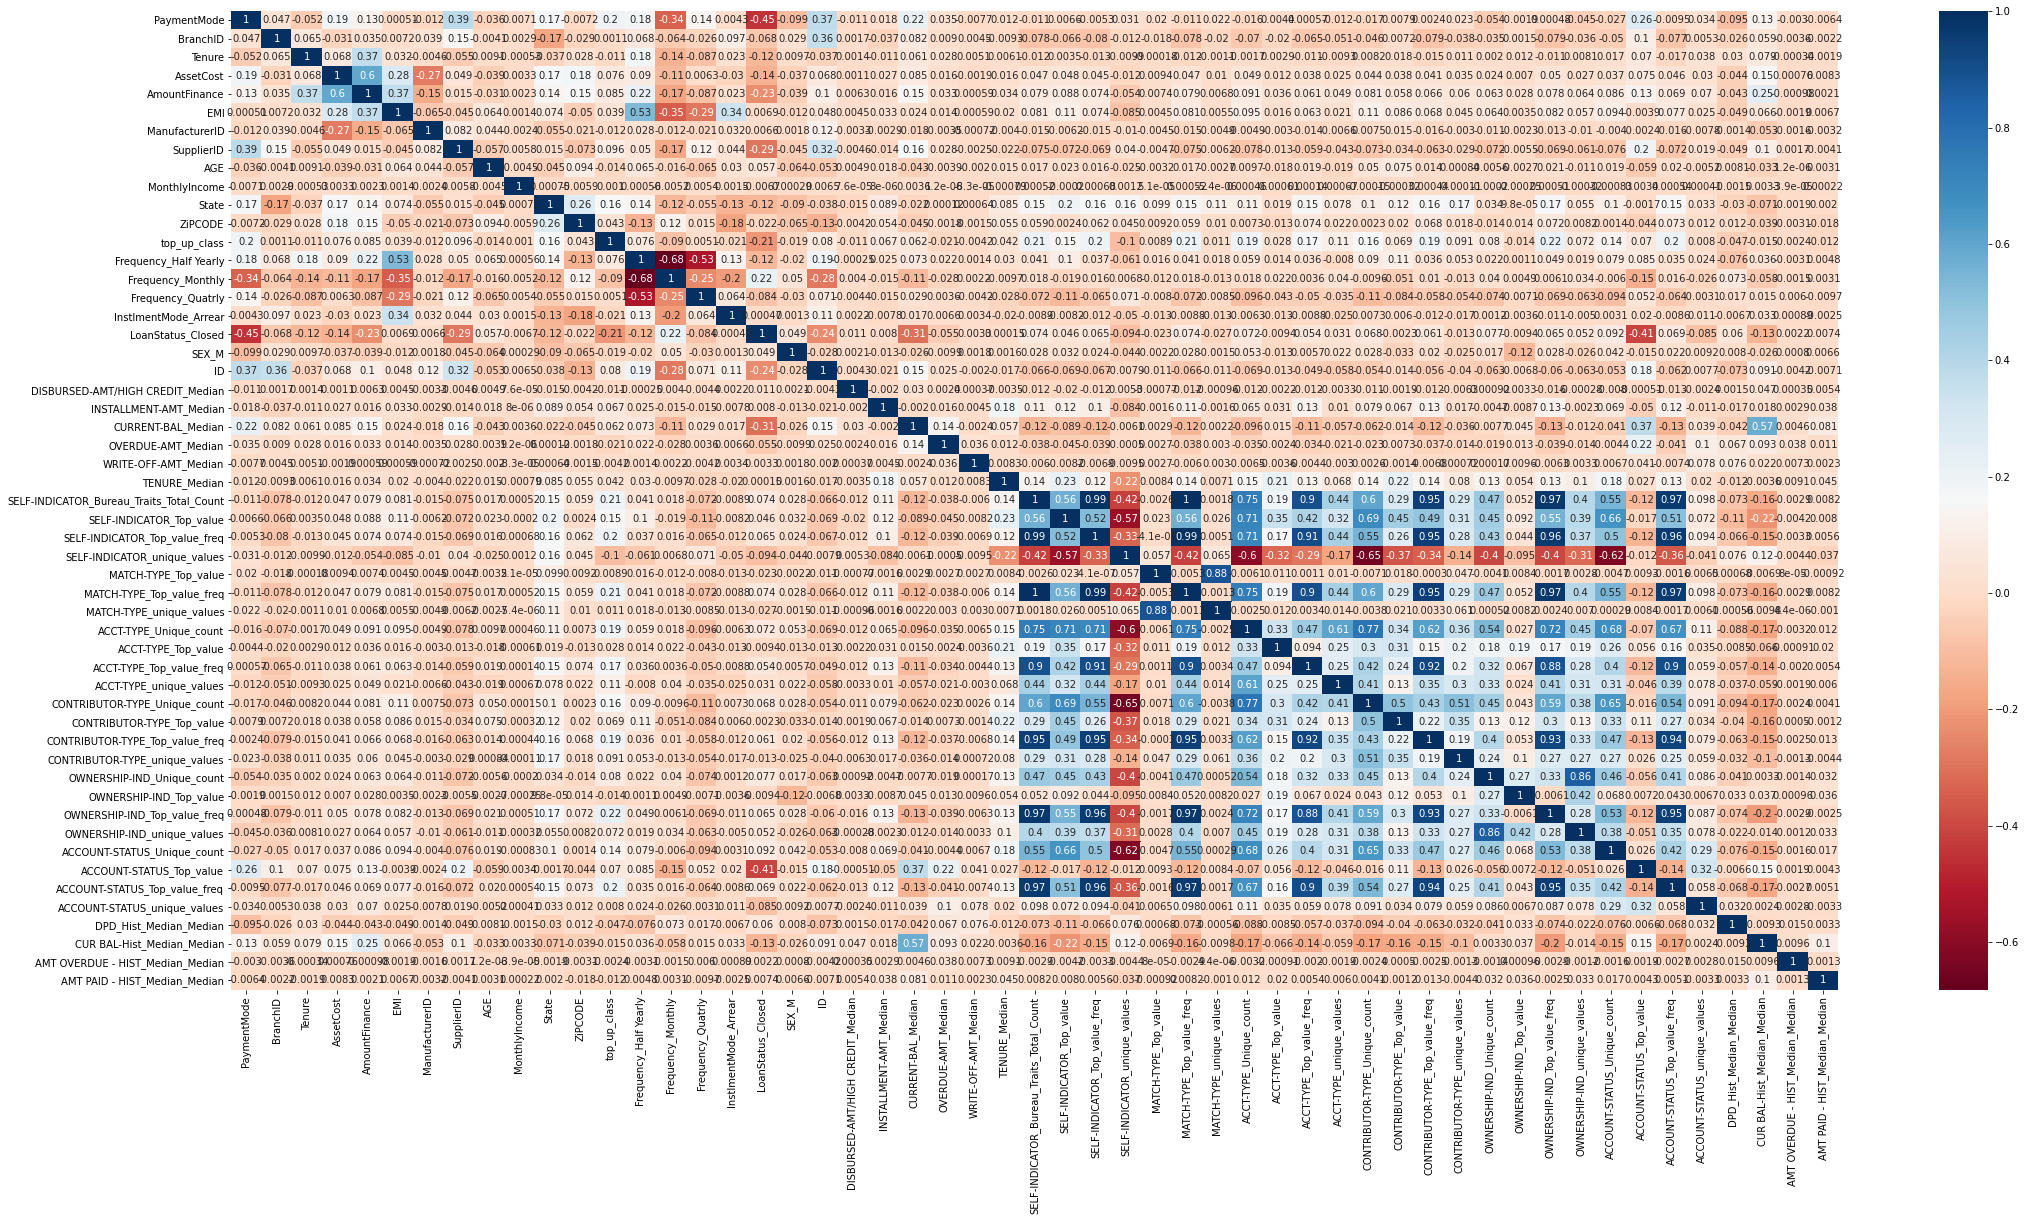

In [ ]:
dataset = train_dataset.copy()
plt.figure(figsize=(36, 18))
sns.heatmap(dataset.corr(),annot=True,cmap='RdBu')
plt.show()

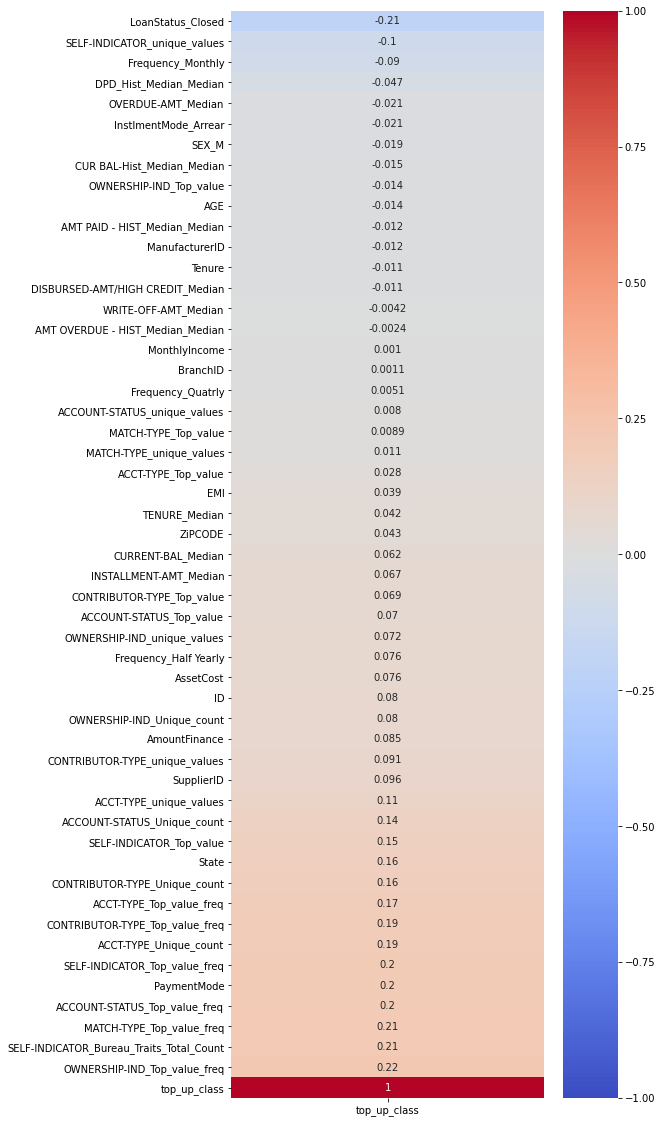

In [ ]:
plt.figure(figsize=(7, 20))
sns.heatmap(dataset.corr()[['top_up_class']].sort_values(by='top_up_class'), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1) 

In [ ]:
dataset_only_independent = dataset.copy()
dataset_only_independent = dataset_only_independent.drop(['top_up_class'],axis=1)
dataset_only_independent.head(2)

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   

   Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0                      0                  1                  0   
1                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          275000.0                     0.0   
1                          700000.0                     0.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0                 0.0                 0.0                   0.0   
1             52421.0                 0.0                   0.0   

   TENURE_Median  SELF-INDICATOR_Bureau_Traits_Total_Count  \
0            0.0                                         9   
1           35.0                                        13   

   SELF-INDICATOR_Top_value  SELF-INDICATOR_Top_value_freq  \
0                         1                              5   
1                         2                             12   

   SELF-INDICATOR_unique_values  MATCH-TYPE_Top_value  \
0                             1                     1   
1                             1                     1   

   MATCH-TYPE_Top_value_freq  MATCH-TYPE_unique_values  \
0                          9                         1   
1                         13                         1   

   ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
0                       4                    7                         5   
1                       7                   10                         4   

   ACCT-TYPE_unique_values  CONTRIBUTOR-TYPE_Unique_count  \
0                      482                              2   
1                     6112                              2   

   CONTRIBUTOR-TYPE_Top_value  CONTRIBUTOR-TYPE_Top_value_freq  \
0                           1                                5   
1                           1                                7   

   CONTRIBUTOR-TYPE_unique_values  OWNERSHIP-IND_Unique_count  \
0                               2                           1   
1                               3                           2   

   OWNERSHIP-IND_Top_value  OWNERSHIP-IND_Top_value_freq  \
0                        1                             9   
1                        1                             9   

   OWNERSHIP-IND_unique_values  ACCOUNT-STATUS_Unique_count  \
0                            1                            3   
1                            3                            2   

   ACCOUNT-STATUS_Top_value  ACCOUNT-STATUS_Top_value_freq  \
0                         1                              5   
1                         2                              7   

   ACCOUNT-STATUS_unique_values  DPD_Hist_Median_Median  \
0                             4                     0.0   
1                             1                     0.0   

   CUR BAL-Hist_Median_Median  AMT OVERDUE - HIST_Median_Median  \
0                    125115.5                             615.0   
1                    334547.5                               0.0   

   AMT PAID - HIST_Median_Median  
0                            0.0  
1                            0.0

In [ ]:
def high_correlation_train_set_indpendent(dataset,threshold):
    col_corr = set() #Set of all names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # It also consider -ve corr - You can remove abs() - If you dont wont to consider -ve corr
            if abs(corr_matrix.iloc[i,j]) > threshold: 
                col_name = corr_matrix.columns[i]
                col_corr.add(col_name)
    return col_corr

### These function return correlated features which are to be removed , Becaause they are correlated with any other feature

In [ ]:
corr_features = high_correlation_train_set_indpendent(dataset_only_independent,0.8)
corr_features

{'ACCOUNT-STATUS_Top_value_freq',
 'ACCT-TYPE_Top_value_freq',
 'CONTRIBUTOR-TYPE_Top_value_freq',
 'MATCH-TYPE_Top_value_freq',
 'MATCH-TYPE_unique_values',
 'OWNERSHIP-IND_Top_value_freq',
 'OWNERSHIP-IND_unique_values',
 'SELF-INDICATOR_Top_value_freq'}

In [ ]:
train_dataset = train_dataset.drop(corr_features,axis=1)
test_dataset = test_dataset.drop(corr_features,axis=1)
train_dataset.shape , test_dataset.shape

((128654, 45), (14745, 44))

In [ ]:
y = train_dataset['top_up_class']
X = train_dataset.drop('top_up_class',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(102923, 44) (25731, 44) (102923,) (25731,)


In [ ]:
sc = StandardScaler()
X_train_st = sc.fit_transform(X_train)
X_test_st = sc.transform(X_test)

In [ ]:
estimators_st = {
    'Logistic Regression': [LogisticRegression()],
    'KNN' :[KNeighborsClassifier()],
    'Decision Tree' :[DecisionTreeClassifier()],
    'Random Forest' :[RandomForestClassifier()],
    'Gradient Boosting':[GradientBoostingClassifier()],
    'XG Boost': [XGBClassifier()],
    'LGBM':[LGBMClassifier()],
    'Cat Boost':[CatBoostClassifier(verbose=0, n_estimators=1000)],
}

#writing a function to fit models above to the train dataset
def mfit(estimators_st, X_train, y_train):
    for m in estimators_st:
        estimators_st[m][0].fit(X_train, y_train)
        print(m+' fitted')

mfit(estimators_st, X_train_st, y_train)

def mpredict(estimators_st, X_test_st, y_test):
    outcome = dict()
    for m in estimators_st:
        y_pred = estimators_st[m][0].predict(X_test_st)
        outcome[m] = [metrics.f1_score(y_test,y_pred,average='macro'),
                      metrics.accuracy_score(y_test,y_pred),
                      metrics.classification_report(y_test,y_pred)]
    return outcome


outcome_st = mpredict(estimators_st, X_test_st, y_test)

for m in outcome_st:
    print('------------------------'+m+'------------------------')
    print('F1 Score', round(outcome_st[m][0],4))
    print('Accuracy Score', round(outcome_st[m][1],4))
    print('Classification report \n ')
    print(outcome_st[m][2])
    print('\n')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression fitted
KNN fitted
Decision Tree fitted
Random Forest fitted
Gradient Boosting fitted
XG Boost fitted
LGBM fitted
Cat Boost fitted


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------------------------Logistic Regression------------------------
F1 Score 0.1664
Accuracy Score 0.828
Classification report 
 
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     21279
           1       0.46      0.09      0.16      1642
           2       0.05      0.00      0.00       761
           3       0.31      0.02      0.04       683
           4       0.33      0.00      0.01       663
           5       0.34      0.03      0.05       502
           6       0.00      0.00      0.00       201

    accuracy                           0.83     25731
   macro avg       0.33      0.16      0.17     25731
weighted avg       0.75      0.83      0.76     25731



------------------------KNN------------------------
F1 Score 0.1945
Accuracy Score 0.8219
Classification report 
 
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     21279
           1       0.39      0.17      0.24    

### Handling Imbalanced Dataset

In [ ]:
train_dataset = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/Final/Final Dataset for Training/train_data_final_bur_combined_rank_cat_enc.xlsx')
train_dataset = train_dataset.iloc[:,1:]
test_dataset = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/Final/Final Dataset for Training/test_data_final_bur_combined_rank_cat_enc.xlsx')
test_dataset = test_dataset.iloc[:,1:]
display(train_dataset.head())
display(test_dataset.head())
print(train_dataset.shape , test_dataset.shape)

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         1      48     450000       275000.0  24000.0   
1     0.255776       333      47     485000       350000.0  10500.0   
2     0.668451         1      68     690000       519728.0  38300.0   
3     0.168888       125      48     480000       400000.0  11600.0   
4     0.168888       152      44     619265       440000.0  15000.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1568       21946   49       35833.33  0.425187   464993   
1            1062       34802   23         666.67  0.425187   466001   
2            1060      127335   39       45257.00  0.425187   462030   
3            1060       25094   24       20833.33  0.425187   473335   
4            1046       21853   56       27313.67  0.269824   495442   

   top_up_class  Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0             1                      0                  1                  0   
1             0                      0                  1                  0   
2             6                      0                  0                  1   
3             1                      0                  1                  0   
4             2                      0                  1                  0   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M  ID  \
0                     1                  1      1   1   
1                     0                  1      1   2   
2                     1                  0      1   3   
3                     0                  1      1   7   
4                     1                  1      1   8   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          275000.0                     0.0   
1                          700000.0                     0.0   
2                           44000.0                     0.0   
3                          315000.0                     0.0   
4                          200000.0                     0.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0                 0.0                 0.0                   0.0   
1             52421.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   
3                 0.0                 0.0                   0.0   
4              6989.0                 0.0                   0.0   

   TENURE_Median  SELF-INDICATOR_Bureau_Traits_Total_Count  \
0            0.0                                         9   
1           35.0                                        13   
2            0.0                                        31   
3            5.0                                         4   
4           42.0                                         7   

   SELF-INDICATOR_Top_value  SELF-INDICATOR_Top_value_freq  \
0                         1                              5   
1                         2                             12   
2                         2                             29   
3                         1                              2   
4                         2                              6   

   SELF-INDICATOR_unique_values  MATCH-TYPE_Top_value  \
0                             1                     1   
1                             1                     1   
2                             1                     1   
3                             1                     1   
4                             1                     1   

   MATCH-TYPE_Top_value_freq  MATCH-TYPE_unique_values  \
0                          9                         1   
1                         13                         1   
2                         31                         1   
3                          4                         1   
4                          7                         1   

   ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
0                      

PaymentMode  BranchID  Tenure  AssetCost  AmountFinance      EMI  \
0     0.186877         2      46     480000       365000.0   1000.0   
1     0.255776         2      45     480000       285000.0   9300.0   
2     0.255776         2      48     580000       400000.0  35800.0   
3     0.168888       154      36     725000       500000.0  52000.0   
4     0.255776       194      48     617000       400000.0  35400.0   

   ManufacturerID  SupplierID  AGE  MonthlyIncome     State  ZiPCODE  \
0            1046       22354   50       32069.00  0.425187   473001   
1            1046       22354   35       25000.00  0.425187   473001   
2            1060       65929   37       23333.33  0.425187   473001   
3            1049       68597   55       91666.67  0.269824   493558   
4            1049       38493   48       12500.00  0.430084   754137   

   Frequency_Half Yearly  Frequency_Monthly  Frequency_Quatrly  \
0                      0                  1                  0   
1                      0                  1                  0   
2                      0                  0                  1   
3                      1                  0                  0   
4                      0                  0                  1   

   InstlmentMode_Arrear  LoanStatus_Closed  SEX_M   ID  \
0                     0                  1      1    4   
1                     0                  1      1    5   
2                     1                  1      1    6   
3                     1                  1      1   25   
4                     1                  1      1  119   

   DISBURSED-AMT/HIGH CREDIT_Median  INSTALLMENT-AMT_Median  \
0                          232000.0                   611.5   
1                          106008.0                     0.0   
2                          230000.0                     0.0   
3                          400000.0                     0.0   
4                          465000.0                  8000.0   

   CURRENT-BAL_Median  OVERDUE-AMT_Median  WRITE-OFF-AMT_Median  \
0             42023.5                 0.0                   0.0   
1                 0.0                 0.0                   0.0   
2                 0.0                 0.0                   0.0   
3             63796.5                 0.0                   0.0   
4             58100.0                 0.0                   0.0   

   TENURE_Median  SELF-INDICATOR_Bureau_Traits_Total_Count  \
0           60.0                                         4   
1            0.0                                         8   
2            9.5                                        12   
3            0.0                                         2   
4           23.0                                         2   

   SELF-INDICATOR_Top_value  SELF-INDICATOR_Top_value_freq  \
0                         2                              3   
1                         2                              7   
2                         2                             10   
3                         1                              1   
4                         1                              1   

   SELF-INDICATOR_unique_values  MATCH-TYPE_Top_value  \
0                             1                     1   
1                             1                     1   
2                             1                     1   
3                             1                     1   
4                             1                     1   

   MATCH-TYPE_Top_value_freq  MATCH-TYPE_unique_values  \
0                          4                         1   
1                          8                         1   
2                         12                         1   
3                          2                         1   
4                          2                         1   

   ACCT-TYPE_Unique_count  ACCT-TYPE_Top_value  ACCT-TYPE_Top_value_freq  \
0                       4                    1                         1   
1                       5

(128654, 53) (14745, 52)


In [ ]:
y = train_dataset['top_up_class']
X = train_dataset.drop('top_up_class',axis=1)
X.shape , y.shape

((128654, 52), (128654,))

Class=1, n=8366 (6.503%)
Class=0, n=106676 (82.917%)
Class=6, n=1034 (0.804%)
Class=2, n=3656 (2.842%)
Class=5, n=2368 (1.841%)
Class=3, n=3492 (2.714%)
Class=4, n=3062 (2.380%)


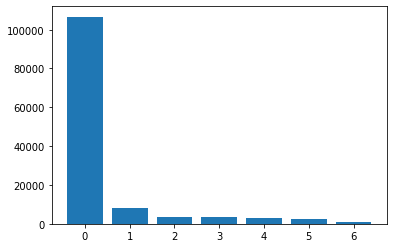

In [ ]:
from collections import Counter
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

Class=1, n=106676 (14.286%)
Class=0, n=106676 (14.286%)
Class=6, n=106676 (14.286%)
Class=2, n=106676 (14.286%)
Class=5, n=106676 (14.286%)
Class=3, n=106676 (14.286%)
Class=4, n=106676 (14.286%)


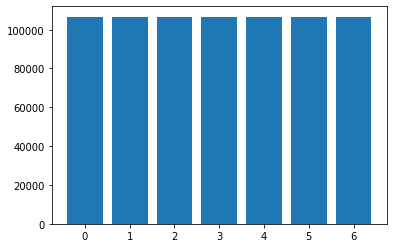

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(597385, 52) (149347, 52) (597385,) (149347,)


In [ ]:
sc = StandardScaler()
X_train_st = sc.fit_transform(X_train)
X_test_st = sc.transform(X_test)

In [ ]:
estimators_st = {
    'Logistic Regression': [LogisticRegression()],
    'KNN' :[KNeighborsClassifier()],
    'Decision Tree' :[DecisionTreeClassifier()],
    'Random Forest' :[RandomForestClassifier()],
    'Gradient Boosting':[GradientBoostingClassifier()],
    'XG Boost': [XGBClassifier()],
    'LGBM':[LGBMClassifier()],
    'Cat Boost':[CatBoostClassifier(verbose=0, n_estimators=1000)],
}

#writing a function to fit models above to the train dataset
def mfit(estimators_st, X_train, y_train):
    for m in estimators_st:
        estimators_st[m][0].fit(X_train, y_train)
        print(m+' fitted')

mfit(estimators_st, X_train_st, y_train)

def mpredict(estimators_st, X_test_st, y_test):
    outcome = dict()
    for m in estimators_st:
        y_pred = estimators_st[m][0].predict(X_test_st)
        outcome[m] = [metrics.f1_score(y_test,y_pred,average='macro'),
                      metrics.accuracy_score(y_test,y_pred),
                      metrics.classification_report(y_test,y_pred)]
    return outcome


outcome_st = mpredict(estimators_st, X_test_st, y_test)

for m in outcome_st:
    print('------------------------'+m+'------------------------')
    print('F1 Score', round(outcome_st[m][0],4))
    print('Accuracy Score', round(outcome_st[m][1],4))
    print('Classification report \n ')
    print(outcome_st[m][2])
    print('\n')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression fitted
KNN fitted
Decision Tree fitted
Random Forest fitted
Gradient Boosting fitted
XG Boost fitted
LGBM fitted
Cat Boost fitted
------------------------Logistic Regression------------------------
F1 Score 0.441
Accuracy Score 0.4495
Classification report 
 
              precision    recall  f1-score   support

           0       0.58      0.71      0.64     21066
           1       0.55      0.62      0.58     21359
           2       0.33      0.22      0.26     21275
           3       0.42      0.35      0.38     21591
           4       0.39      0.42      0.40     21391
           5       0.42      0.44      0.43     21260
           6       0.39      0.40      0.39     21405

    accuracy                           0.45    149347
   macro avg       0.44      0.45      0.44    149347
weighted avg       0.44      0.45      0.44    149347



------------------------KNN------------------------
F1 Score 0.9219
Accuracy Score 0.9257
Classification report 
 
      

#### Random Forest Classifier With Imbalanced Dataset Handling

In [ ]:
X.shape ,y.shape

((746732, 52), (746732,))

In [ ]:
sc = StandardScaler()
X_st = sc.fit_transform(X)
test_final_st = sc.transform(test_dataset)

In [ ]:
model_rf_final_submit = RandomForestClassifier()

#model_rf_final_submit = RandomForestClassifier()
model_rf_final_submit = model_rf_final_submit.fit(X_st,y)

y_pred = model_rf_final_submit.predict(test_final_st)

In [ ]:
top_up_class_label_dict = {
    0:'No Top-up Service',
    1:' > 48 Months',
    2:'36-48 Months',
    3:'24-30 Months',
    4:'30-36 Months',
    5:'18-24 Months',
    6:'12-18 Months'
}
submission_df = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_Data.xlsx')
submission_df['Pred'] = list(y_pred)
sub = submission_df[['ID','Pred']]
sub.columns = ['ID','Top-up Month']
sub['Top-up Month_Final'] = sub['Top-up Month'].map(top_up_class_label_dict)
sub = sub.drop('Top-up Month',axis=1)
sub.columns = ['ID','Top-up Month']
sub['Top-up Month'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


No Top-up Service    14531
 > 48 Months           191
24-30 Months             8
30-36 Months             7
36-48 Months             6
18-24 Months             2
Name: Top-up Month, dtype: int64

In [ ]:
sub.to_csv('submit_rf_updated_final_train1.csv',index=False)